In [29]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
import torchvision.transforms as tt
from torch.autograd import Variable

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [30]:
IMAGE_CHANNEL = 1
INITIAL_CHANNEL = 4
Z_DIM = 100
G_HIDDEN = 64
X_DIM = 64
D_HIDDEN = 64
EPOCH_NUM = 5
REAL_LABEL = 1
FAKE_LABEL = 0
lr = 2e-4

In [31]:
transform = tt.Compose([
    tt.Resize(64), # Reszie from 28x28 to 64x64
    tt.ToTensor(),
    #tt.Normalize((0.1307,), (0.3081,))
])

In [39]:
dataset = datasets.MNIST('.', train=True, transform = transform, download=False)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=512, shuffle=True)
# test_dataset = datasets.MNIST('.', train=False, transform = transform, download=False)
# test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [40]:
class Flatten(nn.Module):
    def forward(self, input):
        
        return input.view(input.size()[0], -1).to(device) # for connecting conv layer and linear layer

    
class UnFlatten(nn.Module):
    def forward(self, input):
        
        return input.view(input.size()[0], 64, 2, 2).to(device) # for connecting linear layer and conv layer

class VAE(nn.Module):
    def __init__(self, image_channels= IMAGE_CHANNEL, output_channels= INITIAL_CHANNEL, h_dim=256, z_dim=16): # h_dim : last hidden dimension, z_dim : latent dimension
        super(VAE, self).__init__()
        self.z_dim = z_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, output_channels, kernel_size=3, stride=2, padding = 1),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(),
            nn.Conv2d(output_channels, output_channels*2, kernel_size=3, stride=2, padding = 1),
            nn.BatchNorm2d(output_channels*2),
            nn.ReLU(),
            nn.Conv2d(output_channels*2, output_channels*4, kernel_size=3, stride=2, padding = 1),
            nn.BatchNorm2d(output_channels*4),
            nn.ReLU(),
            nn.Conv2d(output_channels*4, output_channels*8, kernel_size=3, stride=2, padding = 1),
            nn.BatchNorm2d(output_channels*8),
            nn.ReLU(),
            nn.Conv2d(output_channels*8, output_channels*16, kernel_size=3, stride=2, padding = 1),
            nn.BatchNorm2d(output_channels*16),
            nn.ReLU(),
            nn.Dropout(0.8),
            Flatten()
        )

        
        self.fc1 = nn.Linear(h_dim, z_dim).to(device) # for mu right before reparameterization
        self.fc2 = nn.Linear(h_dim, z_dim).to(device) # for logvar right before reparameterization

        self.fc3 = nn.Linear(z_dim, h_dim).to(device) # right before decoding starts
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(output_channels*16, output_channels*8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(output_channels*8),
            nn.ReLU(),
            nn.ConvTranspose2d(output_channels*8, output_channels*4, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(output_channels*4),
            nn.ReLU(),
            nn.ConvTranspose2d(output_channels*4, output_channels*2, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(output_channels*2),            
            nn.ReLU(),
            nn.ConvTranspose2d(output_channels*2, output_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(output_channels),            
            nn.ReLU(),
            nn.ConvTranspose2d(output_channels, image_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(image_channels),
            nn.Sigmoid() # so that make the range of values 0~1
        )
        
    def reparameterize(self, mu, logvar):

        std = logvar.mul(0.5).exp_()
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp # N(mu, std) ~ N(0, 1) * std + mu
        return z

    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h) # never add activation functions here!
        #logvar = torch.clamp(logvar, min=-4, max=4) # prevent exploding of variance later on
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        return self.bottleneck(h)
        
    def decode(self, z):
        z = F.relu(self.fc3(z))
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x) # save mu and logvar
        z = self.decode(z) # decode reparameterized z
        return z, mu, logvar

In [41]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    
    #BCE = nn.MSELoss()
    #BCE = BCE(recon_x, x) # unless value range = [0, 1],
                           # use MSELoss since you cannot use BCELoss

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD, BCE, KLD

In [42]:
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

model = VAE()
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0003) 
scheduler = StepLR(optimizer, step_size=20, gamma=0.9)  # decrease to 90% at every 20 epochs

Epoch 1/500: 100%|████████████████████████████| 118/118 [00:12<00:00,  9.62it/s]


Epoch [1/500], Loss: 136448.8438 (total loss), 133364.6562 (bce), 3084.1907 (kld)
Mu range: -1.1760048866271973 ~ 2.097531795501709, Logvar range: -5.295830726623535 ~ -1.4148473739624023
tensor(5)


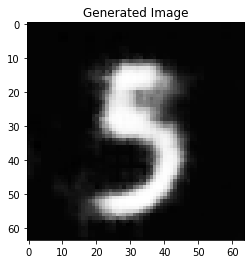

Epoch 2/500: 100%|████████████████████████████| 118/118 [00:10<00:00, 11.15it/s]


Epoch [2/500], Loss: 132999.5312 (total loss), 129657.6562 (bce), 3341.8799 (kld)
Mu range: -1.7960089445114136 ~ 2.317471504211426, Logvar range: -5.539769172668457 ~ -2.028667688369751
tensor(3)


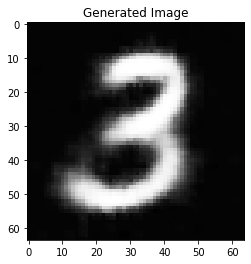

Epoch 3/500: 100%|████████████████████████████| 118/118 [00:11<00:00, 10.57it/s]


Epoch [3/500], Loss: 132231.5156 (total loss), 128762.4219 (bce), 3469.0874 (kld)
Mu range: -3.371732234954834 ~ 1.283036470413208, Logvar range: -7.750156879425049 ~ -2.3728599548339844
tensor(9)


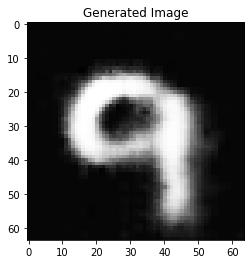

Epoch 4/500: 100%|████████████████████████████| 118/118 [00:11<00:00, 10.13it/s]


Epoch [4/500], Loss: 132564.0469 (total loss), 129358.1719 (bce), 3205.8765 (kld)
Mu range: -3.0930209159851074 ~ 0.9047582149505615, Logvar range: -6.298839569091797 ~ -2.1280834674835205
tensor(4)


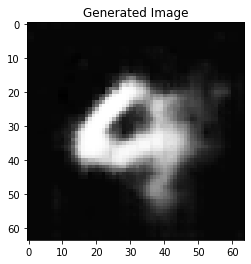

Epoch 5/500: 100%|████████████████████████████| 118/118 [00:11<00:00, 10.45it/s]


Epoch [5/500], Loss: 129306.5703 (total loss), 125948.8438 (bce), 3357.7290 (kld)
Mu range: -1.2665467262268066 ~ 2.2684192657470703, Logvar range: -5.833395004272461 ~ -1.7775191068649292
tensor(3)


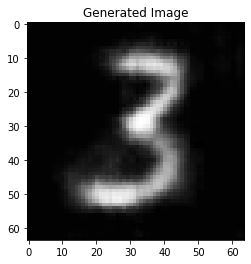

Epoch 6/500: 100%|████████████████████████████| 118/118 [00:11<00:00, 10.63it/s]


Epoch [6/500], Loss: 125554.3594 (total loss), 122192.5469 (bce), 3361.8086 (kld)
Mu range: -3.0411930084228516 ~ 4.673277854919434, Logvar range: -9.09459400177002 ~ -2.6130361557006836
tensor(3)


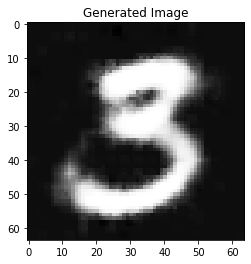

Epoch 7/500: 100%|████████████████████████████| 118/118 [00:11<00:00, 10.26it/s]


Epoch [7/500], Loss: 124568.2344 (total loss), 121084.4141 (bce), 3483.8181 (kld)
Mu range: -2.312666177749634 ~ 1.7862759828567505, Logvar range: -7.653041839599609 ~ -2.3158352375030518
tensor(6)


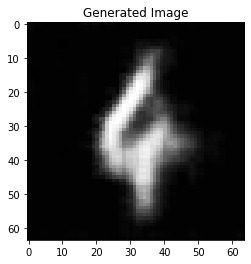

Epoch 8/500: 100%|████████████████████████████| 118/118 [00:11<00:00, 10.65it/s]

Epoch [8/500], Loss: 122722.8984 (total loss), 119580.7812 (bce), 3142.1162 (kld)
Mu range: -1.1694508790969849 ~ 1.8766708374023438, Logvar range: -5.05387020111084 ~ -1.2848987579345703
tensor(3)


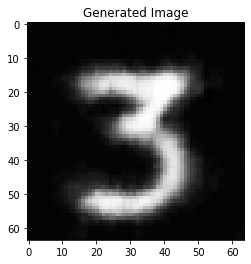

Epoch 9/500: 100%|████████████████████████████| 118/118 [00:11<00:00, 10.24it/s]


Epoch [9/500], Loss: 122093.0000 (total loss), 118787.6094 (bce), 3305.3887 (kld)
Mu range: -1.4784785509109497 ~ 0.9598764777183533, Logvar range: -4.360340595245361 ~ -1.4419045448303223
tensor(7)


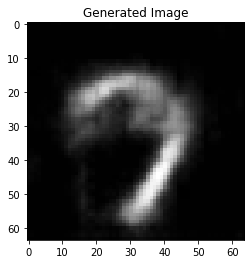

Epoch 10/500: 100%|███████████████████████████| 118/118 [00:10<00:00, 10.82it/s]


Epoch [10/500], Loss: 123487.7812 (total loss), 120179.2734 (bce), 3308.5061 (kld)
Mu range: -4.379127502441406 ~ 2.115736246109009, Logvar range: -9.615588188171387 ~ -2.6690196990966797
tensor(5)


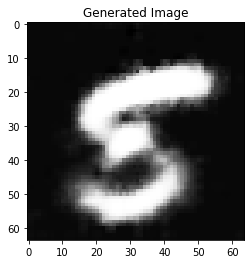

Epoch 11/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.45it/s]


Epoch [11/500], Loss: 117387.9375 (total loss), 113961.8047 (bce), 3426.1301 (kld)
Mu range: -1.5991603136062622 ~ 1.607377052307129, Logvar range: -6.717536449432373 ~ -1.8204560279846191
tensor(8)


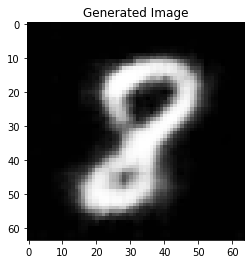

Epoch 12/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.34it/s]


Epoch [12/500], Loss: 119532.9844 (total loss), 116035.8438 (bce), 3497.1384 (kld)
Mu range: -1.7483136653900146 ~ 2.2986559867858887, Logvar range: -6.669373035430908 ~ -1.9775654077529907
tensor(7)


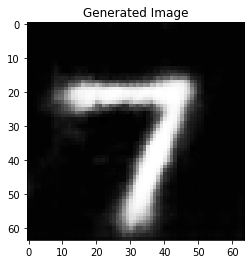

Epoch 13/500: 100%|███████████████████████████| 118/118 [00:10<00:00, 10.80it/s]


Epoch [13/500], Loss: 117814.1797 (total loss), 114435.7891 (bce), 3378.3933 (kld)
Mu range: -2.139070749282837 ~ 1.1354901790618896, Logvar range: -5.354711532592773 ~ -1.7422713041305542
tensor(6)


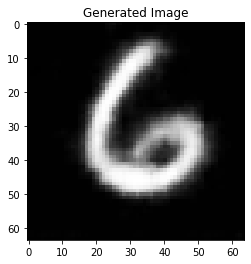

Epoch 14/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.22it/s]


Epoch [14/500], Loss: 113831.5703 (total loss), 110457.1094 (bce), 3374.4604 (kld)
Mu range: -4.577179431915283 ~ 2.874037742614746, Logvar range: -8.482063293457031 ~ -2.1678924560546875
tensor(0)


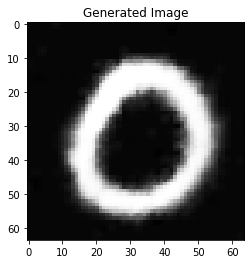

Epoch 15/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.52it/s]


Epoch [15/500], Loss: 112936.4062 (total loss), 109314.0312 (bce), 3622.3787 (kld)
Mu range: -2.1266977787017822 ~ 1.6840192079544067, Logvar range: -4.685538291931152 ~ -1.4459511041641235
tensor(4)


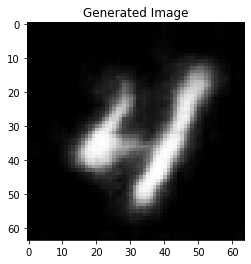

Epoch 16/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.49it/s]


Epoch [16/500], Loss: 110933.3203 (total loss), 107547.9766 (bce), 3385.3452 (kld)
Mu range: -1.8446698188781738 ~ 2.1384475231170654, Logvar range: -6.654441833496094 ~ -2.0141637325286865
tensor(4)


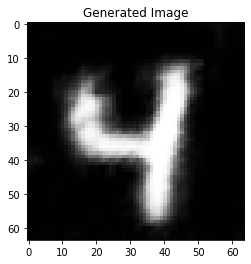

Epoch 17/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.57it/s]


Epoch [17/500], Loss: 111490.0391 (total loss), 108127.4922 (bce), 3362.5435 (kld)
Mu range: -1.8307311534881592 ~ 4.212736129760742, Logvar range: -6.392502784729004 ~ -1.812260389328003
tensor(6)


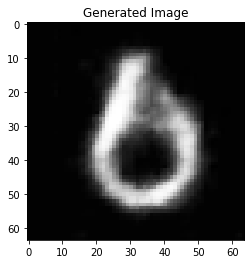

Epoch 18/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.04it/s]

Epoch [18/500], Loss: 109240.6641 (total loss), 105697.5781 (bce), 3543.0859 (kld)
Mu range: -1.6130132675170898 ~ 1.3015191555023193, Logvar range: -4.740700721740723 ~ -1.1311028003692627
tensor(6)


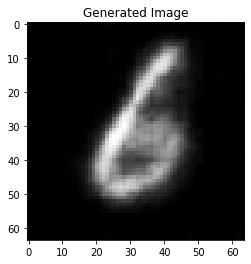

Epoch 19/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.46it/s]


Epoch [19/500], Loss: 110676.0078 (total loss), 107400.9688 (bce), 3275.0400 (kld)
Mu range: -1.1378936767578125 ~ 1.2056965827941895, Logvar range: -5.312239170074463 ~ -1.09694504737854
tensor(1)


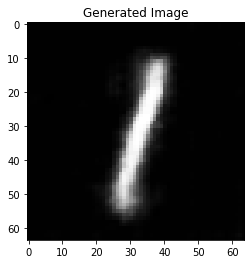

Epoch 20/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.43it/s]


Epoch [20/500], Loss: 109219.3281 (total loss), 105857.9219 (bce), 3361.4084 (kld)
Mu range: -1.3175452947616577 ~ 0.43573182821273804, Logvar range: -4.4176025390625 ~ -1.317564845085144
tensor(8)


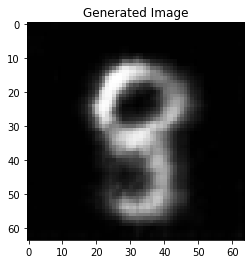

Epoch 21/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.24it/s]


Epoch [21/500], Loss: 106913.4688 (total loss), 103549.6562 (bce), 3363.8130 (kld)
Mu range: -2.8712334632873535 ~ 0.7891005277633667, Logvar range: -8.194077491760254 ~ -2.5261495113372803
tensor(7)


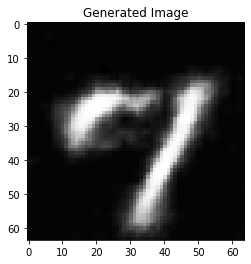

Epoch 22/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.38it/s]


Epoch [22/500], Loss: 105979.0547 (total loss), 102640.7266 (bce), 3338.3289 (kld)
Mu range: -1.1480919122695923 ~ 1.776324987411499, Logvar range: -4.713958263397217 ~ -0.8810780048370361
tensor(3)


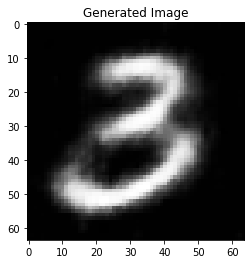

Epoch 23/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.63it/s]


Epoch [23/500], Loss: 104405.8984 (total loss), 101060.4531 (bce), 3345.4421 (kld)
Mu range: -3.4904909133911133 ~ 0.9488043785095215, Logvar range: -6.425060749053955 ~ -1.8054611682891846
tensor(4)


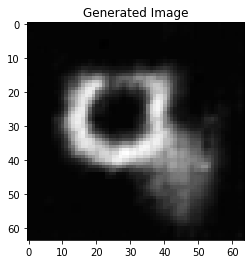

Epoch 24/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.43it/s]


Epoch [24/500], Loss: 105637.7812 (total loss), 102452.6484 (bce), 3185.1333 (kld)
Mu range: -3.030541181564331 ~ 1.814893126487732, Logvar range: -6.31781005859375 ~ -1.599250316619873
tensor(7)


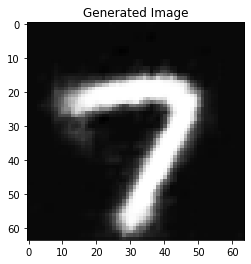

Epoch 25/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.58it/s]

Epoch [25/500], Loss: 101326.4688 (total loss), 97929.6562 (bce), 3396.8125 (kld)
Mu range: -1.9195448160171509 ~ 2.4846603870391846, Logvar range: -7.564709663391113 ~ -2.386106014251709
tensor(4)


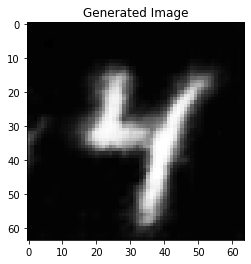

Epoch 26/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.44it/s]

Epoch [26/500], Loss: 100711.5547 (total loss), 97267.2031 (bce), 3444.3501 (kld)
Mu range: -0.9268879294395447 ~ 0.507217526435852, Logvar range: -3.8662960529327393 ~ -1.2010953426361084
tensor(1)


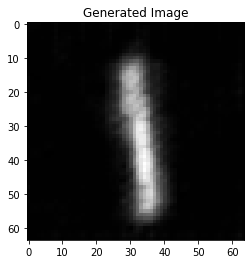

Epoch 27/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.62it/s]


Epoch [27/500], Loss: 99605.0000 (total loss), 96059.0938 (bce), 3545.9099 (kld)
Mu range: -3.202038049697876 ~ 2.0686452388763428, Logvar range: -6.870789051055908 ~ -1.878435730934143
tensor(4)


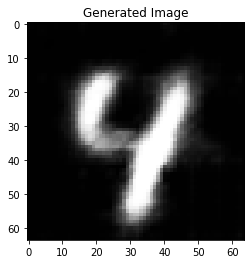

Epoch 28/500: 100%|███████████████████████████| 118/118 [00:10<00:00, 11.00it/s]


Epoch [28/500], Loss: 99261.4375 (total loss), 95589.8984 (bce), 3671.5408 (kld)
Mu range: -1.0680773258209229 ~ 1.3913418054580688, Logvar range: -4.259891033172607 ~ -1.1503968238830566
tensor(3)


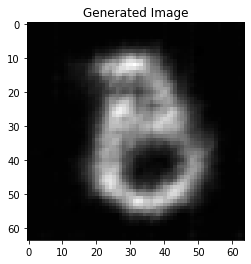

Epoch 29/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.71it/s]


Epoch [29/500], Loss: 100388.3828 (total loss), 97170.0234 (bce), 3218.3628 (kld)
Mu range: -2.1043660640716553 ~ 2.5359814167022705, Logvar range: -6.87481689453125 ~ -1.4397783279418945
tensor(7)


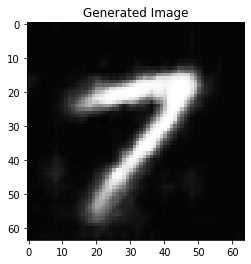

Epoch 30/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.66it/s]

Epoch [30/500], Loss: 97803.1797 (total loss), 94477.7656 (bce), 3325.4111 (kld)
Mu range: -1.5060395002365112 ~ 1.4062421321868896, Logvar range: -4.3160552978515625 ~ -1.000393033027649
tensor(2)


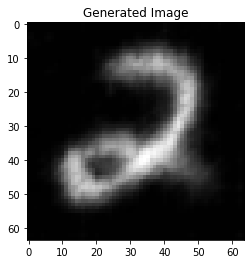

Epoch 31/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.58it/s]


Epoch [31/500], Loss: 98774.3672 (total loss), 95312.1328 (bce), 3462.2327 (kld)
Mu range: -3.8556408882141113 ~ 2.838362693786621, Logvar range: -7.343120574951172 ~ -2.017249584197998
tensor(2)


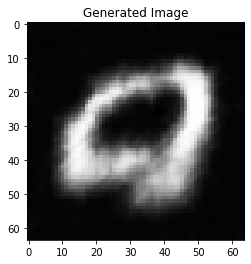

Epoch 32/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.52it/s]


Epoch [32/500], Loss: 97859.8125 (total loss), 94596.8047 (bce), 3263.0100 (kld)
Mu range: -1.3707953691482544 ~ 0.9524616599082947, Logvar range: -4.0214738845825195 ~ -1.2108873128890991
tensor(5)


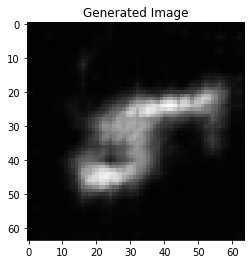

Epoch 33/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.32it/s]


Epoch [33/500], Loss: 98059.1797 (total loss), 94615.6250 (bce), 3443.5549 (kld)
Mu range: -0.9428933262825012 ~ 1.5502923727035522, Logvar range: -4.5766706466674805 ~ -0.976254940032959
tensor(1)


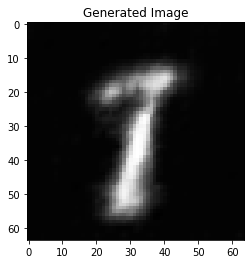

Epoch 34/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.48it/s]


Epoch [34/500], Loss: 94165.7891 (total loss), 90622.6719 (bce), 3543.1143 (kld)
Mu range: -1.8804683685302734 ~ 2.5425515174865723, Logvar range: -4.664414882659912 ~ -0.8545659780502319
tensor(2)


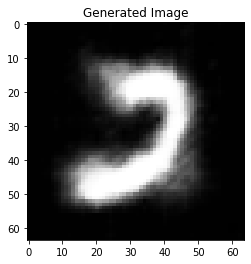

Epoch 35/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.64it/s]

Epoch [35/500], Loss: 94861.1094 (total loss), 91301.9688 (bce), 3559.1416 (kld)
Mu range: -2.7050154209136963 ~ 3.26960825920105, Logvar range: -8.69665241241455 ~ -2.018876791000366
tensor(8)


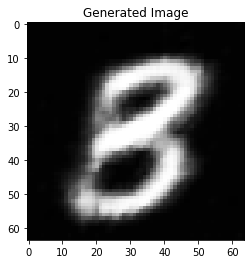

Epoch 36/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.72it/s]


Epoch [36/500], Loss: 93490.3672 (total loss), 90241.9375 (bce), 3248.4299 (kld)
Mu range: -1.3443125486373901 ~ 1.3948359489440918, Logvar range: -5.265722274780273 ~ -1.2719073295593262
tensor(1)


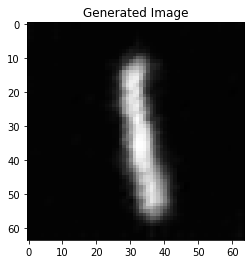

Epoch 37/500: 100%|███████████████████████████| 118/118 [00:10<00:00, 11.13it/s]


Epoch [37/500], Loss: 94339.3438 (total loss), 90927.0312 (bce), 3412.3130 (kld)
Mu range: -1.9582375288009644 ~ 1.5199321508407593, Logvar range: -5.600143909454346 ~ -1.4224804639816284
tensor(9)


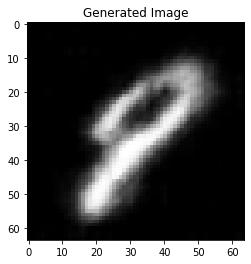

Epoch 38/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.66it/s]


Epoch [38/500], Loss: 93250.3516 (total loss), 89975.7812 (bce), 3274.5710 (kld)
Mu range: -1.3327398300170898 ~ 1.4714192152023315, Logvar range: -4.573370933532715 ~ -1.2474285364151
tensor(8)


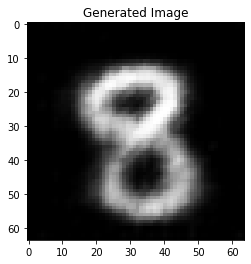

Epoch 39/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.30it/s]

Epoch [39/500], Loss: 92455.6953 (total loss), 89212.7188 (bce), 3242.9795 (kld)
Mu range: -1.3493822813034058 ~ 1.4062992334365845, Logvar range: -4.687613487243652 ~ -1.3161804676055908
tensor(2)


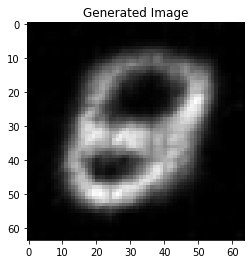

Epoch 40/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.48it/s]

Epoch [40/500], Loss: 92811.5625 (total loss), 89378.2422 (bce), 3433.3164 (kld)
Mu range: -0.9470816850662231 ~ 1.0147695541381836, Logvar range: -3.3549506664276123 ~ -1.1011940240859985
tensor(7)


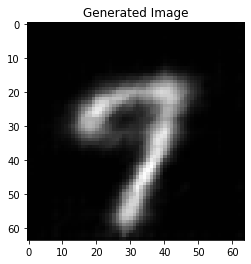

Epoch 41/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.49it/s]


Epoch [41/500], Loss: 89006.9844 (total loss), 85512.6328 (bce), 3494.3496 (kld)
Mu range: -1.8179608583450317 ~ 1.278986930847168, Logvar range: -5.9196882247924805 ~ -1.366330623626709
tensor(5)


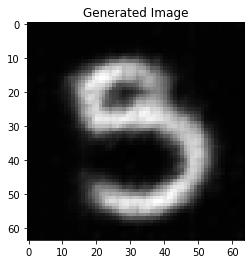

Epoch 42/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.38it/s]


Epoch [42/500], Loss: 91038.6406 (total loss), 87591.9688 (bce), 3446.6724 (kld)
Mu range: -2.0894644260406494 ~ 1.9857207536697388, Logvar range: -5.991141319274902 ~ -0.6700807213783264
tensor(5)


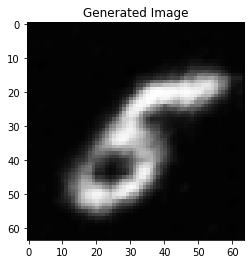

Epoch 43/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.38it/s]


Epoch [43/500], Loss: 88984.0703 (total loss), 85726.5078 (bce), 3257.5659 (kld)
Mu range: -1.2670187950134277 ~ 2.4607388973236084, Logvar range: -5.03650426864624 ~ -1.032078742980957
tensor(3)


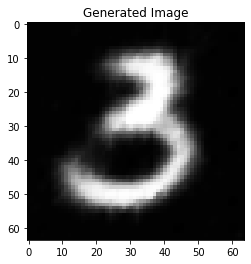

Epoch 44/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.25it/s]


Epoch [44/500], Loss: 90414.6172 (total loss), 86918.7500 (bce), 3495.8689 (kld)
Mu range: -1.2292743921279907 ~ 2.1562137603759766, Logvar range: -5.683987140655518 ~ -1.7143056392669678
tensor(6)


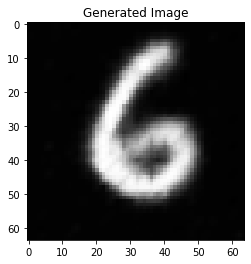

Epoch 45/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.47it/s]


Epoch [45/500], Loss: 89729.1641 (total loss), 86260.2422 (bce), 3468.9211 (kld)
Mu range: -2.632535934448242 ~ 2.2934212684631348, Logvar range: -5.953171730041504 ~ -1.1882297992706299
tensor(7)


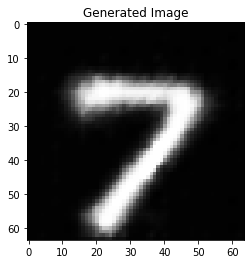

Epoch 46/500: 100%|███████████████████████████| 118/118 [00:10<00:00, 10.88it/s]

Epoch [46/500], Loss: 89840.5156 (total loss), 86551.1406 (bce), 3289.3765 (kld)
Mu range: -0.900139570236206 ~ 1.9089038372039795, Logvar range: -5.88083028793335 ~ -0.7358604073524475
tensor(1)


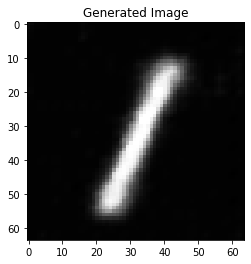

Epoch 47/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.61it/s]


Epoch [47/500], Loss: 89641.2422 (total loss), 86052.7500 (bce), 3588.4907 (kld)
Mu range: -0.4890018105506897 ~ 0.9184275269508362, Logvar range: -4.160704135894775 ~ -0.8791388273239136
tensor(3)


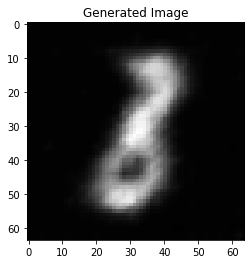

Epoch 48/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.42it/s]


Epoch [48/500], Loss: 89463.6953 (total loss), 86095.8594 (bce), 3367.8389 (kld)
Mu range: -1.120105504989624 ~ 1.5399587154388428, Logvar range: -5.497436046600342 ~ -1.3756663799285889
tensor(5)


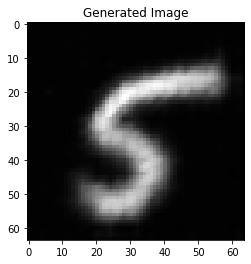

Epoch 49/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.15it/s]


Epoch [49/500], Loss: 86019.2656 (total loss), 82650.1641 (bce), 3369.1047 (kld)
Mu range: -3.5176196098327637 ~ 2.1390652656555176, Logvar range: -7.292886734008789 ~ -1.4931609630584717
tensor(6)


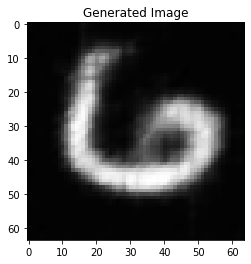

Epoch 50/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.15it/s]


Epoch [50/500], Loss: 90798.6250 (total loss), 87443.8516 (bce), 3354.7754 (kld)
Mu range: -1.8351805210113525 ~ 2.0965042114257812, Logvar range: -5.878700256347656 ~ -0.9677994251251221
tensor(1)


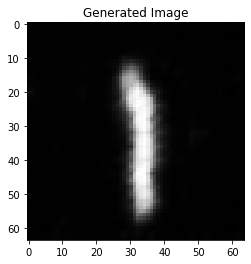

Epoch 51/500: 100%|███████████████████████████| 118/118 [00:10<00:00, 11.40it/s]


Epoch [51/500], Loss: 86752.7109 (total loss), 83350.8281 (bce), 3401.8794 (kld)
Mu range: -1.5323697328567505 ~ 1.1810823678970337, Logvar range: -4.155449867248535 ~ -0.8348547220230103
tensor(2)


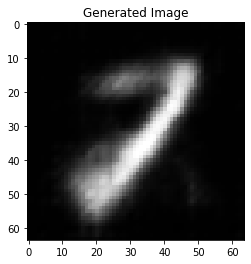

Epoch 52/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.33it/s]


Epoch [52/500], Loss: 82406.4297 (total loss), 78816.7344 (bce), 3589.6958 (kld)
Mu range: -1.6233434677124023 ~ 2.06434965133667, Logvar range: -6.523658752441406 ~ -1.133692741394043
tensor(8)


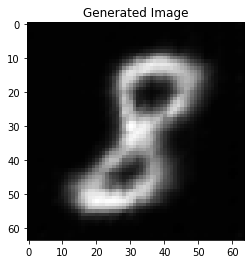

Epoch 53/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.57it/s]


Epoch [53/500], Loss: 85636.1875 (total loss), 82440.6719 (bce), 3195.5144 (kld)
Mu range: -1.551095724105835 ~ 1.456191062927246, Logvar range: -6.926006317138672 ~ -0.8314586877822876
tensor(1)


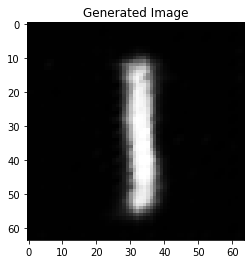

Epoch 54/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.28it/s]


Epoch [54/500], Loss: 85224.6016 (total loss), 82038.9766 (bce), 3185.6245 (kld)
Mu range: -0.7372397184371948 ~ 1.0293740034103394, Logvar range: -3.2563858032226562 ~ -0.9739940762519836
tensor(7)


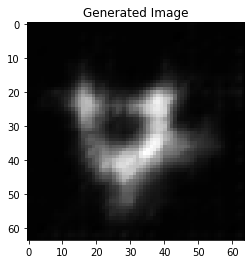

Epoch 55/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.13it/s]

Epoch [55/500], Loss: 83834.4219 (total loss), 80445.8594 (bce), 3388.5654 (kld)
Mu range: -1.1178970336914062 ~ 4.235932350158691, Logvar range: -7.382185459136963 ~ -0.9821081757545471
tensor(2)


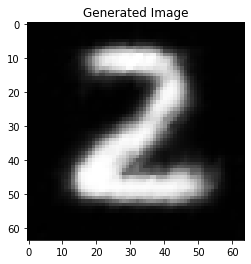

Epoch 56/500: 100%|███████████████████████████| 118/118 [00:10<00:00, 11.02it/s]

Epoch [56/500], Loss: 85864.0469 (total loss), 82610.3359 (bce), 3253.7090 (kld)
Mu range: -1.8656312227249146 ~ 4.088515758514404, Logvar range: -6.63494873046875 ~ -1.5452401638031006
tensor(0)


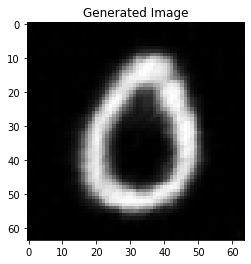

Epoch 57/500: 100%|███████████████████████████| 118/118 [00:10<00:00, 10.73it/s]


Epoch [57/500], Loss: 83261.7109 (total loss), 79860.7266 (bce), 3400.9834 (kld)
Mu range: -2.6006476879119873 ~ 1.3322325944900513, Logvar range: -5.728793621063232 ~ -1.3990744352340698
tensor(4)


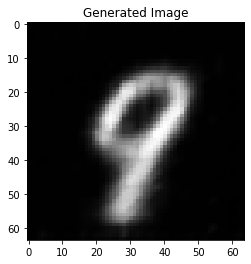

Epoch 58/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.54it/s]

Epoch [58/500], Loss: 83196.8359 (total loss), 79875.3281 (bce), 3321.5059 (kld)
Mu range: -1.8713762760162354 ~ 2.0514838695526123, Logvar range: -4.940866470336914 ~ -1.3752415180206299
tensor(4)


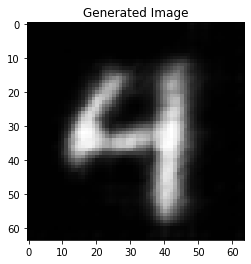

Epoch 59/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.31it/s]


Epoch [59/500], Loss: 81016.2734 (total loss), 77501.8281 (bce), 3514.4436 (kld)
Mu range: -1.5444800853729248 ~ 1.035625696182251, Logvar range: -6.148929595947266 ~ -1.4568384885787964
tensor(9)


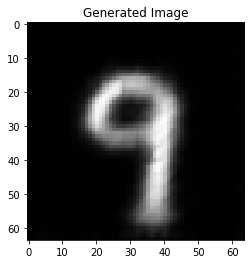

Epoch 60/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.52it/s]


Epoch [60/500], Loss: 80803.2031 (total loss), 77426.8828 (bce), 3376.3164 (kld)
Mu range: -1.0678107738494873 ~ 2.3897454738616943, Logvar range: -5.228254795074463 ~ -0.9978482127189636
tensor(3)


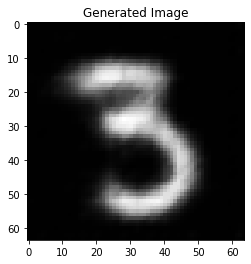

Epoch 61/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.53it/s]


Epoch [61/500], Loss: 81376.7109 (total loss), 77897.2344 (bce), 3479.4775 (kld)
Mu range: -1.080694556236267 ~ 2.80503249168396, Logvar range: -5.605834007263184 ~ -0.8889259099960327
tensor(6)


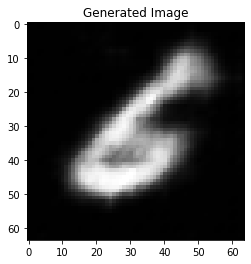

Epoch 62/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.02it/s]

Epoch [62/500], Loss: 80647.8906 (total loss), 77347.1875 (bce), 3300.7046 (kld)
Mu range: -1.5980913639068604 ~ 2.240248203277588, Logvar range: -3.9578967094421387 ~ -0.8547711372375488
tensor(3)


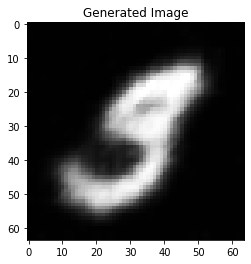

Epoch 63/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.57it/s]


Epoch [63/500], Loss: 81223.9922 (total loss), 77820.7734 (bce), 3403.2178 (kld)
Mu range: -0.940368115901947 ~ 0.22733914852142334, Logvar range: -3.412264585494995 ~ -1.1907789707183838
tensor(4)


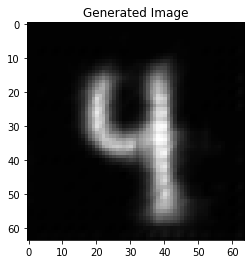

Epoch 64/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.51it/s]


Epoch [64/500], Loss: 76515.6719 (total loss), 73279.7578 (bce), 3235.9111 (kld)
Mu range: -3.216728925704956 ~ 3.9555485248565674, Logvar range: -8.008415222167969 ~ -0.9143503904342651
tensor(0)


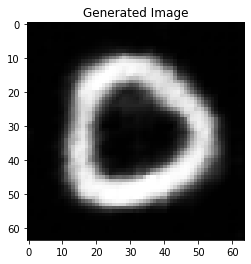

Epoch 65/500: 100%|███████████████████████████| 118/118 [00:10<00:00, 10.82it/s]


Epoch [65/500], Loss: 80153.6328 (total loss), 76872.7656 (bce), 3280.8643 (kld)
Mu range: -0.7926334142684937 ~ 3.1573357582092285, Logvar range: -5.272955417633057 ~ -0.8816783428192139
tensor(3)


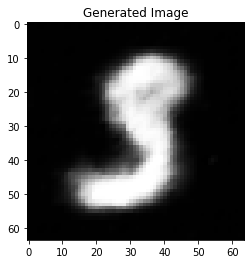

Epoch 66/500: 100%|███████████████████████████| 118/118 [00:12<00:00,  9.81it/s]


Epoch [66/500], Loss: 80167.5469 (total loss), 76896.1875 (bce), 3271.3582 (kld)
Mu range: -3.188769817352295 ~ 4.456940174102783, Logvar range: -7.5934271812438965 ~ -1.1230225563049316
tensor(2)


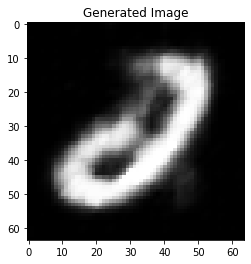

Epoch 67/500: 100%|███████████████████████████| 118/118 [00:12<00:00,  9.23it/s]


Epoch [67/500], Loss: 81386.6797 (total loss), 77928.7109 (bce), 3457.9709 (kld)
Mu range: -1.1176819801330566 ~ 1.440961241722107, Logvar range: -5.135862827301025 ~ -1.3809027671813965
tensor(9)


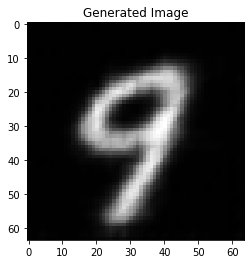

Epoch 68/500: 100%|███████████████████████████| 118/118 [00:11<00:00,  9.93it/s]


Epoch [68/500], Loss: 78835.1172 (total loss), 75423.0469 (bce), 3412.0671 (kld)
Mu range: -0.8821380138397217 ~ 1.0207103490829468, Logvar range: -4.7734527587890625 ~ -1.0942007303237915
tensor(3)


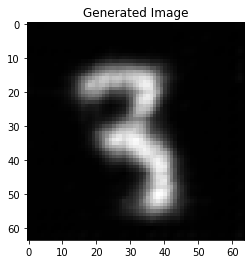

Epoch 69/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.05it/s]


Epoch [69/500], Loss: 80074.3516 (total loss), 76773.7422 (bce), 3300.6089 (kld)
Mu range: -1.2999162673950195 ~ 1.1225876808166504, Logvar range: -4.628556251525879 ~ -1.1611812114715576
tensor(8)


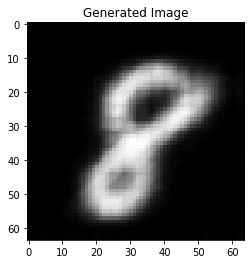

Epoch 70/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.48it/s]


Epoch [70/500], Loss: 79598.0234 (total loss), 76277.6562 (bce), 3320.3679 (kld)
Mu range: -1.4994674921035767 ~ 2.122023582458496, Logvar range: -5.825847625732422 ~ -1.4735097885131836
tensor(4)


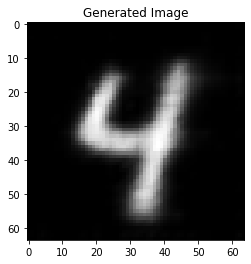

Epoch 71/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.19it/s]


Epoch [71/500], Loss: 79031.9766 (total loss), 75716.9453 (bce), 3315.0300 (kld)
Mu range: -0.6708321571350098 ~ 0.9286144375801086, Logvar range: -3.6693317890167236 ~ -1.0560487508773804
tensor(8)


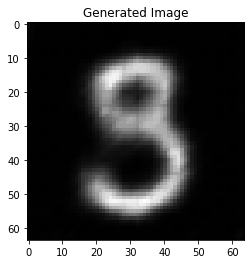

Epoch 72/500: 100%|███████████████████████████| 118/118 [00:10<00:00, 10.76it/s]


Epoch [72/500], Loss: 79511.4141 (total loss), 76266.0469 (bce), 3245.3669 (kld)
Mu range: -1.5250723361968994 ~ 0.7721483111381531, Logvar range: -4.760993003845215 ~ -0.9365300536155701
tensor(7)


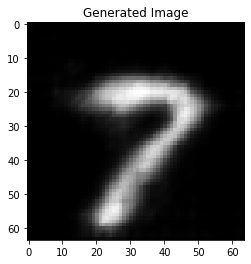

Epoch 73/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.66it/s]


Epoch [73/500], Loss: 77165.0547 (total loss), 73889.9375 (bce), 3275.1165 (kld)
Mu range: -1.9604742527008057 ~ 2.363429546356201, Logvar range: -5.837313652038574 ~ -1.2497526407241821
tensor(8)


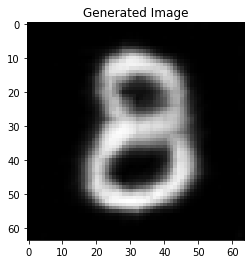

Epoch 74/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.39it/s]

Epoch [74/500], Loss: 77948.2031 (total loss), 74837.1875 (bce), 3111.0154 (kld)
Mu range: -1.4429717063903809 ~ 1.7181578874588013, Logvar range: -5.2556562423706055 ~ -0.8467550277709961
tensor(6)


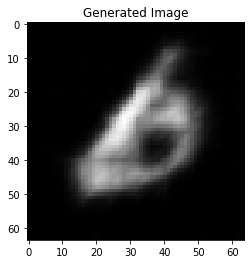

Epoch 75/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.51it/s]


Epoch [75/500], Loss: 77346.3359 (total loss), 74042.3281 (bce), 3304.0068 (kld)
Mu range: -1.5612430572509766 ~ 1.5350795984268188, Logvar range: -4.968099594116211 ~ -1.2347831726074219
tensor(4)


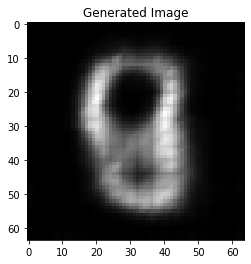

Epoch 76/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.67it/s]

Epoch [76/500], Loss: 74802.2266 (total loss), 71522.5234 (bce), 3279.7041 (kld)
Mu range: -1.0312515497207642 ~ 0.6069869995117188, Logvar range: -4.032597541809082 ~ -1.0633447170257568
tensor(9)


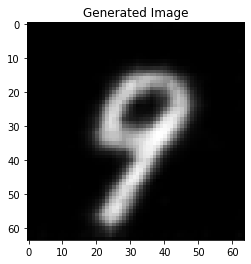

Epoch 77/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.27it/s]

Epoch [77/500], Loss: 76959.9219 (total loss), 73791.1719 (bce), 3168.7490 (kld)
Mu range: -0.805635392665863 ~ 1.030780553817749, Logvar range: -4.229259014129639 ~ -1.0534613132476807
tensor(2)


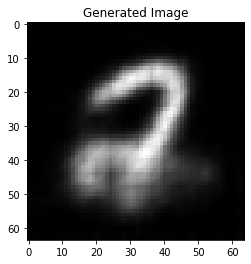

Epoch 78/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.42it/s]


Epoch [78/500], Loss: 81279.3281 (total loss), 78079.6875 (bce), 3199.6406 (kld)
Mu range: -1.176234483718872 ~ 0.7400791049003601, Logvar range: -3.6669201850891113 ~ -1.0208258628845215
tensor(8)


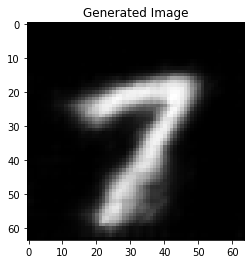

Epoch 79/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.21it/s]

Epoch [79/500], Loss: 75033.6406 (total loss), 71755.9922 (bce), 3277.6450 (kld)
Mu range: -1.3605846166610718 ~ 1.6852346658706665, Logvar range: -5.143006324768066 ~ -0.5338332056999207
tensor(6)


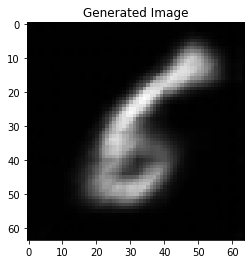

Epoch 80/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.46it/s]


Epoch [80/500], Loss: 76127.5391 (total loss), 72876.9688 (bce), 3250.5674 (kld)
Mu range: -0.8211855888366699 ~ 1.4166240692138672, Logvar range: -3.8126354217529297 ~ -1.1129651069641113
tensor(9)


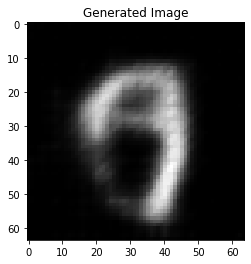

Epoch 81/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.38it/s]

Epoch [81/500], Loss: 78088.6016 (total loss), 74715.9609 (bce), 3372.6375 (kld)
Mu range: -1.222114086151123 ~ 1.3836089372634888, Logvar range: -4.659881114959717 ~ -0.8813518285751343
tensor(1)


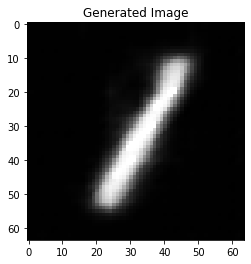

Epoch 82/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.59it/s]

Epoch [82/500], Loss: 75366.9062 (total loss), 72163.7422 (bce), 3203.1611 (kld)
Mu range: -2.2519900798797607 ~ 2.0932915210723877, Logvar range: -6.036497592926025 ~ -0.8362366557121277
tensor(5)


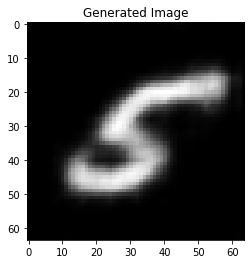

Epoch 83/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.59it/s]

Epoch [83/500], Loss: 75565.9688 (total loss), 72393.0156 (bce), 3172.9546 (kld)
Mu range: -1.5329025983810425 ~ 1.65990149974823, Logvar range: -4.782968521118164 ~ -1.0465508699417114
tensor(8)


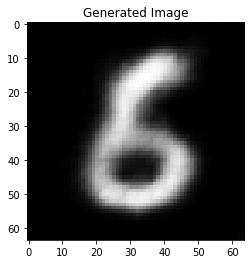

Epoch 84/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.26it/s]

Epoch [84/500], Loss: 74187.0859 (total loss), 70953.4297 (bce), 3233.6570 (kld)
Mu range: -5.5381669998168945 ~ 4.734415054321289, Logvar range: -6.861788749694824 ~ -1.227959156036377
tensor(0)


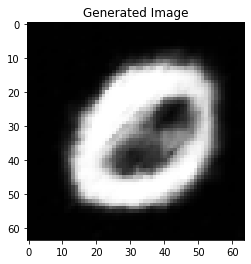

Epoch 85/500: 100%|███████████████████████████| 118/118 [00:10<00:00, 10.98it/s]


Epoch [85/500], Loss: 74782.3281 (total loss), 71391.6719 (bce), 3390.6538 (kld)
Mu range: -0.7809755206108093 ~ 1.913317084312439, Logvar range: -4.097355842590332 ~ -0.7089986801147461
tensor(1)


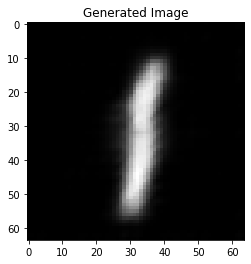

Epoch 86/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.33it/s]


Epoch [86/500], Loss: 75420.9922 (total loss), 72115.3359 (bce), 3305.6526 (kld)
Mu range: -0.9240134358406067 ~ 0.8492920994758606, Logvar range: -4.792769432067871 ~ -1.0801366567611694
tensor(8)


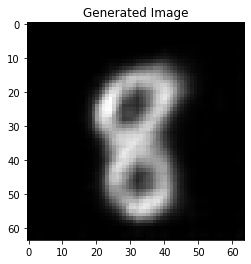

Epoch 87/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.68it/s]

Epoch [87/500], Loss: 76746.6016 (total loss), 73496.3594 (bce), 3250.2393 (kld)
Mu range: -4.204966068267822 ~ 4.121086597442627, Logvar range: -6.083179473876953 ~ -0.45439934730529785
tensor(0)


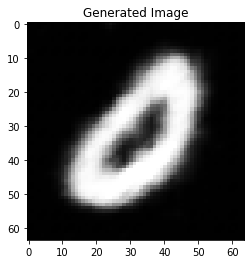

Epoch 88/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.62it/s]

Epoch [88/500], Loss: 74364.7188 (total loss), 70930.5000 (bce), 3434.2192 (kld)
Mu range: -1.9462552070617676 ~ 1.0020241737365723, Logvar range: -4.796424865722656 ~ -0.9178658723831177
tensor(5)


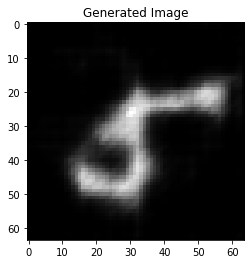

Epoch 89/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.71it/s]


Epoch [89/500], Loss: 74158.9688 (total loss), 70909.4375 (bce), 3249.5308 (kld)
Mu range: -0.9795201420783997 ~ 1.2156403064727783, Logvar range: -4.471920013427734 ~ -1.0360690355300903
tensor(3)


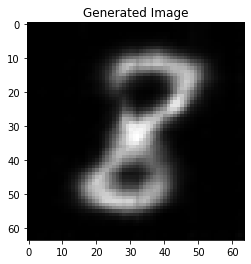

Epoch 90/500: 100%|███████████████████████████| 118/118 [00:10<00:00, 11.64it/s]


Epoch [90/500], Loss: 73862.0859 (total loss), 70621.1406 (bce), 3240.9421 (kld)
Mu range: -1.2341946363449097 ~ 2.179966449737549, Logvar range: -4.566414833068848 ~ -1.0468131303787231
tensor(5)


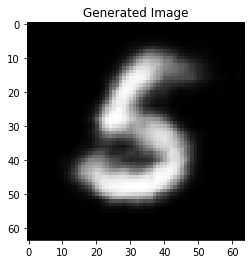

Epoch 91/500: 100%|███████████████████████████| 118/118 [00:10<00:00, 11.23it/s]

Epoch [91/500], Loss: 77710.1094 (total loss), 74301.5625 (bce), 3408.5471 (kld)
Mu range: -1.5975674390792847 ~ 1.5789543390274048, Logvar range: -6.488787651062012 ~ -1.2697131633758545
tensor(6)


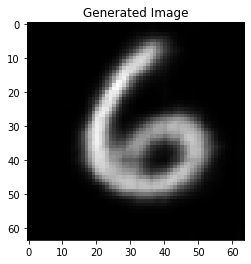

Epoch 92/500: 100%|███████████████████████████| 118/118 [00:10<00:00, 11.32it/s]


Epoch [92/500], Loss: 71162.3828 (total loss), 67704.1016 (bce), 3458.2810 (kld)
Mu range: -3.826204538345337 ~ 3.3097681999206543, Logvar range: -6.804011344909668 ~ -0.8291650414466858
tensor(5)


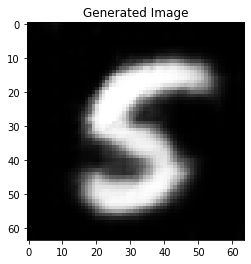

Epoch 93/500: 100%|███████████████████████████| 118/118 [00:10<00:00, 11.05it/s]


Epoch [93/500], Loss: 71747.2422 (total loss), 68442.9453 (bce), 3304.2954 (kld)
Mu range: -1.6677742004394531 ~ 1.4137386083602905, Logvar range: -5.4393486976623535 ~ -0.8904128670692444
tensor(1)


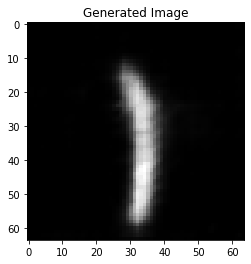

Epoch 94/500: 100%|███████████████████████████| 118/118 [00:10<00:00, 10.91it/s]


Epoch [94/500], Loss: 74878.3047 (total loss), 71497.5000 (bce), 3380.8052 (kld)
Mu range: -4.127185344696045 ~ 2.8065028190612793, Logvar range: -5.485198974609375 ~ -0.9414598345756531
tensor(9)


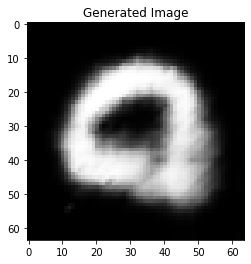

Epoch 95/500: 100%|███████████████████████████| 118/118 [00:10<00:00, 11.33it/s]

Epoch [95/500], Loss: 72124.3828 (total loss), 68777.8594 (bce), 3346.5232 (kld)
Mu range: -1.5033717155456543 ~ 0.7222098112106323, Logvar range: -4.289615631103516 ~ -1.159896731376648
tensor(5)


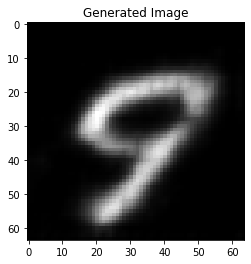

Epoch 96/500: 100%|███████████████████████████| 118/118 [00:10<00:00, 10.90it/s]


Epoch [96/500], Loss: 73478.7109 (total loss), 70150.7578 (bce), 3327.9504 (kld)
Mu range: -2.370997428894043 ~ 2.779799699783325, Logvar range: -6.126681327819824 ~ -1.259639859199524
tensor(4)


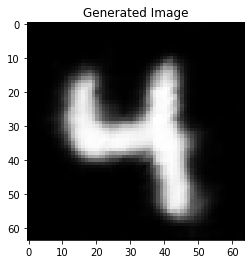

Epoch 97/500: 100%|███████████████████████████| 118/118 [00:10<00:00, 11.00it/s]


Epoch [97/500], Loss: 74016.0391 (total loss), 70649.4688 (bce), 3366.5732 (kld)
Mu range: -1.2345384359359741 ~ 2.056899070739746, Logvar range: -5.401235103607178 ~ -0.5953190326690674
tensor(3)


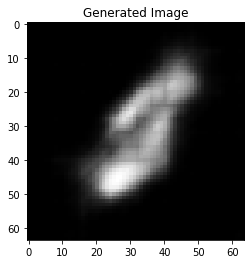

Epoch 98/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.13it/s]

Epoch [98/500], Loss: 70069.1406 (total loss), 66645.1406 (bce), 3424.0000 (kld)
Mu range: -1.4618122577667236 ~ 1.4070894718170166, Logvar range: -4.721736907958984 ~ -1.0081992149353027
tensor(4)


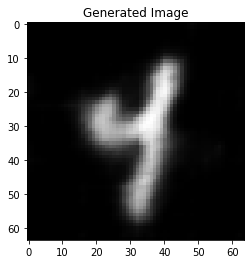

Epoch 99/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.01it/s]


Epoch [99/500], Loss: 69437.2031 (total loss), 66097.0000 (bce), 3340.2002 (kld)
Mu range: -1.2637351751327515 ~ 2.05629825592041, Logvar range: -5.490972518920898 ~ -0.8773568868637085
tensor(2)


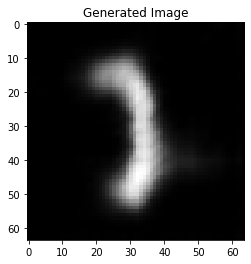

Epoch 100/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.08it/s]


Epoch [100/500], Loss: 71941.8906 (total loss), 68612.4922 (bce), 3329.3970 (kld)
Mu range: -4.295368194580078 ~ 2.8513360023498535, Logvar range: -8.60070514678955 ~ -1.4385099411010742
tensor(5)


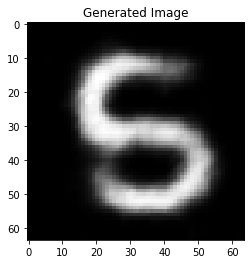

Epoch 101/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.10it/s]


Epoch [101/500], Loss: 72590.1641 (total loss), 69321.2812 (bce), 3268.8811 (kld)
Mu range: -2.0697708129882812 ~ 2.8417608737945557, Logvar range: -7.33770227432251 ~ -0.7974035739898682
tensor(5)


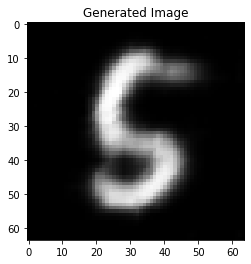

Epoch 102/500: 100%|██████████████████████████| 118/118 [00:11<00:00,  9.90it/s]


Epoch [102/500], Loss: 72077.8438 (total loss), 68806.4844 (bce), 3271.3618 (kld)
Mu range: -1.1263129711151123 ~ 1.880593180656433, Logvar range: -5.7442216873168945 ~ -0.994269073009491
tensor(9)


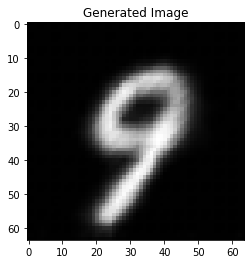

Epoch 103/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.72it/s]


Epoch [103/500], Loss: 72303.0312 (total loss), 69058.5625 (bce), 3244.4712 (kld)
Mu range: -1.4489623308181763 ~ 3.160494089126587, Logvar range: -7.280729293823242 ~ -0.9180718660354614
tensor(2)


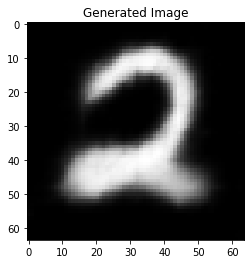

Epoch 104/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.01it/s]


Epoch [104/500], Loss: 71268.5781 (total loss), 67943.4531 (bce), 3325.1277 (kld)
Mu range: -0.9529074430465698 ~ 2.362196683883667, Logvar range: -5.91945219039917 ~ -0.41250288486480713
tensor(1)


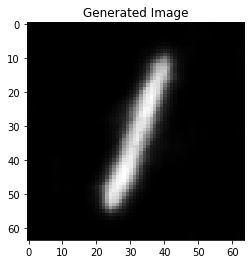

Epoch 105/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.38it/s]


Epoch [105/500], Loss: 70188.8984 (total loss), 66913.2344 (bce), 3275.6616 (kld)
Mu range: -1.6601176261901855 ~ 1.3620353937149048, Logvar range: -4.7341413497924805 ~ -1.1010680198669434
tensor(3)


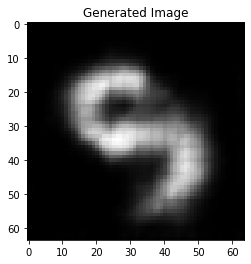

Epoch 106/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.04it/s]


Epoch [106/500], Loss: 71047.3828 (total loss), 67796.1250 (bce), 3251.2551 (kld)
Mu range: -1.2580938339233398 ~ 1.5688512325286865, Logvar range: -5.330402374267578 ~ -0.8321212530136108
tensor(3)


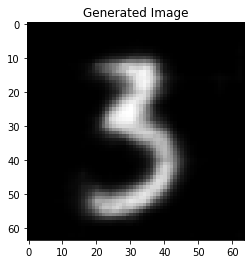

Epoch 107/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.40it/s]


Epoch [107/500], Loss: 71086.7891 (total loss), 67780.1250 (bce), 3306.6621 (kld)
Mu range: -1.9411802291870117 ~ 1.6357009410858154, Logvar range: -6.093962669372559 ~ -0.9122520089149475
tensor(8)


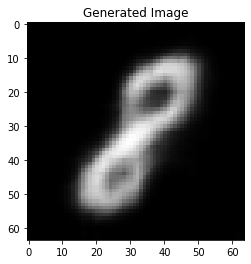

Epoch 108/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.37it/s]


Epoch [108/500], Loss: 70582.5078 (total loss), 67352.7734 (bce), 3229.7327 (kld)
Mu range: -1.4344408512115479 ~ 2.1885719299316406, Logvar range: -5.495345592498779 ~ -1.389588713645935
tensor(5)


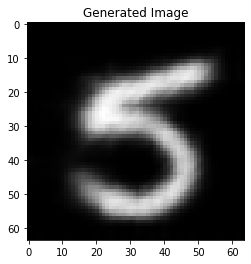

Epoch 109/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.33it/s]


Epoch [109/500], Loss: 71394.5547 (total loss), 68113.5781 (bce), 3280.9771 (kld)
Mu range: -0.9851663112640381 ~ 1.3356291055679321, Logvar range: -5.359726905822754 ~ -0.9499987363815308
tensor(7)


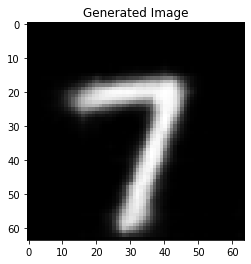

Epoch 110/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.58it/s]


Epoch [110/500], Loss: 71082.5312 (total loss), 67858.1719 (bce), 3224.3625 (kld)
Mu range: -1.873797059059143 ~ 1.3450387716293335, Logvar range: -5.875901222229004 ~ -1.081610083580017
tensor(4)


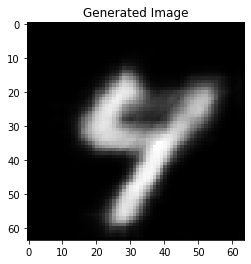

Epoch 111/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.44it/s]


Epoch [111/500], Loss: 71335.5547 (total loss), 68185.7031 (bce), 3149.8547 (kld)
Mu range: -1.1005971431732178 ~ 1.2882261276245117, Logvar range: -5.330802917480469 ~ -1.1027891635894775
tensor(8)


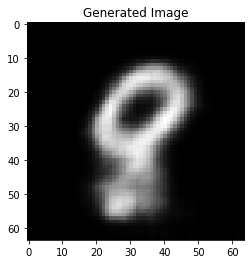

Epoch 112/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.87it/s]


Epoch [112/500], Loss: 70900.6094 (total loss), 67502.2969 (bce), 3398.3110 (kld)
Mu range: -1.1162889003753662 ~ 1.2906038761138916, Logvar range: -4.706210136413574 ~ -1.0770347118377686
tensor(9)


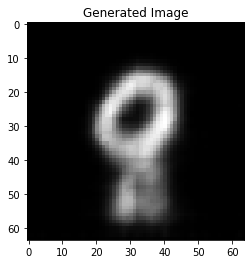

Epoch 113/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.63it/s]


Epoch [113/500], Loss: 71717.0312 (total loss), 68274.3750 (bce), 3442.6602 (kld)
Mu range: -0.9269825220108032 ~ 1.836058259010315, Logvar range: -6.612829208374023 ~ -0.2908886671066284
tensor(1)


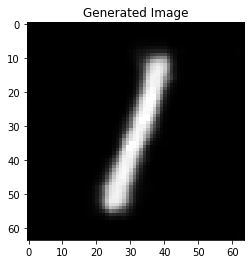

Epoch 114/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.14it/s]


Epoch [114/500], Loss: 71908.5312 (total loss), 68658.7109 (bce), 3249.8242 (kld)
Mu range: -0.9297871589660645 ~ 1.4578098058700562, Logvar range: -5.036441802978516 ~ -0.9030584096908569
tensor(8)


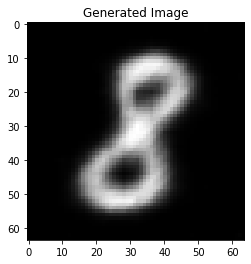

Epoch 115/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.33it/s]


Epoch [115/500], Loss: 67731.2422 (total loss), 64360.7383 (bce), 3370.5042 (kld)
Mu range: -1.6193854808807373 ~ 1.2849557399749756, Logvar range: -4.73716402053833 ~ -1.0686166286468506
tensor(4)


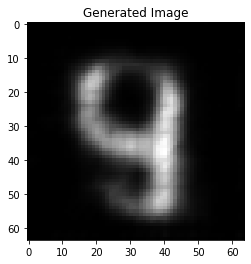

Epoch 116/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.34it/s]


Epoch [116/500], Loss: 68460.8984 (total loss), 65164.2383 (bce), 3296.6589 (kld)
Mu range: -0.9490371346473694 ~ 3.185262441635132, Logvar range: -5.781515598297119 ~ -1.1826521158218384
tensor(3)


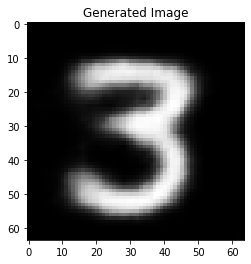

Epoch 117/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.29it/s]

Epoch [117/500], Loss: 68017.8750 (total loss), 64558.2383 (bce), 3459.6353 (kld)
Mu range: -1.6186455488204956 ~ 1.3591625690460205, Logvar range: -4.22092866897583 ~ -1.1555334329605103
tensor(9)


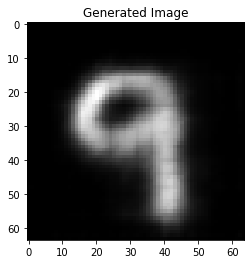

Epoch 118/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.69it/s]

Epoch [118/500], Loss: 75328.5547 (total loss), 72226.7344 (bce), 3101.8208 (kld)
Mu range: -1.3242897987365723 ~ 1.4483351707458496, Logvar range: -5.071564674377441 ~ -0.6774469017982483
tensor(1)


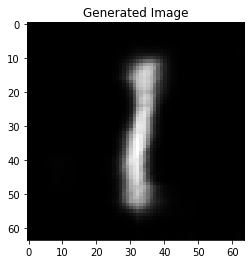

Epoch 119/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.27it/s]


Epoch [119/500], Loss: 66811.1875 (total loss), 63481.1758 (bce), 3330.0078 (kld)
Mu range: -3.4660277366638184 ~ 1.804184913635254, Logvar range: -6.6048173904418945 ~ -1.2490479946136475
tensor(9)


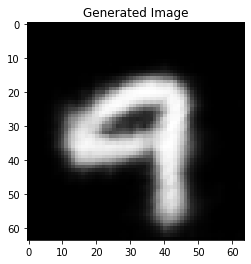

Epoch 120/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.72it/s]


Epoch [120/500], Loss: 70217.9141 (total loss), 66857.2031 (bce), 3360.7129 (kld)
Mu range: -2.0464797019958496 ~ 2.0562002658843994, Logvar range: -4.764235973358154 ~ -0.7837852835655212
tensor(6)


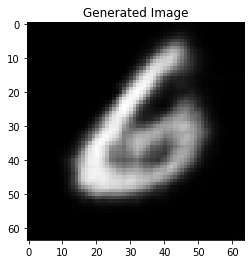

Epoch 121/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.37it/s]

Epoch [121/500], Loss: 67481.5000 (total loss), 63993.3242 (bce), 3488.1780 (kld)
Mu range: -1.1878728866577148 ~ 1.1534451246261597, Logvar range: -4.925848960876465 ~ -0.9248980283737183
tensor(8)


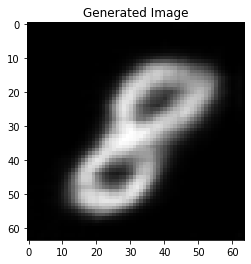

Epoch 122/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.44it/s]


Epoch [122/500], Loss: 72710.2344 (total loss), 69542.8906 (bce), 3167.3438 (kld)
Mu range: -2.450186252593994 ~ 2.9330227375030518, Logvar range: -4.8119707107543945 ~ -0.8432960510253906
tensor(2)


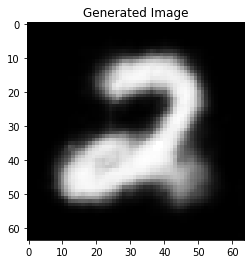

Epoch 123/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.39it/s]


Epoch [123/500], Loss: 68948.5938 (total loss), 65592.1094 (bce), 3356.4819 (kld)
Mu range: -3.1140570640563965 ~ 1.747763752937317, Logvar range: -6.374839782714844 ~ -1.1620898246765137
tensor(0)


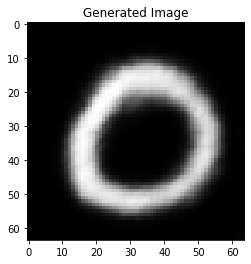

Epoch 124/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.32it/s]


Epoch [124/500], Loss: 69404.5391 (total loss), 66118.0000 (bce), 3286.5359 (kld)
Mu range: -1.048905849456787 ~ 1.0206334590911865, Logvar range: -4.881096363067627 ~ -0.9753004312515259
tensor(4)


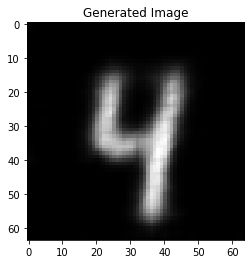

Epoch 125/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.32it/s]


Epoch [125/500], Loss: 70060.7812 (total loss), 66584.0156 (bce), 3476.7661 (kld)
Mu range: -2.3273820877075195 ~ 1.7076985836029053, Logvar range: -5.805296897888184 ~ -1.1098216772079468
tensor(0)


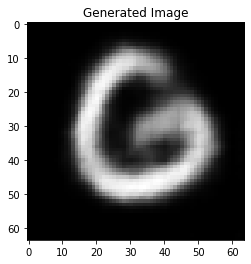

Epoch 126/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.76it/s]


Epoch [126/500], Loss: 70138.3125 (total loss), 66867.9062 (bce), 3270.4067 (kld)
Mu range: -1.4036757946014404 ~ 1.481807827949524, Logvar range: -5.842521667480469 ~ -0.9072710275650024
tensor(8)


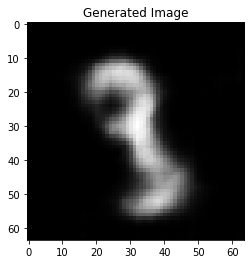

Epoch 127/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.33it/s]


Epoch [127/500], Loss: 68434.7188 (total loss), 65103.8984 (bce), 3330.8167 (kld)
Mu range: -2.9488770961761475 ~ 1.1868624687194824, Logvar range: -5.063924312591553 ~ -0.9142114520072937
tensor(5)


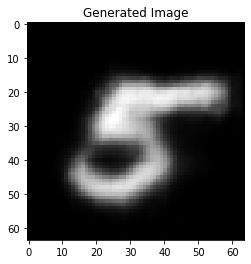

Epoch 128/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.41it/s]


Epoch [128/500], Loss: 68671.8594 (total loss), 65339.1758 (bce), 3332.6799 (kld)
Mu range: -0.772824764251709 ~ 0.9149801135063171, Logvar range: -5.019714832305908 ~ -0.7551025748252869
tensor(1)


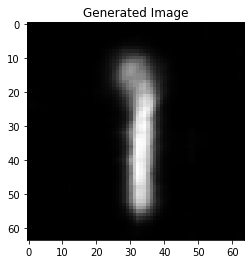

Epoch 129/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.43it/s]


Epoch [129/500], Loss: 71628.5000 (total loss), 68306.1250 (bce), 3322.3782 (kld)
Mu range: -2.998448610305786 ~ 1.9736076593399048, Logvar range: -6.87960958480835 ~ -0.8728373050689697
tensor(7)


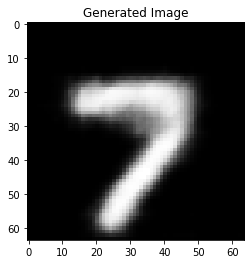

Epoch 130/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.43it/s]


Epoch [130/500], Loss: 69496.9062 (total loss), 66183.7500 (bce), 3313.1560 (kld)
Mu range: -0.9009199142456055 ~ 0.7725611925125122, Logvar range: -4.6403679847717285 ~ -1.0527218580245972
tensor(9)


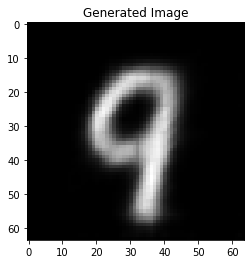

Epoch 131/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.19it/s]

Epoch [131/500], Loss: 67265.5078 (total loss), 63976.2344 (bce), 3289.2710 (kld)
Mu range: -1.1556274890899658 ~ 2.769395112991333, Logvar range: -6.339982032775879 ~ -0.7629969120025635
tensor(8)


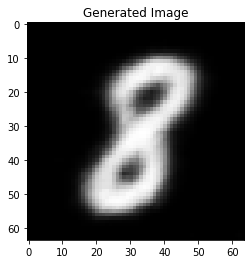

Epoch 132/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.29it/s]


Epoch [132/500], Loss: 67279.7344 (total loss), 63898.2109 (bce), 3381.5229 (kld)
Mu range: -0.2956387400627136 ~ 1.903562307357788, Logvar range: -4.6180338859558105 ~ -0.7507141828536987
tensor(3)


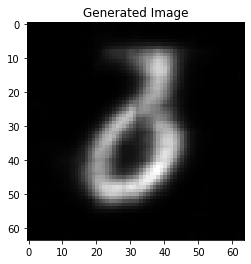

Epoch 133/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.31it/s]

Epoch [133/500], Loss: 67714.5547 (total loss), 64177.5977 (bce), 3536.9546 (kld)
Mu range: -2.6421568393707275 ~ 0.8624337911605835, Logvar range: -6.2807769775390625 ~ -0.9548605680465698
tensor(9)


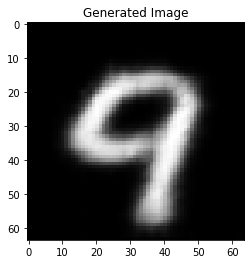

Epoch 134/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.38it/s]


Epoch [134/500], Loss: 68219.9844 (total loss), 65094.8516 (bce), 3125.1289 (kld)
Mu range: -1.443677306175232 ~ 4.274290084838867, Logvar range: -5.965907573699951 ~ -0.9977735280990601
tensor(5)


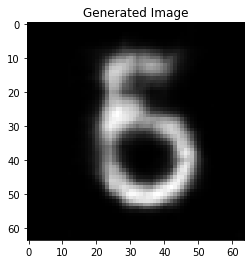

Epoch 135/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.03it/s]


Epoch [135/500], Loss: 65681.2734 (total loss), 62433.2617 (bce), 3248.0137 (kld)
Mu range: -0.9475681781768799 ~ 1.470093011856079, Logvar range: -5.646411895751953 ~ -0.84173983335495
tensor(6)


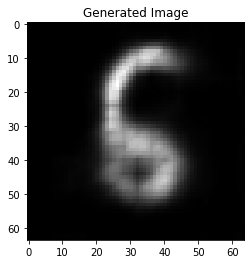

Epoch 136/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.42it/s]


Epoch [136/500], Loss: 67684.3906 (total loss), 64425.0195 (bce), 3259.3750 (kld)
Mu range: -1.1996673345565796 ~ 0.8185518383979797, Logvar range: -4.734438896179199 ~ -0.95782470703125
tensor(6)


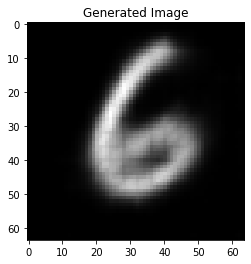

Epoch 137/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.23it/s]

Epoch [137/500], Loss: 67191.7578 (total loss), 63809.3516 (bce), 3382.4026 (kld)
Mu range: -0.5218394994735718 ~ 0.9447195529937744, Logvar range: -4.941641330718994 ~ -0.8378915786743164
tensor(1)


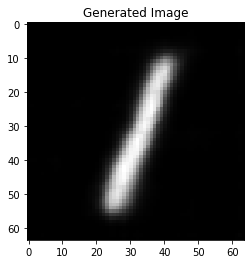

Epoch 138/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.36it/s]


Epoch [138/500], Loss: 67554.3906 (total loss), 64223.0859 (bce), 3331.3052 (kld)
Mu range: -1.824267029762268 ~ 1.8104559183120728, Logvar range: -4.961252689361572 ~ -1.0355890989303589
tensor(4)


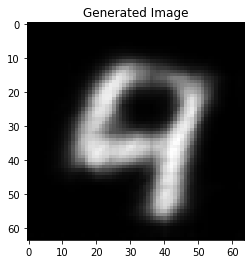

Epoch 139/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.30it/s]

Epoch [139/500], Loss: 65700.3906 (total loss), 62532.3047 (bce), 3168.0898 (kld)
Mu range: -0.6097403168678284 ~ 1.2020976543426514, Logvar range: -5.069248199462891 ~ -0.9243748188018799
tensor(8)


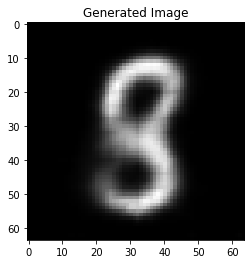

Epoch 140/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.83it/s]


Epoch [140/500], Loss: 66606.9453 (total loss), 63302.4609 (bce), 3304.4836 (kld)
Mu range: -1.5783497095108032 ~ 1.4532470703125, Logvar range: -6.174799919128418 ~ -0.9516171216964722
tensor(4)


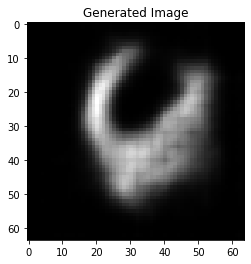

Epoch 141/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.69it/s]


Epoch [141/500], Loss: 67912.4531 (total loss), 64498.4805 (bce), 3413.9688 (kld)
Mu range: -2.288217067718506 ~ 4.0163726806640625, Logvar range: -6.302654266357422 ~ -0.7861419916152954
tensor(0)


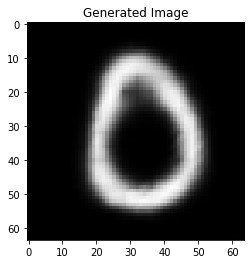

Epoch 142/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.71it/s]


Epoch [142/500], Loss: 65893.6172 (total loss), 62507.1172 (bce), 3386.4966 (kld)
Mu range: -2.2352118492126465 ~ 1.6853325366973877, Logvar range: -4.899783611297607 ~ -0.7375151515007019
tensor(6)


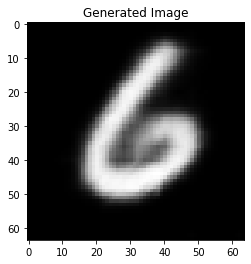

Epoch 143/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.04it/s]


Epoch [143/500], Loss: 69901.0391 (total loss), 66789.2812 (bce), 3111.7554 (kld)
Mu range: -0.8569642305374146 ~ 1.7072468996047974, Logvar range: -5.457204818725586 ~ -0.897623598575592
tensor(8)


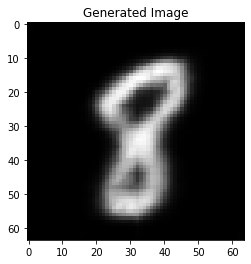

Epoch 144/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.15it/s]


Epoch [144/500], Loss: 68406.1406 (total loss), 65117.4531 (bce), 3288.6885 (kld)
Mu range: -0.962848424911499 ~ 1.893006443977356, Logvar range: -6.116448879241943 ~ -0.7728608250617981
tensor(3)


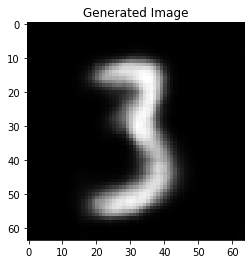

Epoch 145/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.65it/s]


Epoch [145/500], Loss: 66926.8672 (total loss), 63656.2812 (bce), 3270.5894 (kld)
Mu range: -2.1604771614074707 ~ 2.0173704624176025, Logvar range: -6.169240474700928 ~ -0.6918283104896545
tensor(3)


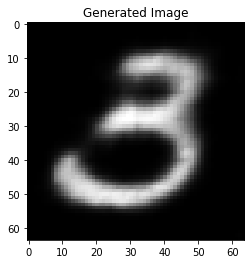

Epoch 146/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.80it/s]


Epoch [146/500], Loss: 67946.1172 (total loss), 64619.9570 (bce), 3326.1567 (kld)
Mu range: -0.5782943964004517 ~ 1.2678940296173096, Logvar range: -4.421200752258301 ~ -0.9811578989028931
tensor(2)


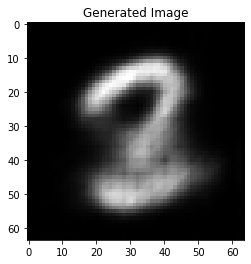

Epoch 147/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.19it/s]


Epoch [147/500], Loss: 66176.5547 (total loss), 62954.8477 (bce), 3221.7092 (kld)
Mu range: -2.266779661178589 ~ 0.9592611193656921, Logvar range: -4.041220188140869 ~ -0.9970448613166809
tensor(4)


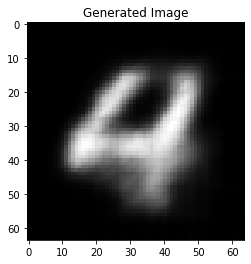

Epoch 148/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.92it/s]


Epoch [148/500], Loss: 66135.6484 (total loss), 62788.0000 (bce), 3347.6484 (kld)
Mu range: -2.478982448577881 ~ 3.6867573261260986, Logvar range: -5.675061225891113 ~ -0.9534978866577148
tensor(3)


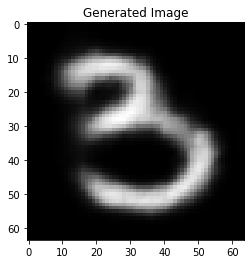

Epoch 149/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.71it/s]


Epoch [149/500], Loss: 66648.2812 (total loss), 63375.6992 (bce), 3272.5825 (kld)
Mu range: -1.8948664665222168 ~ 2.028364658355713, Logvar range: -6.500437259674072 ~ -0.7695512175559998
tensor(7)


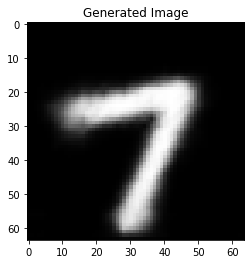

Epoch 150/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.61it/s]


Epoch [150/500], Loss: 67028.4062 (total loss), 63718.9844 (bce), 3309.4189 (kld)
Mu range: -3.236560821533203 ~ 2.9285426139831543, Logvar range: -8.42441463470459 ~ -0.10524129867553711
tensor(4)


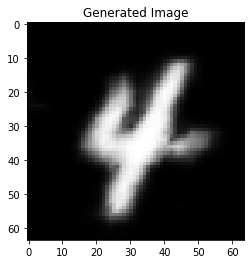

Epoch 151/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.65it/s]


Epoch [151/500], Loss: 69095.0938 (total loss), 65768.6484 (bce), 3326.4421 (kld)
Mu range: -1.7601350545883179 ~ 1.0190335512161255, Logvar range: -5.058003902435303 ~ -0.9531206488609314
tensor(0)


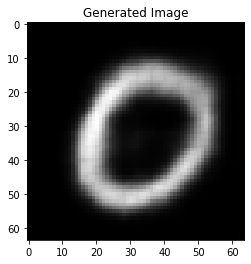

Epoch 152/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.45it/s]


Epoch [152/500], Loss: 65451.8438 (total loss), 61975.3398 (bce), 3476.5020 (kld)
Mu range: -1.437455177307129 ~ 0.918127715587616, Logvar range: -5.512423038482666 ~ -0.8560171127319336
tensor(6)


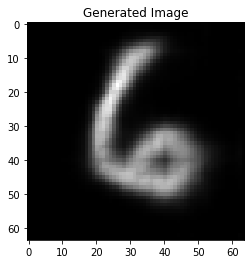

Epoch 153/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.94it/s]


Epoch [153/500], Loss: 66514.1250 (total loss), 63026.3164 (bce), 3487.8091 (kld)
Mu range: -1.3563530445098877 ~ 2.4321796894073486, Logvar range: -6.185903549194336 ~ -0.5923147797584534
tensor(3)


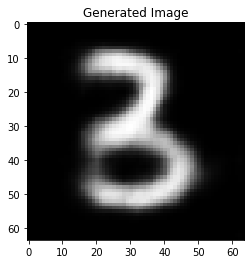

Epoch 154/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.23it/s]


Epoch [154/500], Loss: 67698.2188 (total loss), 64429.0859 (bce), 3269.1328 (kld)
Mu range: -2.015103816986084 ~ 2.8184313774108887, Logvar range: -6.652345657348633 ~ -0.6753510236740112
tensor(3)


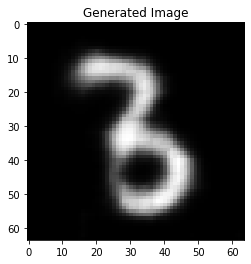

Epoch 155/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.24it/s]


Epoch [155/500], Loss: 69314.6094 (total loss), 65914.3438 (bce), 3400.2686 (kld)
Mu range: -2.605684518814087 ~ 3.7712960243225098, Logvar range: -7.31071662902832 ~ -0.6643939018249512
tensor(0)


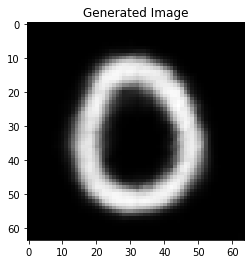

Epoch 156/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.84it/s]

Epoch [156/500], Loss: 62690.7852 (total loss), 59380.8984 (bce), 3309.8850 (kld)
Mu range: -1.2337279319763184 ~ 2.1100785732269287, Logvar range: -6.55355167388916 ~ -0.6960017085075378
tensor(1)


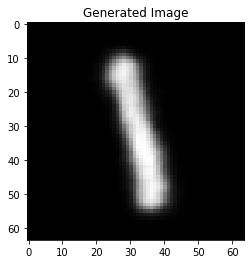

Epoch 157/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.54it/s]


Epoch [157/500], Loss: 64468.8906 (total loss), 61212.4844 (bce), 3256.4055 (kld)
Mu range: -2.167130470275879 ~ 2.955570697784424, Logvar range: -8.34179973602295 ~ 0.029911398887634277
tensor(1)


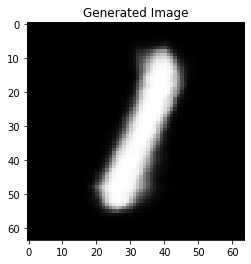

Epoch 158/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.93it/s]


Epoch [158/500], Loss: 64852.9297 (total loss), 61592.5312 (bce), 3260.3982 (kld)
Mu range: -1.735670566558838 ~ 1.6040315628051758, Logvar range: -7.21689510345459 ~ -0.616341233253479
tensor(3)


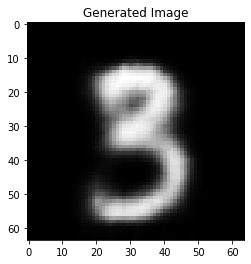

Epoch 159/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.27it/s]


Epoch [159/500], Loss: 65760.8125 (total loss), 62361.9453 (bce), 3398.8682 (kld)
Mu range: -1.2690041065216064 ~ 1.3852163553237915, Logvar range: -6.544401168823242 ~ -0.3890119791030884
tensor(1)


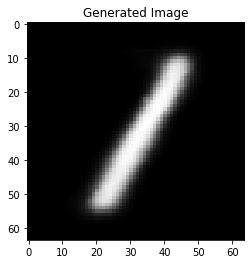

Epoch 160/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.42it/s]

Epoch [160/500], Loss: 65666.1484 (total loss), 62400.4688 (bce), 3265.6824 (kld)
Mu range: -1.4583752155303955 ~ 1.4391626119613647, Logvar range: -5.009573459625244 ~ -0.4608057737350464
tensor(6)


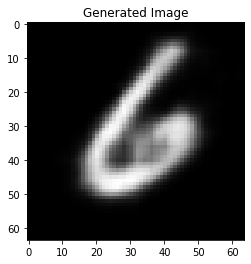

Epoch 161/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.38it/s]


Epoch [161/500], Loss: 66307.0625 (total loss), 62851.3359 (bce), 3455.7305 (kld)
Mu range: -1.4678499698638916 ~ 2.4218850135803223, Logvar range: -6.2313995361328125 ~ -0.6113482117652893
tensor(1)


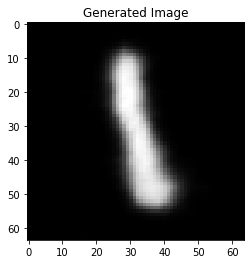

Epoch 162/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.69it/s]


Epoch [162/500], Loss: 65142.4062 (total loss), 61792.6250 (bce), 3349.7817 (kld)
Mu range: -0.4734387695789337 ~ 1.1986658573150635, Logvar range: -4.419857978820801 ~ -0.8472646474838257
tensor(2)


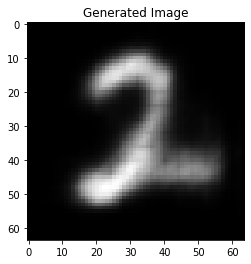

Epoch 163/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.40it/s]

Epoch [163/500], Loss: 66675.0703 (total loss), 63343.1016 (bce), 3331.9683 (kld)
Mu range: -2.605135917663574 ~ 1.7998700141906738, Logvar range: -7.094882965087891 ~ -0.8997576236724854
tensor(0)


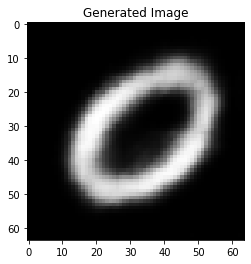

Epoch 164/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.22it/s]


Epoch [164/500], Loss: 66833.5391 (total loss), 63580.9219 (bce), 3252.6169 (kld)
Mu range: -1.0793416500091553 ~ 1.5628314018249512, Logvar range: -6.170906066894531 ~ -0.36985117197036743
tensor(2)


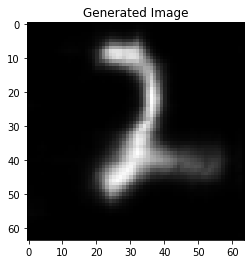

Epoch 165/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.11it/s]

Epoch [165/500], Loss: 69301.6484 (total loss), 65883.4688 (bce), 3418.1772 (kld)
Mu range: -1.2745463848114014 ~ 1.5479276180267334, Logvar range: -5.48981237411499 ~ -0.8979807496070862
tensor(8)


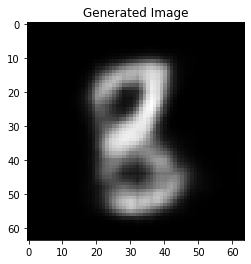

Epoch 166/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.22it/s]


Epoch [166/500], Loss: 65402.6172 (total loss), 61969.3750 (bce), 3433.2422 (kld)
Mu range: -1.0864890813827515 ~ 1.5781257152557373, Logvar range: -6.496039867401123 ~ -0.8193687200546265
tensor(3)


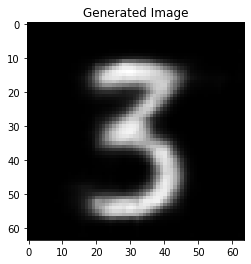

Epoch 167/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.75it/s]


Epoch [167/500], Loss: 66349.3203 (total loss), 62910.9805 (bce), 3438.3364 (kld)
Mu range: -2.2615106105804443 ~ 1.8562406301498413, Logvar range: -5.929496765136719 ~ -0.7429627180099487
tensor(3)


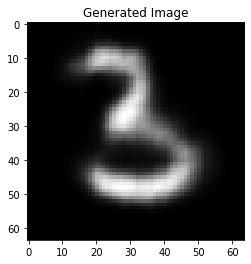

Epoch 168/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.41it/s]

Epoch [168/500], Loss: 67390.8828 (total loss), 64036.2812 (bce), 3354.6001 (kld)
Mu range: -2.1140265464782715 ~ 1.052834391593933, Logvar range: -6.564454078674316 ~ -0.44934868812561035
tensor(7)


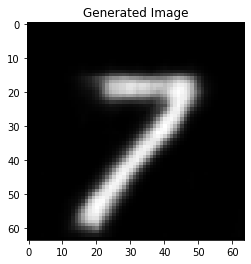

Epoch 169/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.43it/s]


Epoch [169/500], Loss: 68993.6016 (total loss), 65724.0078 (bce), 3269.5957 (kld)
Mu range: -3.4023916721343994 ~ 1.8295637369155884, Logvar range: -6.78366231918335 ~ -0.6853213310241699
tensor(7)


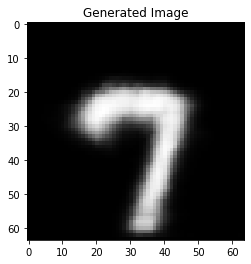

Epoch 170/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.43it/s]


Epoch [170/500], Loss: 66860.7812 (total loss), 63604.5664 (bce), 3256.2148 (kld)
Mu range: -1.408987283706665 ~ 1.9010721445083618, Logvar range: -5.190682888031006 ~ -0.7523871660232544
tensor(6)


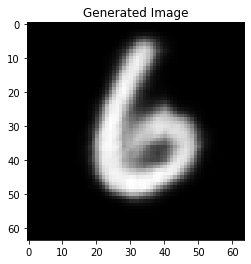

Epoch 171/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.50it/s]


Epoch [171/500], Loss: 67183.8281 (total loss), 63891.9141 (bce), 3291.9146 (kld)
Mu range: -1.1762723922729492 ~ 1.514204502105713, Logvar range: -6.247292995452881 ~ -0.7828896045684814
tensor(6)


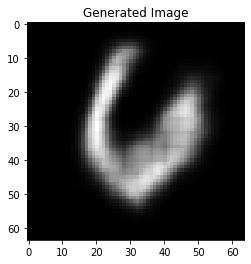

Epoch 172/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.47it/s]


Epoch [172/500], Loss: 64967.3633 (total loss), 61673.8242 (bce), 3293.5386 (kld)
Mu range: -2.014491319656372 ~ 1.3407084941864014, Logvar range: -5.76927375793457 ~ -0.7587387561798096
tensor(5)


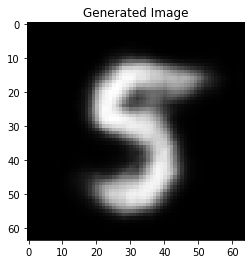

Epoch 173/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.19it/s]


Epoch [173/500], Loss: 67938.2500 (total loss), 64622.3125 (bce), 3315.9380 (kld)
Mu range: -1.5396063327789307 ~ 2.252401351928711, Logvar range: -5.043522834777832 ~ -0.661329984664917
tensor(0)


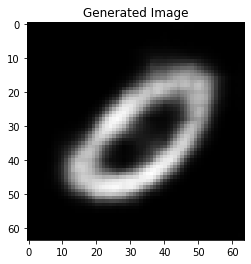

Epoch 174/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.69it/s]


Epoch [174/500], Loss: 66778.1484 (total loss), 63363.1016 (bce), 3415.0459 (kld)
Mu range: -0.9285542368888855 ~ 1.2513446807861328, Logvar range: -6.105243682861328 ~ -0.6602523326873779
tensor(7)


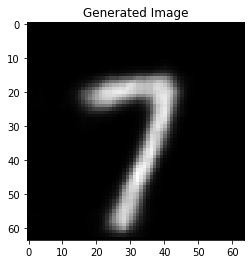

Epoch 175/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.89it/s]


Epoch [175/500], Loss: 69219.2266 (total loss), 65882.3906 (bce), 3336.8374 (kld)
Mu range: -4.551111221313477 ~ 1.22161066532135, Logvar range: -7.4340362548828125 ~ -0.44328540563583374
tensor(9)


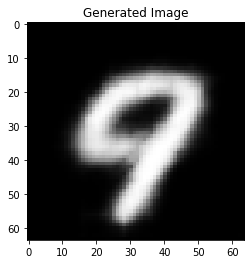

Epoch 176/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.94it/s]


Epoch [176/500], Loss: 66478.3281 (total loss), 63179.6562 (bce), 3298.6682 (kld)
Mu range: -0.7783685922622681 ~ 2.0944461822509766, Logvar range: -6.218380928039551 ~ -0.2725289463996887
tensor(1)


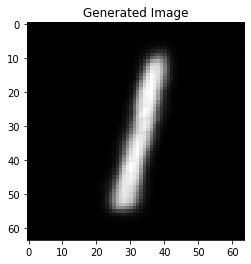

Epoch 177/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.14it/s]

Epoch [177/500], Loss: 66011.3047 (total loss), 62740.3203 (bce), 3270.9878 (kld)
Mu range: -0.5090439319610596 ~ 0.9021499156951904, Logvar range: -5.235395908355713 ~ -0.6975680589675903
tensor(1)


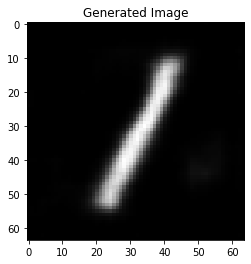

Epoch 178/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.30it/s]

Epoch [178/500], Loss: 68163.6094 (total loss), 64846.6055 (bce), 3317.0078 (kld)
Mu range: -2.002065420150757 ~ 0.8164605498313904, Logvar range: -6.091017723083496 ~ -0.43762439489364624
tensor(4)


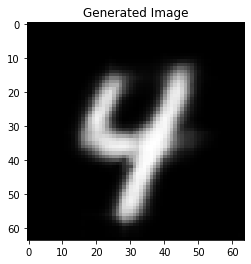

Epoch 179/500: 100%|██████████████████████████| 118/118 [00:11<00:00,  9.89it/s]

Epoch [179/500], Loss: 67932.2266 (total loss), 64590.2266 (bce), 3342.0020 (kld)
Mu range: -1.9565691947937012 ~ 2.320425271987915, Logvar range: -5.391184329986572 ~ -0.8497938513755798
tensor(6)


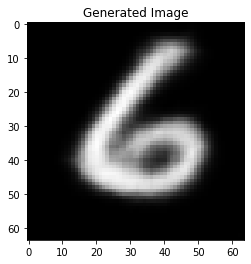

Epoch 180/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.22it/s]


Epoch [180/500], Loss: 66210.6875 (total loss), 62850.6250 (bce), 3360.0645 (kld)
Mu range: -1.0210239887237549 ~ 1.4527796506881714, Logvar range: -5.403770446777344 ~ -0.8648326396942139
tensor(9)


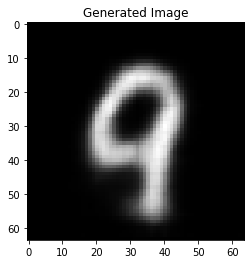

Epoch 181/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.47it/s]


Epoch [181/500], Loss: 63143.6641 (total loss), 59838.9961 (bce), 3304.6687 (kld)
Mu range: -2.1264822483062744 ~ 1.848706603050232, Logvar range: -5.179946422576904 ~ -0.6063205599784851
tensor(2)


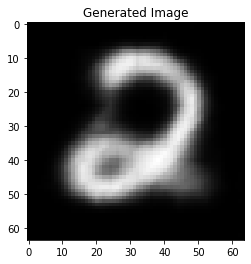

Epoch 182/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.08it/s]

Epoch [182/500], Loss: 68905.0859 (total loss), 65630.9375 (bce), 3274.1460 (kld)
Mu range: -2.263965368270874 ~ 2.8961806297302246, Logvar range: -7.1317138671875 ~ -0.07430100440979004
tensor(0)


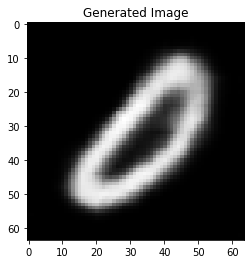

Epoch 183/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.52it/s]


Epoch [183/500], Loss: 65505.1211 (total loss), 62268.9648 (bce), 3236.1553 (kld)
Mu range: -1.1633251905441284 ~ 1.6355284452438354, Logvar range: -5.310994625091553 ~ -0.5688270330429077
tensor(5)


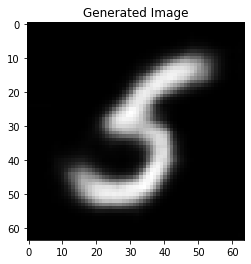

Epoch 184/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.88it/s]


Epoch [184/500], Loss: 64703.4414 (total loss), 61427.8477 (bce), 3275.5935 (kld)
Mu range: -2.3522636890411377 ~ 2.329796314239502, Logvar range: -5.99976110458374 ~ -0.47429561614990234
tensor(2)


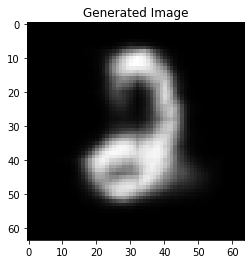

Epoch 185/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.61it/s]


Epoch [185/500], Loss: 67645.6797 (total loss), 64135.6484 (bce), 3510.0317 (kld)
Mu range: -1.7641916275024414 ~ 1.2387773990631104, Logvar range: -5.829250812530518 ~ -0.7010148763656616
tensor(7)


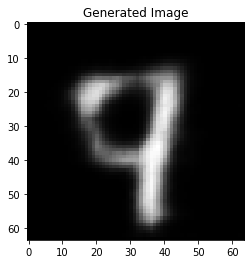

Epoch 186/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.09it/s]


Epoch [186/500], Loss: 67548.7422 (total loss), 64191.3555 (bce), 3357.3882 (kld)
Mu range: -2.022757053375244 ~ 1.6601715087890625, Logvar range: -6.267323017120361 ~ -0.8996296525001526
tensor(8)


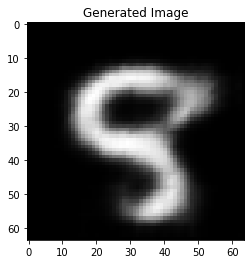

Epoch 187/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.04it/s]


Epoch [187/500], Loss: 68661.7734 (total loss), 65231.6836 (bce), 3430.0874 (kld)
Mu range: -2.1661462783813477 ~ 1.8479485511779785, Logvar range: -6.730344772338867 ~ -0.459452748298645
tensor(8)


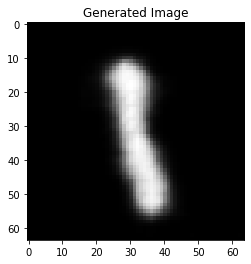

Epoch 188/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.88it/s]


Epoch [188/500], Loss: 66749.3828 (total loss), 63302.5781 (bce), 3446.8057 (kld)
Mu range: -2.2314560413360596 ~ 1.5573862791061401, Logvar range: -6.328417778015137 ~ -0.38816535472869873
tensor(1)


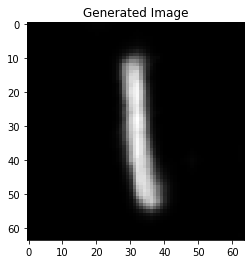

Epoch 189/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.56it/s]


Epoch [189/500], Loss: 65437.4609 (total loss), 62065.1133 (bce), 3372.3459 (kld)
Mu range: -3.5999596118927 ~ 1.7694157361984253, Logvar range: -5.697355270385742 ~ -0.9088336825370789
tensor(0)


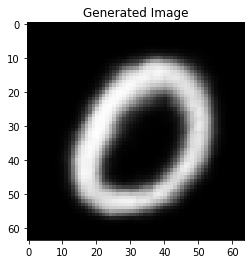

Epoch 190/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.05it/s]


Epoch [190/500], Loss: 66743.5781 (total loss), 63462.2188 (bce), 3281.3633 (kld)
Mu range: -1.4799498319625854 ~ 2.429084062576294, Logvar range: -6.353734016418457 ~ -0.18827354907989502
tensor(2)


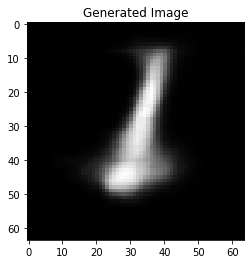

Epoch 191/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.97it/s]


Epoch [191/500], Loss: 64955.2461 (total loss), 61642.1172 (bce), 3313.1272 (kld)
Mu range: -1.3255051374435425 ~ 1.5357272624969482, Logvar range: -5.7900519371032715 ~ -0.8136677145957947
tensor(3)


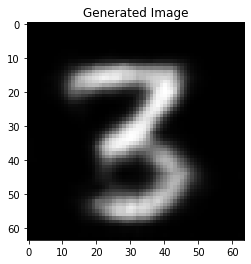

Epoch 192/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.59it/s]


Epoch [192/500], Loss: 66367.3359 (total loss), 62873.0977 (bce), 3494.2397 (kld)
Mu range: -3.047210216522217 ~ 1.5717508792877197, Logvar range: -5.704372406005859 ~ -0.4643566608428955
tensor(5)


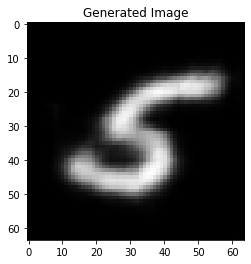

Epoch 193/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.20it/s]


Epoch [193/500], Loss: 65895.6094 (total loss), 62428.4766 (bce), 3467.1367 (kld)
Mu range: -1.6501188278198242 ~ 2.2238452434539795, Logvar range: -6.498998641967773 ~ -0.4377986192703247
tensor(6)


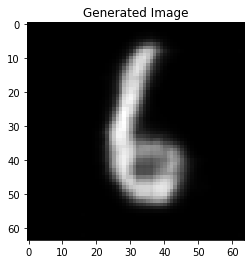

Epoch 194/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.80it/s]


Epoch [194/500], Loss: 64954.7461 (total loss), 61562.9648 (bce), 3391.7812 (kld)
Mu range: -2.067291021347046 ~ 1.5833920240402222, Logvar range: -6.149328231811523 ~ -0.6719872355461121
tensor(4)


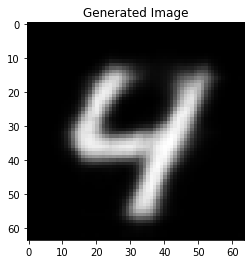

Epoch 195/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.60it/s]


Epoch [195/500], Loss: 65419.6406 (total loss), 62113.8203 (bce), 3305.8210 (kld)
Mu range: -1.96053147315979 ~ 2.41412615776062, Logvar range: -6.491272926330566 ~ -0.683093786239624
tensor(3)


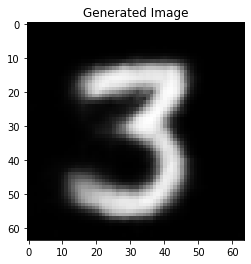

Epoch 196/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.14it/s]


Epoch [196/500], Loss: 63127.0703 (total loss), 59747.3594 (bce), 3379.7104 (kld)
Mu range: -1.1055970191955566 ~ 1.6316509246826172, Logvar range: -5.357600688934326 ~ -0.3791348934173584
tensor(6)


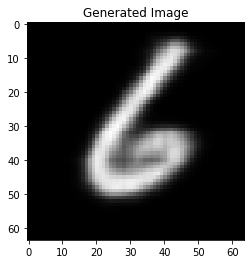

Epoch 197/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.76it/s]


Epoch [197/500], Loss: 66649.0312 (total loss), 63294.2305 (bce), 3354.8025 (kld)
Mu range: -1.4114830493927002 ~ 0.8316408395767212, Logvar range: -6.2143120765686035 ~ -0.5224015712738037
tensor(7)


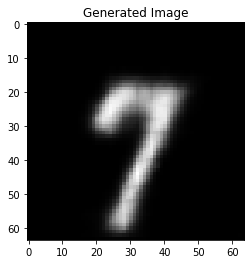

Epoch 198/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.16it/s]


Epoch [198/500], Loss: 66091.5469 (total loss), 62804.3008 (bce), 3287.2461 (kld)
Mu range: -1.5201442241668701 ~ 1.4762080907821655, Logvar range: -6.07765007019043 ~ -0.6971168518066406
tensor(9)


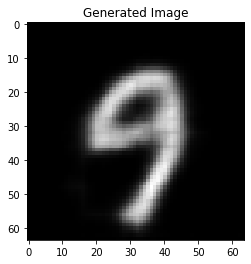

Epoch 199/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.75it/s]


Epoch [199/500], Loss: 64298.0547 (total loss), 60936.7148 (bce), 3361.3408 (kld)
Mu range: -1.3587557077407837 ~ 2.6563196182250977, Logvar range: -7.027762413024902 ~ -0.49388831853866577
tensor(5)


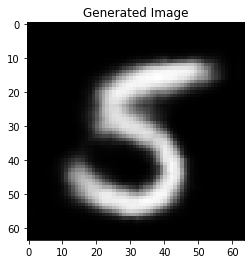

Epoch 200/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.49it/s]

Epoch [200/500], Loss: 68605.1797 (total loss), 65191.7266 (bce), 3413.4497 (kld)
Mu range: -1.5005171298980713 ~ 3.813243865966797, Logvar range: -7.630680084228516 ~ -0.29985952377319336
tensor(3)


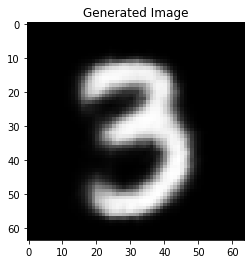

Epoch 201/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.82it/s]


Epoch [201/500], Loss: 65493.4727 (total loss), 62108.3945 (bce), 3385.0791 (kld)
Mu range: -1.5901623964309692 ~ 2.9866392612457275, Logvar range: -6.533319473266602 ~ -0.43954771757125854
tensor(2)


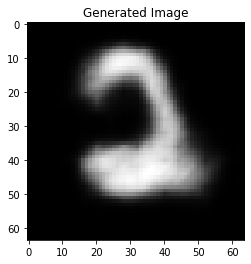

Epoch 202/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.40it/s]


Epoch [202/500], Loss: 67920.0156 (total loss), 64559.8633 (bce), 3360.1538 (kld)
Mu range: -1.127012848854065 ~ 1.6612465381622314, Logvar range: -5.240047454833984 ~ -0.6856338381767273
tensor(6)


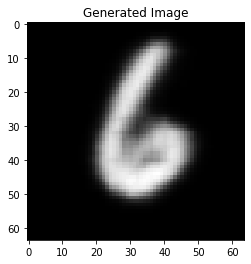

Epoch 203/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.62it/s]


Epoch [203/500], Loss: 67546.3516 (total loss), 64189.3672 (bce), 3356.9854 (kld)
Mu range: -2.1448683738708496 ~ 3.248028516769409, Logvar range: -6.0867085456848145 ~ -0.5659757256507874
tensor(6)


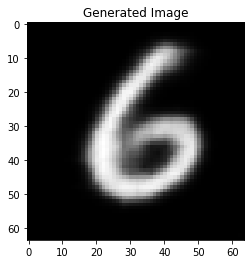

Epoch 204/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.97it/s]


Epoch [204/500], Loss: 66284.4297 (total loss), 63009.0781 (bce), 3275.3516 (kld)
Mu range: -1.0887491703033447 ~ 2.5715863704681396, Logvar range: -5.60539436340332 ~ -0.750904381275177
tensor(3)


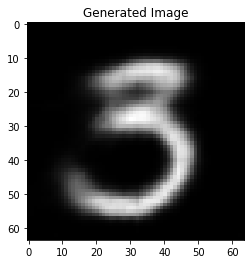

Epoch 205/500: 100%|██████████████████████████| 118/118 [00:09<00:00, 11.86it/s]


Epoch [205/500], Loss: 64286.7812 (total loss), 60796.3203 (bce), 3490.4600 (kld)
Mu range: -2.4456350803375244 ~ 1.9070707559585571, Logvar range: -6.251372814178467 ~ -0.32545095682144165
tensor(1)


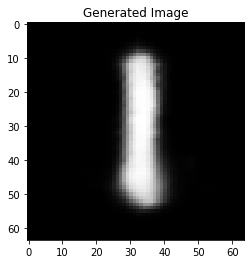

Epoch 206/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.32it/s]


Epoch [206/500], Loss: 67353.6797 (total loss), 64149.6445 (bce), 3204.0386 (kld)
Mu range: -2.8513269424438477 ~ 0.8420819044113159, Logvar range: -6.166224002838135 ~ -0.6540788412094116
tensor(7)


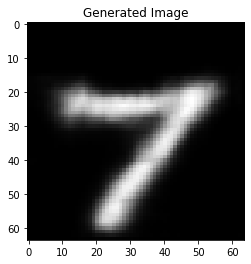

Epoch 207/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.80it/s]


Epoch [207/500], Loss: 63632.3398 (total loss), 60156.3477 (bce), 3475.9922 (kld)
Mu range: -1.257443904876709 ~ 0.5922147631645203, Logvar range: -5.489924430847168 ~ -0.6374358534812927
tensor(9)


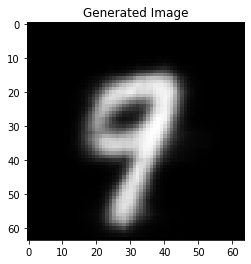

Epoch 208/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.76it/s]


Epoch [208/500], Loss: 64933.0391 (total loss), 61601.9609 (bce), 3331.0779 (kld)
Mu range: -1.5815770626068115 ~ 1.252026915550232, Logvar range: -5.118172645568848 ~ -0.6123117804527283
tensor(5)


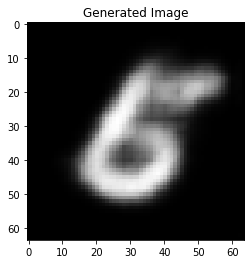

Epoch 209/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.53it/s]

Epoch [209/500], Loss: 65727.8750 (total loss), 62404.2148 (bce), 3323.6619 (kld)
Mu range: -1.8636035919189453 ~ 1.2909049987792969, Logvar range: -5.102099418640137 ~ -0.7840075492858887
tensor(7)


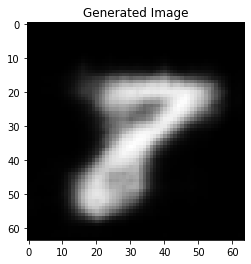

Epoch 210/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.98it/s]


Epoch [210/500], Loss: 64692.3594 (total loss), 61382.2383 (bce), 3310.1230 (kld)
Mu range: -1.2929341793060303 ~ 0.9230903387069702, Logvar range: -5.74038553237915 ~ -0.6210888624191284
tensor(7)


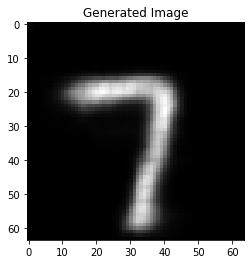

Epoch 211/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.38it/s]


Epoch [211/500], Loss: 67273.5859 (total loss), 63867.2578 (bce), 3406.3271 (kld)
Mu range: -1.5654047727584839 ~ 1.421494483947754, Logvar range: -5.617222785949707 ~ -0.7712138891220093
tensor(5)


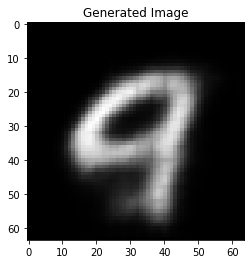

Epoch 212/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.50it/s]


Epoch [212/500], Loss: 64229.8398 (total loss), 60979.6523 (bce), 3250.1870 (kld)
Mu range: -1.020677924156189 ~ 1.057631492614746, Logvar range: -5.235349178314209 ~ -0.5647799968719482
tensor(7)


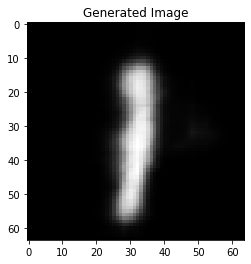

Epoch 213/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.21it/s]

Epoch [213/500], Loss: 65715.4531 (total loss), 62338.3828 (bce), 3377.0671 (kld)
Mu range: -2.0711944103240967 ~ 1.5296958684921265, Logvar range: -5.9147562980651855 ~ -0.48667407035827637
tensor(7)


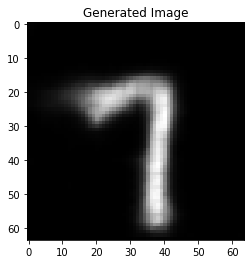

Epoch 214/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.07it/s]


Epoch [214/500], Loss: 67658.7500 (total loss), 64392.0781 (bce), 3266.6714 (kld)
Mu range: -1.7006922960281372 ~ 2.5983309745788574, Logvar range: -6.300083160400391 ~ -0.4196469187736511
tensor(2)


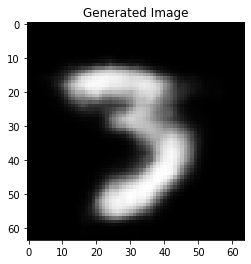

Epoch 215/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.10it/s]

Epoch [215/500], Loss: 63777.9922 (total loss), 60412.1250 (bce), 3365.8691 (kld)
Mu range: -0.7287561893463135 ~ 1.6940478086471558, Logvar range: -5.612958908081055 ~ -0.456906795501709
tensor(1)


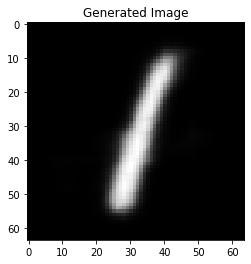

Epoch 216/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.72it/s]


Epoch [216/500], Loss: 64056.5273 (total loss), 60658.7188 (bce), 3397.8086 (kld)
Mu range: -1.3379319906234741 ~ 4.396587371826172, Logvar range: -7.822117328643799 ~ 0.07371771335601807
tensor(2)


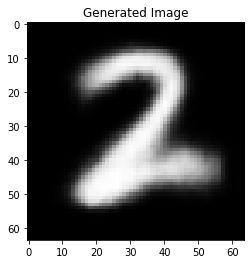

Epoch 217/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.12it/s]


Epoch [217/500], Loss: 66908.2031 (total loss), 63525.6016 (bce), 3382.6040 (kld)
Mu range: -2.5288617610931396 ~ 2.9081196784973145, Logvar range: -7.350538730621338 ~ 0.1049572229385376
tensor(1)


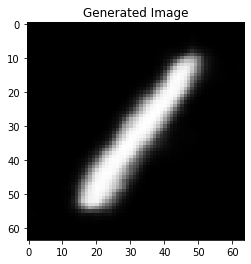

Epoch 218/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.19it/s]


Epoch [218/500], Loss: 69551.5469 (total loss), 66290.3203 (bce), 3261.2300 (kld)
Mu range: -1.64027738571167 ~ 1.4400231838226318, Logvar range: -5.046562671661377 ~ -0.6490196585655212
tensor(0)


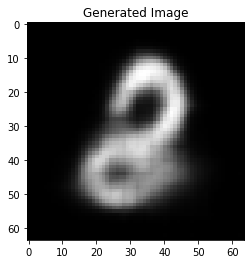

Epoch 219/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.11it/s]

Epoch [219/500], Loss: 62461.0078 (total loss), 58943.5898 (bce), 3517.4189 (kld)
Mu range: -0.924504280090332 ~ 1.353176236152649, Logvar range: -5.076430797576904 ~ -0.6391238570213318
tensor(5)


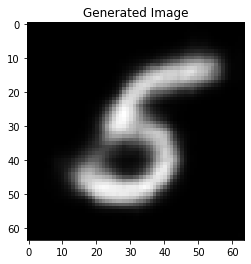

Epoch 220/500: 100%|██████████████████████████| 118/118 [00:11<00:00,  9.94it/s]


Epoch [220/500], Loss: 68702.1797 (total loss), 65258.3828 (bce), 3443.7988 (kld)
Mu range: -1.8577766418457031 ~ 1.2801048755645752, Logvar range: -5.448163032531738 ~ -0.3170943856239319
tensor(4)


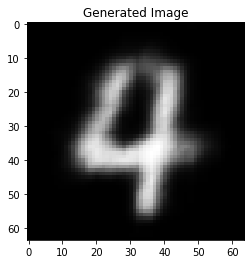

Epoch 221/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.40it/s]


Epoch [221/500], Loss: 66010.6172 (total loss), 62763.2266 (bce), 3247.3940 (kld)
Mu range: -0.43718770146369934 ~ 1.7991371154785156, Logvar range: -5.927529335021973 ~ -0.5256851315498352
tensor(5)


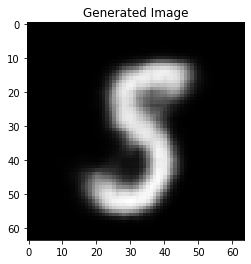

Epoch 222/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.42it/s]


Epoch [222/500], Loss: 65894.5703 (total loss), 62599.3867 (bce), 3295.1865 (kld)
Mu range: -4.988839626312256 ~ 4.264112949371338, Logvar range: -6.676086902618408 ~ 0.1917191743850708
tensor(0)


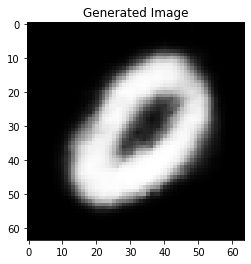

Epoch 223/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.42it/s]

Epoch [223/500], Loss: 64458.2500 (total loss), 61155.3477 (bce), 3302.9023 (kld)
Mu range: -1.135926365852356 ~ 1.3105878829956055, Logvar range: -6.557864665985107 ~ -0.3136488199234009
tensor(1)


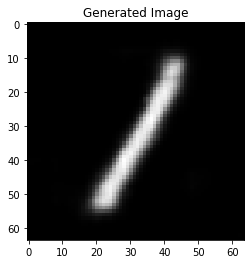

Epoch 224/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.54it/s]

Epoch [224/500], Loss: 67063.9453 (total loss), 63675.2734 (bce), 3388.6733 (kld)
Mu range: -1.5364396572113037 ~ 0.5179499387741089, Logvar range: -4.886898517608643 ~ -0.8970807194709778
tensor(8)


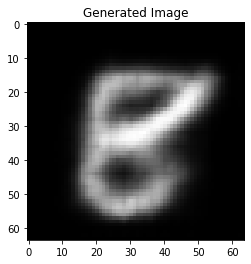

Epoch 225/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.52it/s]


Epoch [225/500], Loss: 66367.2891 (total loss), 62952.1562 (bce), 3415.1313 (kld)
Mu range: -2.3862497806549072 ~ 2.5839977264404297, Logvar range: -6.669812202453613 ~ -0.43483966588974
tensor(0)


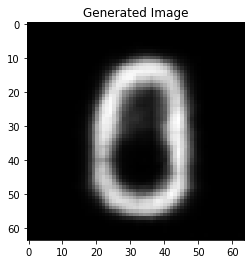

Epoch 226/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.74it/s]


Epoch [226/500], Loss: 63488.4023 (total loss), 60140.3633 (bce), 3348.0393 (kld)
Mu range: -0.9737108945846558 ~ 1.479154109954834, Logvar range: -5.62619686126709 ~ -0.28022003173828125
tensor(4)


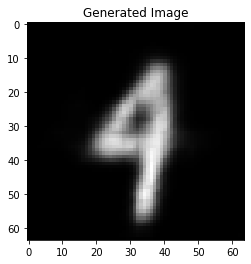

Epoch 227/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.36it/s]


Epoch [227/500], Loss: 68888.3125 (total loss), 65568.7422 (bce), 3319.5742 (kld)
Mu range: -1.1127684116363525 ~ 3.2393858432769775, Logvar range: -6.422000885009766 ~ -0.2810630202293396
tensor(3)


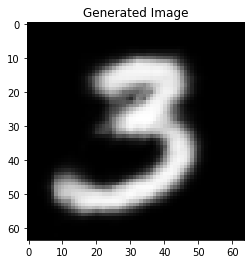

Epoch 228/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.65it/s]


Epoch [228/500], Loss: 66608.2109 (total loss), 63289.8008 (bce), 3318.4097 (kld)
Mu range: -1.5432636737823486 ~ 3.2498910427093506, Logvar range: -5.855732440948486 ~ -0.40164607763290405
tensor(6)


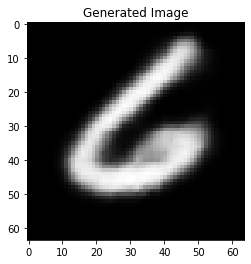

Epoch 229/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.39it/s]

Epoch [229/500], Loss: 64790.3281 (total loss), 61398.0430 (bce), 3392.2866 (kld)
Mu range: -0.8811694979667664 ~ 1.4890130758285522, Logvar range: -6.00594425201416 ~ -0.39617639780044556
tensor(7)


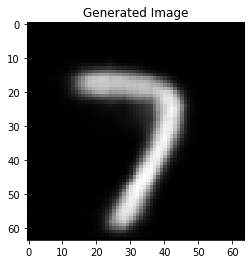

Epoch 230/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.47it/s]


Epoch [230/500], Loss: 63141.4922 (total loss), 59719.4531 (bce), 3422.0403 (kld)
Mu range: -1.4189913272857666 ~ 1.1653661727905273, Logvar range: -5.454537391662598 ~ -0.6352965831756592
tensor(4)


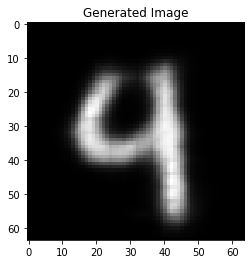

Epoch 231/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.60it/s]


Epoch [231/500], Loss: 63953.3984 (total loss), 60597.8945 (bce), 3355.5054 (kld)
Mu range: -1.0950133800506592 ~ 1.0944764614105225, Logvar range: -6.215816497802734 ~ -0.4437448978424072
tensor(3)


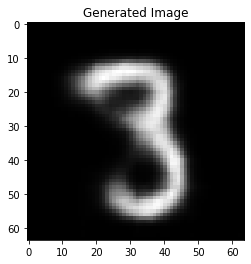

Epoch 232/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.90it/s]


Epoch [232/500], Loss: 64761.0195 (total loss), 61373.4883 (bce), 3387.5298 (kld)
Mu range: -0.8104609251022339 ~ 2.1871418952941895, Logvar range: -5.206477165222168 ~ -0.37867748737335205
tensor(5)


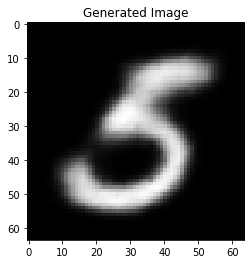

Epoch 233/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.58it/s]


Epoch [233/500], Loss: 67559.7656 (total loss), 64189.9453 (bce), 3369.8232 (kld)
Mu range: -0.9377923011779785 ~ 2.0173463821411133, Logvar range: -5.711766242980957 ~ -0.2954588532447815
tensor(3)


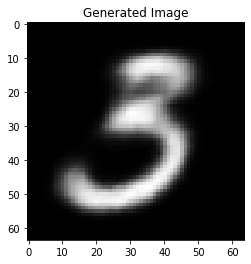

Epoch 234/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.10it/s]


Epoch [234/500], Loss: 63929.8086 (total loss), 60409.5156 (bce), 3520.2920 (kld)
Mu range: -2.0829708576202393 ~ 2.0315167903900146, Logvar range: -6.594113349914551 ~ -0.49171701073646545
tensor(7)


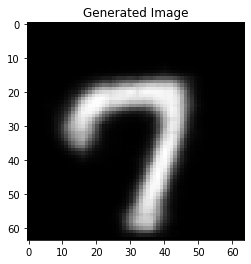

Epoch 235/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.49it/s]

Epoch [235/500], Loss: 63929.0664 (total loss), 60458.5391 (bce), 3470.5278 (kld)
Mu range: -0.674316942691803 ~ 0.9667637348175049, Logvar range: -5.247259140014648 ~ -0.6055870056152344
tensor(3)


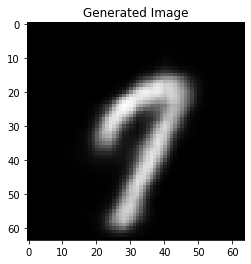

Epoch 236/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.40it/s]

Epoch [236/500], Loss: 65265.3086 (total loss), 61868.3320 (bce), 3396.9763 (kld)
Mu range: -1.398930549621582 ~ 2.9070851802825928, Logvar range: -5.872040271759033 ~ -0.48852622509002686
tensor(3)


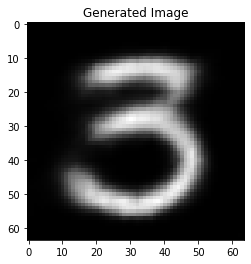

Epoch 237/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.74it/s]


Epoch [237/500], Loss: 64166.2344 (total loss), 60861.4297 (bce), 3304.8066 (kld)
Mu range: -1.867653727531433 ~ 1.5742621421813965, Logvar range: -5.1105637550354 ~ -0.5586754083633423
tensor(2)


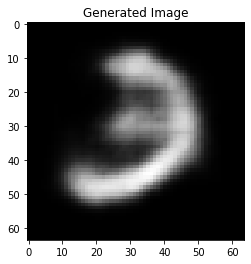

Epoch 238/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.52it/s]


Epoch [238/500], Loss: 64154.4922 (total loss), 60701.9297 (bce), 3452.5627 (kld)
Mu range: -2.7677958011627197 ~ 1.1147724390029907, Logvar range: -5.458885669708252 ~ -0.6277193427085876
tensor(7)


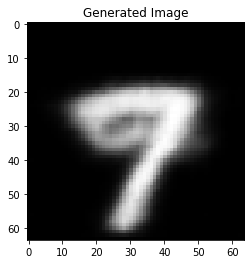

Epoch 239/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.59it/s]


Epoch [239/500], Loss: 65138.8828 (total loss), 61773.1055 (bce), 3365.7756 (kld)
Mu range: -1.4991036653518677 ~ 1.2666841745376587, Logvar range: -5.177199840545654 ~ -0.7595518231391907
tensor(0)


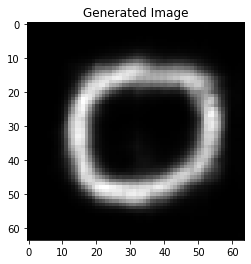

Epoch 240/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.97it/s]


Epoch [240/500], Loss: 64451.4609 (total loss), 61100.7109 (bce), 3350.7495 (kld)
Mu range: -3.3253226280212402 ~ 2.1462411880493164, Logvar range: -6.598881721496582 ~ -0.33121412992477417
tensor(8)


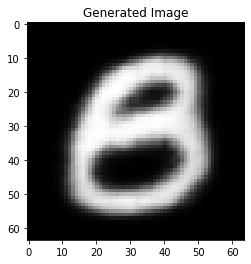

Epoch 241/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.19it/s]


Epoch [241/500], Loss: 63651.1641 (total loss), 60224.5664 (bce), 3426.5972 (kld)
Mu range: -1.3107072114944458 ~ 1.3297243118286133, Logvar range: -4.996988296508789 ~ -0.6990167498588562
tensor(5)


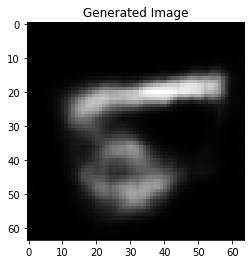

Epoch 242/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.79it/s]

Epoch [242/500], Loss: 66245.1797 (total loss), 62719.7969 (bce), 3525.3843 (kld)
Mu range: -2.0803942680358887 ~ 2.8272359371185303, Logvar range: -7.564196586608887 ~ -0.06185269355773926
tensor(2)


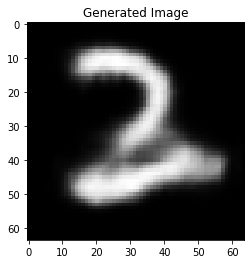

Epoch 243/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.19it/s]


Epoch [243/500], Loss: 64800.1016 (total loss), 61450.7344 (bce), 3349.3691 (kld)
Mu range: -2.246464252471924 ~ 1.2200766801834106, Logvar range: -5.80344295501709 ~ -0.230430006980896
tensor(6)


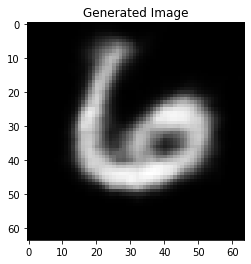

Epoch 244/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.11it/s]


Epoch [244/500], Loss: 64146.2109 (total loss), 60610.6875 (bce), 3535.5244 (kld)
Mu range: -3.131948709487915 ~ 2.6797080039978027, Logvar range: -6.109955787658691 ~ -0.1237521767616272
tensor(2)


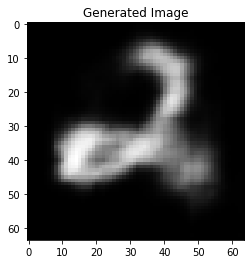

Epoch 245/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.89it/s]


Epoch [245/500], Loss: 63031.0039 (total loss), 59671.8672 (bce), 3359.1350 (kld)
Mu range: -1.108707308769226 ~ 1.8073792457580566, Logvar range: -5.2045722007751465 ~ -0.49122342467308044
tensor(5)


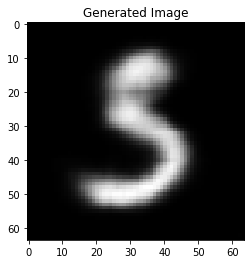

Epoch 246/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.76it/s]


Epoch [246/500], Loss: 66583.3125 (total loss), 63190.4844 (bce), 3392.8315 (kld)
Mu range: -1.2113490104675293 ~ 2.067793846130371, Logvar range: -5.252223014831543 ~ -0.5288269519805908
tensor(3)


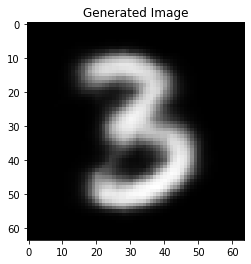

Epoch 247/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.37it/s]

Epoch [247/500], Loss: 69410.2969 (total loss), 66012.7422 (bce), 3397.5530 (kld)
Mu range: -0.8543394207954407 ~ 2.0490975379943848, Logvar range: -6.5825605392456055 ~ -0.10516786575317383
tensor(1)


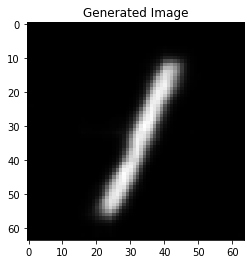

Epoch 248/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.53it/s]


Epoch [248/500], Loss: 67232.4453 (total loss), 63877.6367 (bce), 3354.8110 (kld)
Mu range: -1.3404290676116943 ~ 2.4042649269104004, Logvar range: -6.228217124938965 ~ -0.37046265602111816
tensor(5)


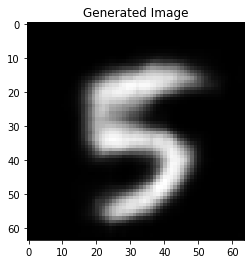

Epoch 249/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.88it/s]


Epoch [249/500], Loss: 66248.7812 (total loss), 62854.0039 (bce), 3394.7764 (kld)
Mu range: -2.6111302375793457 ~ 2.602511167526245, Logvar range: -6.716854095458984 ~ -0.19944757223129272
tensor(2)


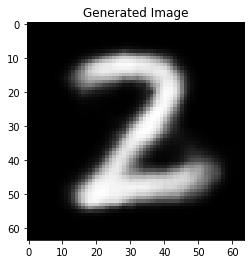

Epoch 250/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.74it/s]


Epoch [250/500], Loss: 64104.3320 (total loss), 60884.3438 (bce), 3219.9878 (kld)
Mu range: -1.807396650314331 ~ 1.3827142715454102, Logvar range: -5.03505277633667 ~ -0.7092425227165222
tensor(4)


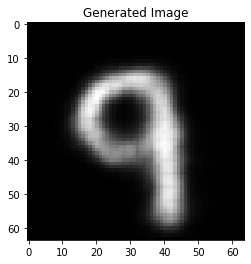

Epoch 251/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.18it/s]


Epoch [251/500], Loss: 70822.7656 (total loss), 67312.5312 (bce), 3510.2383 (kld)
Mu range: -1.3977439403533936 ~ 1.251970648765564, Logvar range: -5.535716533660889 ~ -0.58012855052948
tensor(8)


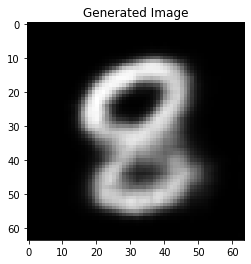

Epoch 252/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.72it/s]


Epoch [252/500], Loss: 64181.5039 (total loss), 60782.1562 (bce), 3399.3481 (kld)
Mu range: -2.0622189044952393 ~ 1.4234836101531982, Logvar range: -6.475876808166504 ~ -0.2544296383857727
tensor(2)


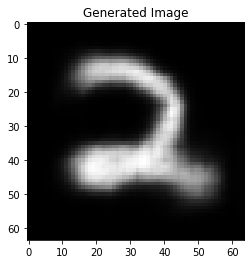

Epoch 253/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.64it/s]


Epoch [253/500], Loss: 67385.6250 (total loss), 63944.6953 (bce), 3440.9270 (kld)
Mu range: -2.831296443939209 ~ 2.7896037101745605, Logvar range: -6.316466331481934 ~ -0.42423105239868164
tensor(3)


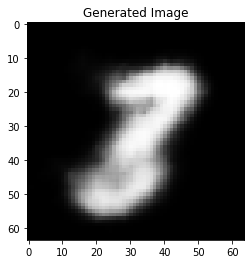

Epoch 254/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.46it/s]

Epoch [254/500], Loss: 64780.3125 (total loss), 61354.8516 (bce), 3425.4619 (kld)
Mu range: -2.1077938079833984 ~ 1.2750788927078247, Logvar range: -5.7232770919799805 ~ -0.35145169496536255
tensor(6)


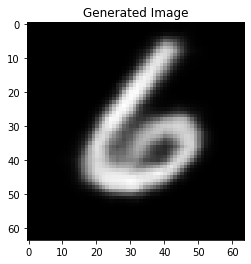

Epoch 255/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.51it/s]

Epoch [255/500], Loss: 65426.7070 (total loss), 62009.8125 (bce), 3416.8931 (kld)
Mu range: -1.6720819473266602 ~ 2.222198009490967, Logvar range: -6.254203796386719 ~ -0.2540438175201416
tensor(1)


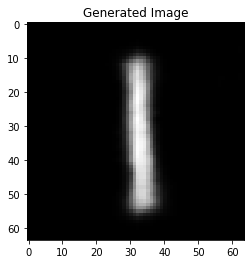

Epoch 256/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.53it/s]


Epoch [256/500], Loss: 65035.6797 (total loss), 61682.2109 (bce), 3353.4678 (kld)
Mu range: -1.039292812347412 ~ 1.1614998579025269, Logvar range: -5.676294326782227 ~ -0.45512184500694275
tensor(8)


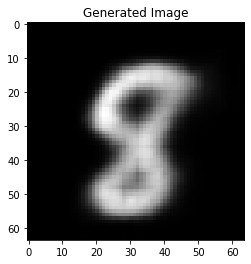

Epoch 257/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.34it/s]


Epoch [257/500], Loss: 68314.0312 (total loss), 64996.7773 (bce), 3317.2534 (kld)
Mu range: -3.101132392883301 ~ 1.5467015504837036, Logvar range: -6.233951568603516 ~ -0.13423758745193481
tensor(2)


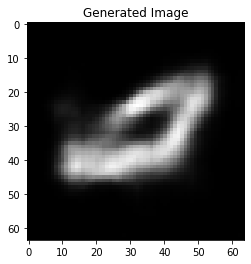

Epoch 258/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.64it/s]

Epoch [258/500], Loss: 67022.0391 (total loss), 63659.6328 (bce), 3362.4062 (kld)
Mu range: -1.0880353450775146 ~ 1.5377094745635986, Logvar range: -6.224470138549805 ~ -0.43085142970085144
tensor(3)


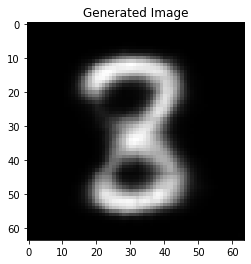

Epoch 259/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.53it/s]


Epoch [259/500], Loss: 66880.2109 (total loss), 63449.0859 (bce), 3431.1257 (kld)
Mu range: -0.6134502291679382 ~ 1.619541883468628, Logvar range: -6.297272682189941 ~ -0.06347280740737915
tensor(1)


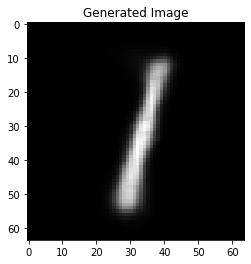

Epoch 260/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.04it/s]


Epoch [260/500], Loss: 63254.5508 (total loss), 59888.2422 (bce), 3366.3096 (kld)
Mu range: -1.7605094909667969 ~ 2.173171043395996, Logvar range: -6.313293933868408 ~ -0.25467103719711304
tensor(0)


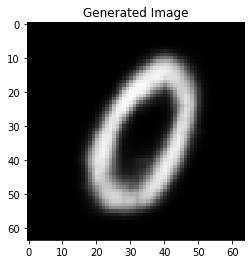

Epoch 261/500: 100%|██████████████████████████| 118/118 [00:11<00:00,  9.92it/s]


Epoch [261/500], Loss: 70442.0547 (total loss), 67033.3438 (bce), 3408.7124 (kld)
Mu range: -2.463977098464966 ~ 1.9989509582519531, Logvar range: -5.675360679626465 ~ -0.3242119550704956
tensor(0)


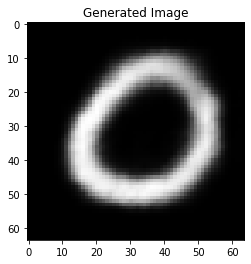

Epoch 262/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.63it/s]


Epoch [262/500], Loss: 63256.7617 (total loss), 59912.6094 (bce), 3344.1528 (kld)
Mu range: -1.0475307703018188 ~ 0.5185795426368713, Logvar range: -5.599384307861328 ~ -0.4497796297073364
tensor(4)


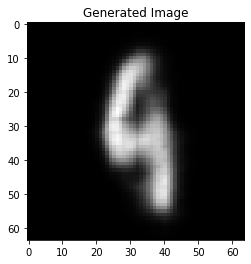

Epoch 263/500: 100%|██████████████████████████| 118/118 [00:09<00:00, 11.83it/s]


Epoch [263/500], Loss: 69266.9609 (total loss), 65802.3984 (bce), 3464.5613 (kld)
Mu range: -2.963416576385498 ~ 2.7243151664733887, Logvar range: -6.372867584228516 ~ -0.20132964849472046
tensor(6)


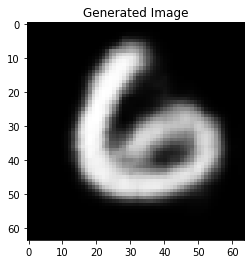

Epoch 264/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.80it/s]


Epoch [264/500], Loss: 67756.2578 (total loss), 64372.4570 (bce), 3383.7998 (kld)
Mu range: -2.371396780014038 ~ 1.4359830617904663, Logvar range: -5.624900817871094 ~ -0.46990031003952026
tensor(7)


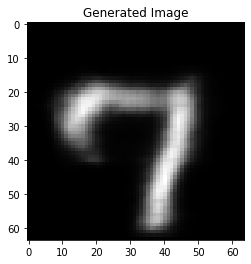

Epoch 265/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.82it/s]


Epoch [265/500], Loss: 65664.3672 (total loss), 62264.8398 (bce), 3399.5278 (kld)
Mu range: -1.614152431488037 ~ 1.9972981214523315, Logvar range: -5.400064945220947 ~ -0.5845186710357666
tensor(8)


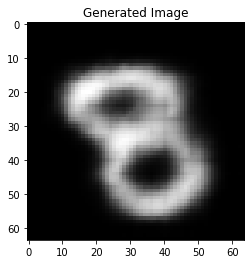

Epoch 266/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.76it/s]

Epoch [266/500], Loss: 67977.4375 (total loss), 64528.3672 (bce), 3449.0693 (kld)
Mu range: -1.6830512285232544 ~ 1.309218168258667, Logvar range: -5.722210884094238 ~ -0.34228354692459106
tensor(6)


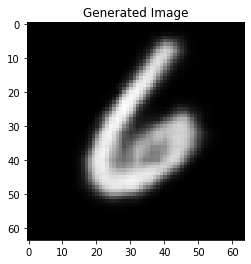

Epoch 267/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.40it/s]


Epoch [267/500], Loss: 64699.9102 (total loss), 61366.4180 (bce), 3333.4927 (kld)
Mu range: -1.2486090660095215 ~ 1.8483153581619263, Logvar range: -5.340938568115234 ~ -0.34805095195770264
tensor(5)


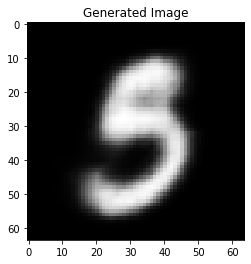

Epoch 268/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.60it/s]


Epoch [268/500], Loss: 66447.7891 (total loss), 63125.2539 (bce), 3322.5366 (kld)
Mu range: -1.7319035530090332 ~ 4.1007466316223145, Logvar range: -6.410552978515625 ~ -0.13476574420928955
tensor(3)


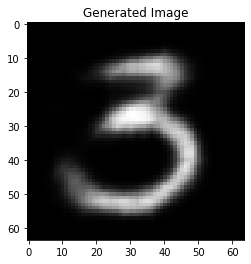

Epoch 269/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.07it/s]

Epoch [269/500], Loss: 63689.8203 (total loss), 60217.6719 (bce), 3472.1501 (kld)
Mu range: -2.9429914951324463 ~ 3.303483486175537, Logvar range: -7.968029022216797 ~ 0.08015686273574829
tensor(7)


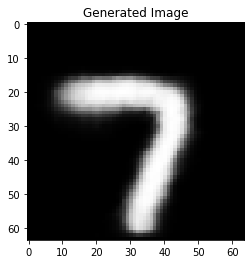

Epoch 270/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.53it/s]


Epoch [270/500], Loss: 65776.5078 (total loss), 62377.3828 (bce), 3399.1243 (kld)
Mu range: -0.6979880928993225 ~ 1.170710802078247, Logvar range: -5.048033714294434 ~ -0.5252094268798828
tensor(4)


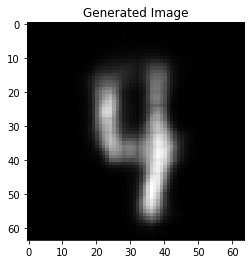

Epoch 271/500: 100%|██████████████████████████| 118/118 [00:11<00:00,  9.98it/s]

Epoch [271/500], Loss: 63902.7969 (total loss), 60445.6562 (bce), 3457.1411 (kld)
Mu range: -1.6100176572799683 ~ 0.8396764993667603, Logvar range: -5.4364190101623535 ~ -0.35090339183807373
tensor(5)


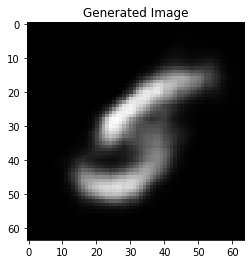

Epoch 272/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.78it/s]


Epoch [272/500], Loss: 65940.4844 (total loss), 62586.5977 (bce), 3353.8887 (kld)
Mu range: -0.8645095825195312 ~ 1.308732509613037, Logvar range: -4.93389368057251 ~ -0.5653129816055298
tensor(3)


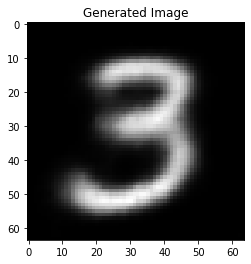

Epoch 273/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.51it/s]

Epoch [273/500], Loss: 63872.1484 (total loss), 60449.3594 (bce), 3422.7881 (kld)
Mu range: -1.8213326930999756 ~ 1.0062687397003174, Logvar range: -5.517989635467529 ~ -0.5491971969604492
tensor(5)


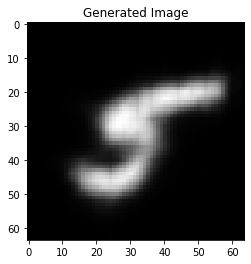

Epoch 274/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.66it/s]


Epoch [274/500], Loss: 67173.2891 (total loss), 63717.0352 (bce), 3456.2534 (kld)
Mu range: -1.3099104166030884 ~ 1.1003353595733643, Logvar range: -5.878034591674805 ~ -0.4079558551311493
tensor(7)


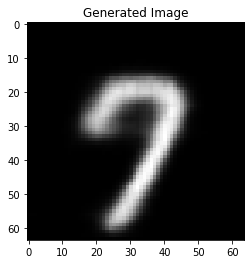

Epoch 275/500: 100%|██████████████████████████| 118/118 [00:11<00:00,  9.85it/s]


Epoch [275/500], Loss: 67682.1328 (total loss), 64221.4609 (bce), 3460.6714 (kld)
Mu range: -1.0084002017974854 ~ 2.261019468307495, Logvar range: -5.391542911529541 ~ -0.3402884304523468
tensor(6)


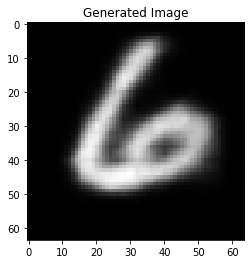

Epoch 276/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.02it/s]


Epoch [276/500], Loss: 64888.8750 (total loss), 61370.1602 (bce), 3518.7129 (kld)
Mu range: -2.878070592880249 ~ 2.7274765968322754, Logvar range: -6.020781993865967 ~ -0.2379167675971985
tensor(2)


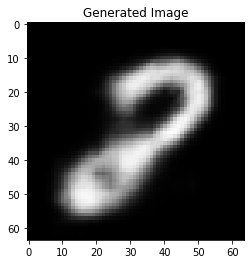

Epoch 277/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.28it/s]


Epoch [277/500], Loss: 66341.7266 (total loss), 62877.5312 (bce), 3464.1924 (kld)
Mu range: -1.3874742984771729 ~ 2.0351414680480957, Logvar range: -5.897545337677002 ~ -0.13644158840179443
tensor(6)


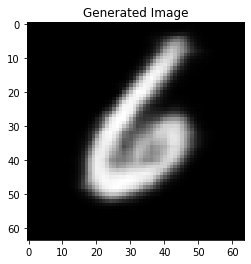

Epoch 278/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.20it/s]


Epoch [278/500], Loss: 68035.3125 (total loss), 64644.6953 (bce), 3390.6152 (kld)
Mu range: -1.2090539932250977 ~ 3.782656669616699, Logvar range: -5.879687786102295 ~ -0.38624629378318787
tensor(2)


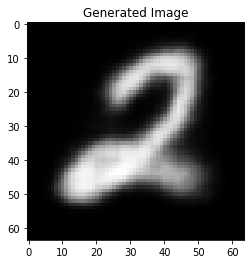

Epoch 279/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.24it/s]


Epoch [279/500], Loss: 65209.2188 (total loss), 61778.7461 (bce), 3430.4731 (kld)
Mu range: -2.120689868927002 ~ 2.8301138877868652, Logvar range: -5.863834381103516 ~ -0.2614080309867859
tensor(2)


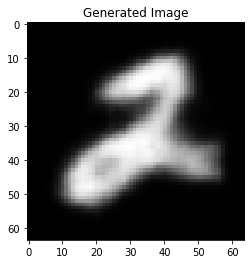

Epoch 280/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.37it/s]


Epoch [280/500], Loss: 64716.4453 (total loss), 61275.9141 (bce), 3440.5315 (kld)
Mu range: -2.6476552486419678 ~ 3.0141241550445557, Logvar range: -6.635525703430176 ~ -0.09614038467407227
tensor(5)


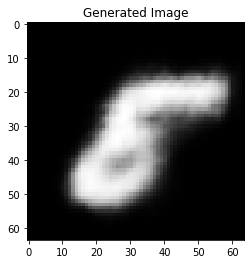

Epoch 281/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.79it/s]


Epoch [281/500], Loss: 64300.0820 (total loss), 60888.4961 (bce), 3411.5854 (kld)
Mu range: -2.393512725830078 ~ 1.6778264045715332, Logvar range: -6.1023850440979 ~ -0.24517858028411865
tensor(0)


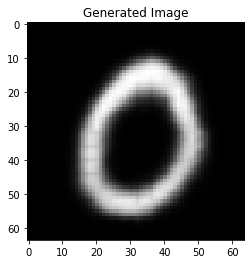

Epoch 282/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.28it/s]

Epoch [282/500], Loss: 65095.3398 (total loss), 61683.2031 (bce), 3412.1350 (kld)
Mu range: -2.2489535808563232 ~ 1.72041916847229, Logvar range: -5.9957356452941895 ~ -0.022489726543426514
tensor(4)


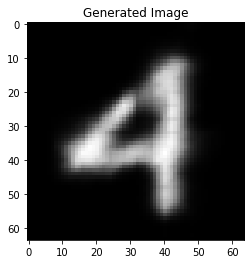

Epoch 283/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.37it/s]

Epoch [283/500], Loss: 63501.2773 (total loss), 60146.2383 (bce), 3355.0393 (kld)
Mu range: -3.1972615718841553 ~ 1.8251357078552246, Logvar range: -7.481557369232178 ~ 0.05005443096160889
tensor(7)


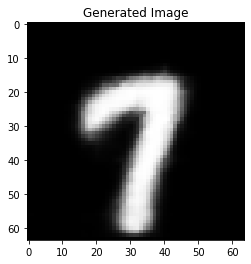

Epoch 284/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.66it/s]


Epoch [284/500], Loss: 62651.6055 (total loss), 59248.2656 (bce), 3403.3403 (kld)
Mu range: -0.6755743026733398 ~ 1.260848045349121, Logvar range: -5.331331729888916 ~ -0.42989546060562134
tensor(3)


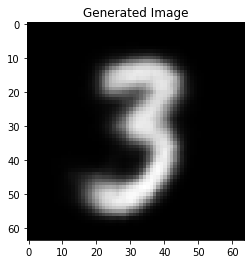

Epoch 285/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.29it/s]

Epoch [285/500], Loss: 65323.2930 (total loss), 61898.2422 (bce), 3425.0503 (kld)
Mu range: -0.5709460377693176 ~ 1.7392830848693848, Logvar range: -5.944574356079102 ~ -0.22717851400375366
tensor(8)


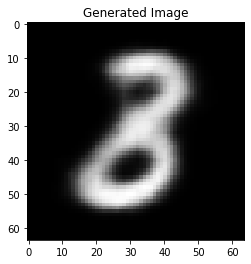

Epoch 286/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.28it/s]

Epoch [286/500], Loss: 65937.3984 (total loss), 62554.2734 (bce), 3383.1284 (kld)
Mu range: -1.4785325527191162 ~ 0.9141625761985779, Logvar range: -5.40849494934082 ~ -0.440926194190979
tensor(5)


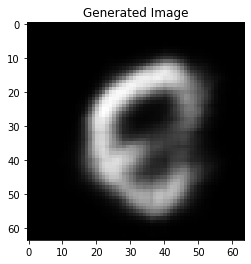

Epoch 287/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.42it/s]


Epoch [287/500], Loss: 67018.8281 (total loss), 63575.2930 (bce), 3443.5366 (kld)
Mu range: -0.5387435555458069 ~ 3.2126083374023438, Logvar range: -6.18649959564209 ~ -0.10256826877593994
tensor(6)


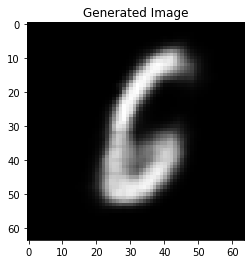

Epoch 288/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.51it/s]


Epoch [288/500], Loss: 63988.0430 (total loss), 60459.1250 (bce), 3528.9172 (kld)
Mu range: -0.7305934429168701 ~ 0.9427381753921509, Logvar range: -5.222965717315674 ~ -0.4066813588142395
tensor(1)


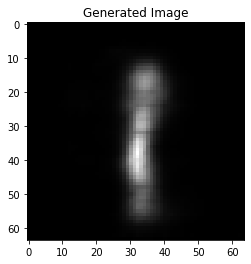

Epoch 289/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.70it/s]

Epoch [289/500], Loss: 63745.3125 (total loss), 60353.9766 (bce), 3391.3379 (kld)
Mu range: -1.4150025844573975 ~ 1.6139711141586304, Logvar range: -5.715619087219238 ~ -0.08353567123413086
tensor(6)


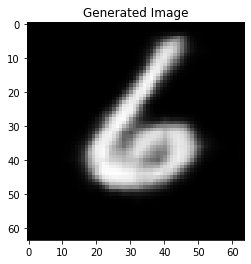

Epoch 290/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.48it/s]

Epoch [290/500], Loss: 63295.5039 (total loss), 59829.4336 (bce), 3466.0693 (kld)
Mu range: -3.004303216934204 ~ 2.69270658493042, Logvar range: -7.09691047668457 ~ -0.06626701354980469
tensor(9)


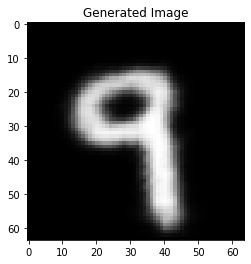

Epoch 291/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.59it/s]


Epoch [291/500], Loss: 65763.7812 (total loss), 62485.4648 (bce), 3278.3164 (kld)
Mu range: -1.0880017280578613 ~ 1.2931994199752808, Logvar range: -6.168683052062988 ~ -0.28419601917266846
tensor(7)


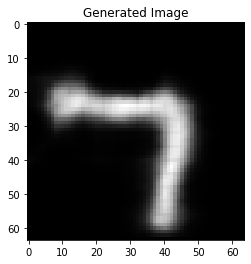

Epoch 292/500: 100%|██████████████████████████| 118/118 [00:11<00:00,  9.95it/s]

Epoch [292/500], Loss: 64753.6641 (total loss), 61281.4453 (bce), 3472.2178 (kld)
Mu range: -1.5920320749282837 ~ 3.1790902614593506, Logvar range: -7.502938747406006 ~ 0.07824975252151489
tensor(3)


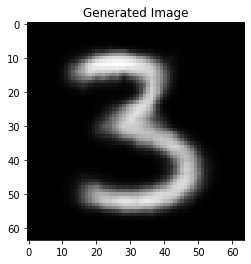

Epoch 293/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.37it/s]


Epoch [293/500], Loss: 67081.4844 (total loss), 63682.5820 (bce), 3398.9004 (kld)
Mu range: -2.1712496280670166 ~ 3.427717685699463, Logvar range: -7.010166168212891 ~ 0.03502988815307617
tensor(1)


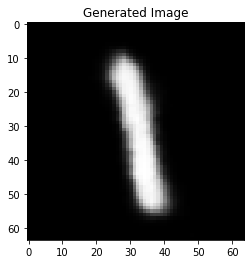

Epoch 294/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.08it/s]

Epoch [294/500], Loss: 66854.7266 (total loss), 63317.5391 (bce), 3537.1868 (kld)
Mu range: -1.8126485347747803 ~ 2.447721004486084, Logvar range: -6.704859733581543 ~ -0.06389927864074707
tensor(7)


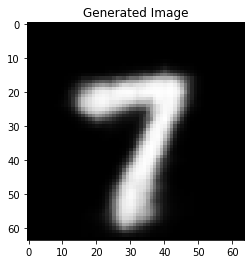

Epoch 295/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.57it/s]


Epoch [295/500], Loss: 63250.4766 (total loss), 59714.0234 (bce), 3536.4521 (kld)
Mu range: -1.4932361841201782 ~ 1.9718780517578125, Logvar range: -6.132641315460205 ~ -0.12231665849685669
tensor(6)


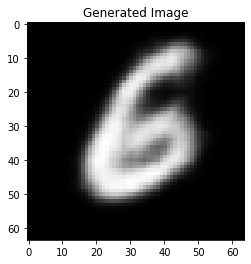

Epoch 296/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.26it/s]


Epoch [296/500], Loss: 61020.6914 (total loss), 57522.9922 (bce), 3497.6985 (kld)
Mu range: -1.4551804065704346 ~ 1.2614902257919312, Logvar range: -6.501275062561035 ~ -0.020244717597961426
tensor(1)


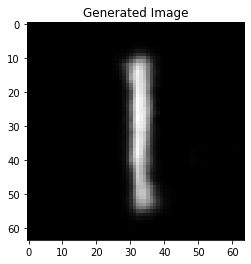

Epoch 297/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.88it/s]


Epoch [297/500], Loss: 67506.3984 (total loss), 64080.2344 (bce), 3426.1665 (kld)
Mu range: -2.444221019744873 ~ 2.273836612701416, Logvar range: -6.260503768920898 ~ -0.008060574531555176
tensor(0)


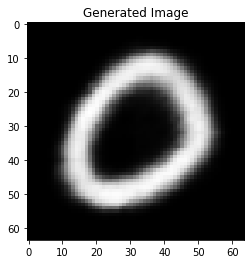

Epoch 298/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.09it/s]


Epoch [298/500], Loss: 67089.6406 (total loss), 63726.7891 (bce), 3362.8525 (kld)
Mu range: -0.967604398727417 ~ 2.588306427001953, Logvar range: -5.368803024291992 ~ -0.410247802734375
tensor(3)


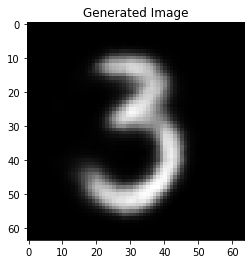

Epoch 299/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.20it/s]

Epoch [299/500], Loss: 66262.0859 (total loss), 62962.2188 (bce), 3299.8691 (kld)
Mu range: -1.3410420417785645 ~ 1.1278493404388428, Logvar range: -6.262139320373535 ~ -0.16283565759658813
tensor(4)


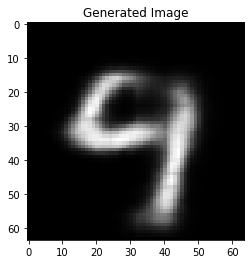

Epoch 300/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.45it/s]


Epoch [300/500], Loss: 62791.3203 (total loss), 59431.2188 (bce), 3360.1023 (kld)
Mu range: -2.029226303100586 ~ 0.9861226677894592, Logvar range: -5.6570587158203125 ~ -0.40167105197906494
tensor(0)


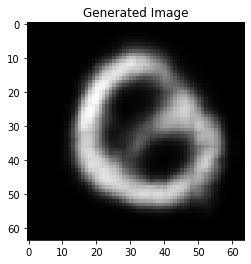

Epoch 301/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.57it/s]


Epoch [301/500], Loss: 67210.2188 (total loss), 63799.3594 (bce), 3410.8555 (kld)
Mu range: -1.8743228912353516 ~ 1.6667442321777344, Logvar range: -6.256136417388916 ~ -0.20199233293533325
tensor(7)


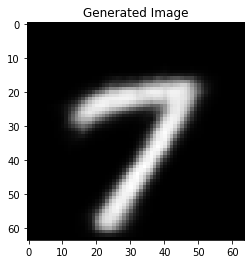

Epoch 302/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.22it/s]


Epoch [302/500], Loss: 65285.6289 (total loss), 61819.9023 (bce), 3465.7266 (kld)
Mu range: -0.5271738171577454 ~ 1.7707395553588867, Logvar range: -5.819700241088867 ~ -0.3718487024307251
tensor(5)


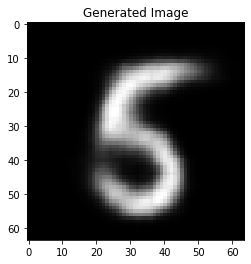

Epoch 303/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.07it/s]


Epoch [303/500], Loss: 65209.4180 (total loss), 61814.3359 (bce), 3395.0803 (kld)
Mu range: -2.3999664783477783 ~ 3.0824813842773438, Logvar range: -6.711276054382324 ~ 0.022166848182678223
tensor(0)


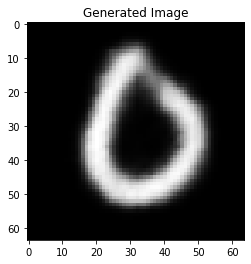

Epoch 304/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.55it/s]


Epoch [304/500], Loss: 66759.6719 (total loss), 63357.6602 (bce), 3402.0105 (kld)
Mu range: -1.4499197006225586 ~ 2.004971742630005, Logvar range: -5.7765302658081055 ~ 0.0014923810958862305
tensor(6)


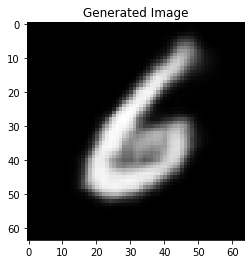

Epoch 305/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.63it/s]


Epoch [305/500], Loss: 65253.0703 (total loss), 61810.9336 (bce), 3442.1367 (kld)
Mu range: -2.0429158210754395 ~ 0.8193545937538147, Logvar range: -5.7308197021484375 ~ -0.2501809000968933
tensor(3)


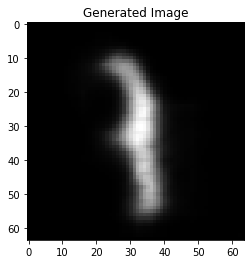

Epoch 306/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.24it/s]

Epoch [306/500], Loss: 63884.2461 (total loss), 60379.9492 (bce), 3504.2957 (kld)
Mu range: -1.6333651542663574 ~ 1.6021137237548828, Logvar range: -6.569944381713867 ~ 0.03748995065689087
tensor(1)


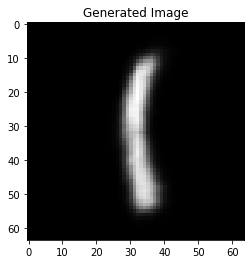

Epoch 307/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.06it/s]

Epoch [307/500], Loss: 64832.9492 (total loss), 61416.1602 (bce), 3416.7900 (kld)
Mu range: -2.3912315368652344 ~ 2.540853500366211, Logvar range: -6.597062110900879 ~ -0.10445356369018555
tensor(9)


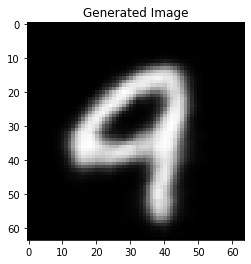

Epoch 308/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.35it/s]

Epoch [308/500], Loss: 64952.8203 (total loss), 61516.9766 (bce), 3435.8455 (kld)
Mu range: -1.3863065242767334 ~ 1.519047498703003, Logvar range: -6.482076644897461 ~ -0.20581263303756714
tensor(8)


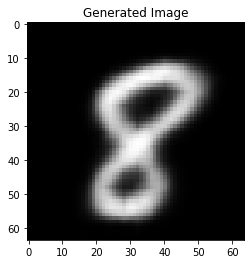

Epoch 309/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.03it/s]


Epoch [309/500], Loss: 62122.1797 (total loss), 58629.0625 (bce), 3493.1157 (kld)
Mu range: -1.2288717031478882 ~ 0.8168575763702393, Logvar range: -5.662701606750488 ~ -0.38002973794937134
tensor(9)


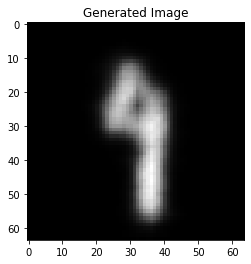

Epoch 310/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.04it/s]


Epoch [310/500], Loss: 64967.6211 (total loss), 61719.7227 (bce), 3247.8987 (kld)
Mu range: -0.8499282002449036 ~ 1.4365655183792114, Logvar range: -6.304947853088379 ~ -0.20236659049987793
tensor(5)


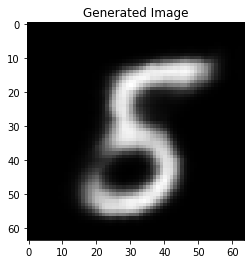

Epoch 311/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.68it/s]

Epoch [311/500], Loss: 66318.2188 (total loss), 62841.3438 (bce), 3476.8745 (kld)
Mu range: -0.813014030456543 ~ 0.6143040657043457, Logvar range: -4.7755446434021 ~ -0.5363823771476746
tensor(9)


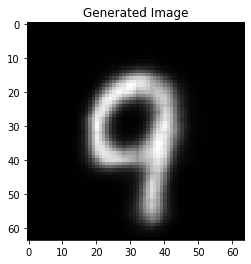

Epoch 312/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.45it/s]

Epoch [312/500], Loss: 64337.5586 (total loss), 60956.8047 (bce), 3380.7524 (kld)
Mu range: -1.0728548765182495 ~ 1.620470643043518, Logvar range: -5.849883556365967 ~ -0.32330578565597534
tensor(8)


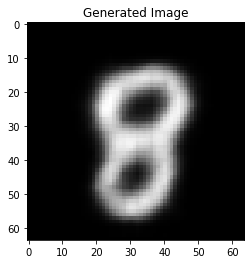

Epoch 313/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.42it/s]

Epoch [313/500], Loss: 65721.6875 (total loss), 62294.6406 (bce), 3427.0469 (kld)
Mu range: -0.8387184143066406 ~ 1.4155365228652954, Logvar range: -4.967973232269287 ~ -0.4757267236709595
tensor(3)


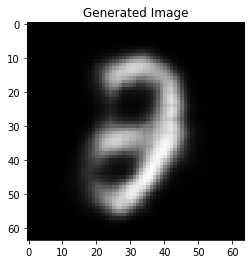

Epoch 314/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.51it/s]


Epoch [314/500], Loss: 63781.9922 (total loss), 60270.1484 (bce), 3511.8423 (kld)
Mu range: -1.542246699333191 ~ 2.1745753288269043, Logvar range: -6.367565155029297 ~ -0.19342249631881714
tensor(5)


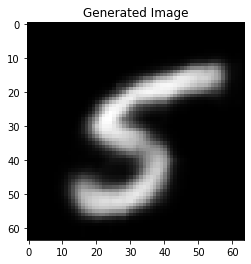

Epoch 315/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.12it/s]

Epoch [315/500], Loss: 62321.6250 (total loss), 58806.9102 (bce), 3514.7168 (kld)
Mu range: -2.1420140266418457 ~ 2.8113486766815186, Logvar range: -5.982379913330078 ~ -0.14710235595703125
tensor(3)


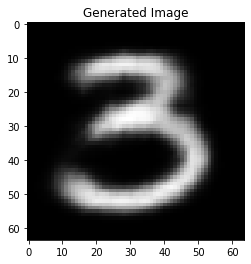

Epoch 316/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.25it/s]


Epoch [316/500], Loss: 64984.1367 (total loss), 61491.6719 (bce), 3492.4651 (kld)
Mu range: -1.0016255378723145 ~ 1.842407464981079, Logvar range: -5.563193321228027 ~ -0.3454902172088623
tensor(2)


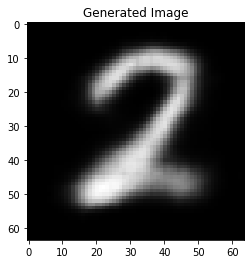

Epoch 317/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.44it/s]


Epoch [317/500], Loss: 63970.6016 (total loss), 60488.9297 (bce), 3481.6704 (kld)
Mu range: -1.240090250968933 ~ 1.027925968170166, Logvar range: -6.541070938110352 ~ -0.08332675695419312
tensor(9)


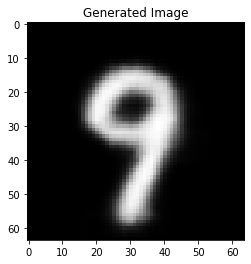

Epoch 318/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.24it/s]


Epoch [318/500], Loss: 64566.3359 (total loss), 61172.9609 (bce), 3393.3748 (kld)
Mu range: -5.253084182739258 ~ 2.9123690128326416, Logvar range: -5.482036113739014 ~ -0.18252703547477722
tensor(4)


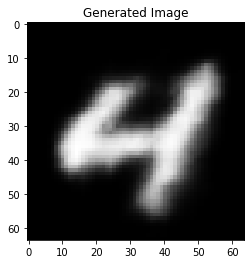

Epoch 319/500: 100%|██████████████████████████| 118/118 [00:11<00:00,  9.96it/s]


Epoch [319/500], Loss: 65880.1094 (total loss), 62367.5352 (bce), 3512.5764 (kld)
Mu range: -1.968538761138916 ~ 1.6991139650344849, Logvar range: -5.867710113525391 ~ -0.24723675847053528
tensor(4)


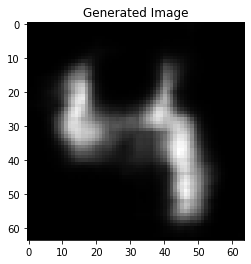

Epoch 320/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.58it/s]


Epoch [320/500], Loss: 63186.1016 (total loss), 59761.0664 (bce), 3425.0337 (kld)
Mu range: -1.6760971546173096 ~ 1.8399324417114258, Logvar range: -5.3786115646362305 ~ -0.27693694829940796
tensor(2)


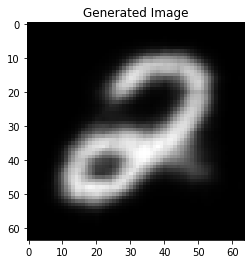

Epoch 321/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.76it/s]

Epoch [321/500], Loss: 65853.1719 (total loss), 62513.8750 (bce), 3339.2939 (kld)
Mu range: -1.359689712524414 ~ 1.7122666835784912, Logvar range: -5.830510139465332 ~ -0.17340222001075745
tensor(8)


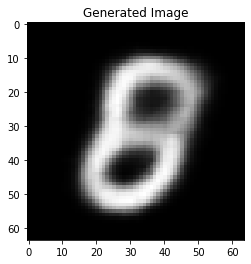

Epoch 322/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.79it/s]


Epoch [322/500], Loss: 62387.1680 (total loss), 58883.8750 (bce), 3503.2939 (kld)
Mu range: -1.3242172002792358 ~ 1.4402403831481934, Logvar range: -5.733030319213867 ~ -0.26219847798347473
tensor(9)


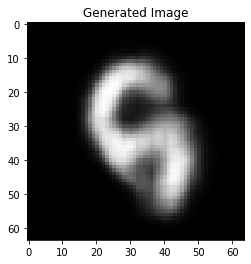

Epoch 323/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.47it/s]


Epoch [323/500], Loss: 66750.5234 (total loss), 63289.1641 (bce), 3461.3569 (kld)
Mu range: -3.6678645610809326 ~ 2.798851490020752, Logvar range: -6.092499256134033 ~ -0.004953920841217041
tensor(0)


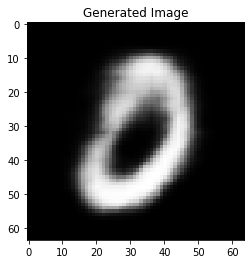

Epoch 324/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.56it/s]


Epoch [324/500], Loss: 67481.2344 (total loss), 64048.0156 (bce), 3433.2219 (kld)
Mu range: -0.5004349946975708 ~ 0.9936450719833374, Logvar range: -5.016953945159912 ~ -0.4293608069419861
tensor(6)


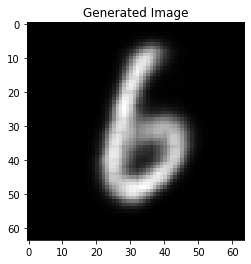

Epoch 325/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.84it/s]

Epoch [325/500], Loss: 62440.7070 (total loss), 59057.5234 (bce), 3383.1843 (kld)
Mu range: -0.9528241753578186 ~ 0.9939208030700684, Logvar range: -5.1033735275268555 ~ -0.40956225991249084
tensor(8)


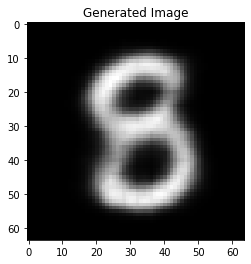

Epoch 326/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.12it/s]

Epoch [326/500], Loss: 63515.0273 (total loss), 60029.3828 (bce), 3485.6436 (kld)
Mu range: -1.4541208744049072 ~ 1.6522157192230225, Logvar range: -6.417084693908691 ~ -0.206341952085495
tensor(2)


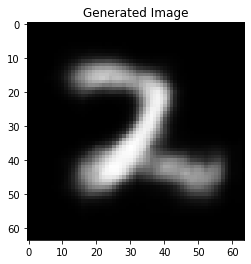

Epoch 327/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.47it/s]

Epoch [327/500], Loss: 66144.7891 (total loss), 62693.7461 (bce), 3451.0415 (kld)
Mu range: -0.9229135513305664 ~ 1.7251566648483276, Logvar range: -5.717439651489258 ~ -0.2023601531982422
tensor(2)


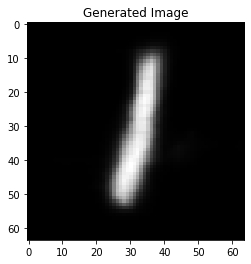

Epoch 328/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.92it/s]


Epoch [328/500], Loss: 65049.7109 (total loss), 61587.8281 (bce), 3461.8835 (kld)
Mu range: -5.51345157623291 ~ 3.7148525714874268, Logvar range: -7.37785530090332 ~ 0.09185045957565308
tensor(0)


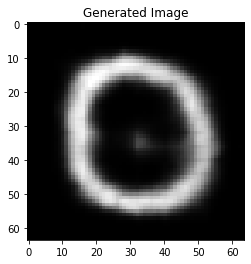

Epoch 329/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.66it/s]


Epoch [329/500], Loss: 62416.9414 (total loss), 58969.3086 (bce), 3447.6313 (kld)
Mu range: -1.7436113357543945 ~ 1.6579781770706177, Logvar range: -6.205689430236816 ~ -0.24875837564468384
tensor(8)


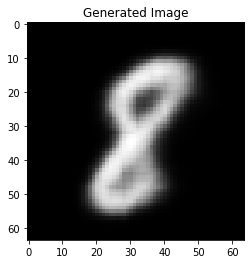

Epoch 330/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.57it/s]


Epoch [330/500], Loss: 62348.5391 (total loss), 59007.4883 (bce), 3341.0527 (kld)
Mu range: -1.5537402629852295 ~ 3.333322763442993, Logvar range: -6.546818733215332 ~ -0.05649346113204956
tensor(2)


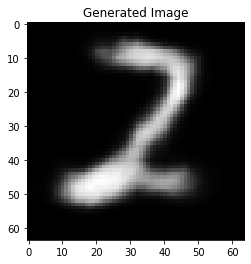

Epoch 331/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.72it/s]

Epoch [331/500], Loss: 65906.9766 (total loss), 62394.2734 (bce), 3512.7036 (kld)
Mu range: -2.9543967247009277 ~ 2.6173627376556396, Logvar range: -7.27193546295166 ~ 0.21251040697097778
tensor(7)


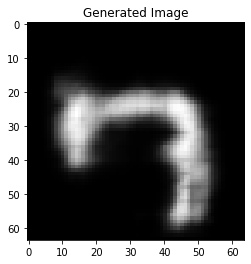

Epoch 332/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.66it/s]

Epoch [332/500], Loss: 63055.4688 (total loss), 59553.0039 (bce), 3502.4634 (kld)
Mu range: -0.8258861303329468 ~ 1.231431007385254, Logvar range: -6.284272193908691 ~ -0.11219120025634766
tensor(7)


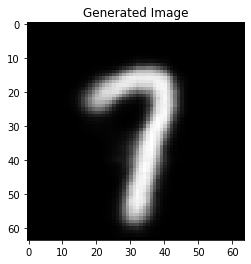

Epoch 333/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.24it/s]


Epoch [333/500], Loss: 66382.7578 (total loss), 62943.9180 (bce), 3438.8430 (kld)
Mu range: -0.886073112487793 ~ 1.6975771188735962, Logvar range: -5.820508003234863 ~ -0.24843424558639526
tensor(1)


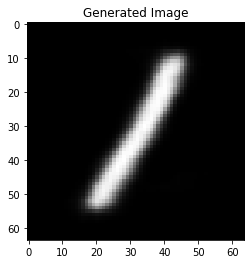

Epoch 334/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.46it/s]


Epoch [334/500], Loss: 66110.2656 (total loss), 62745.7266 (bce), 3364.5415 (kld)
Mu range: -1.1037397384643555 ~ 1.4978092908859253, Logvar range: -6.96381139755249 ~ -0.09740233421325684
tensor(8)


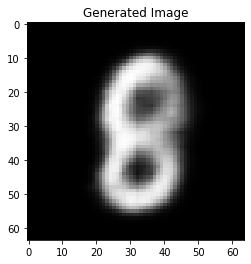

Epoch 335/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.32it/s]

Epoch [335/500], Loss: 67118.9609 (total loss), 63717.9180 (bce), 3401.0454 (kld)
Mu range: -1.5115300416946411 ~ 1.3549944162368774, Logvar range: -5.984654426574707 ~ -0.15430456399917603
tensor(2)


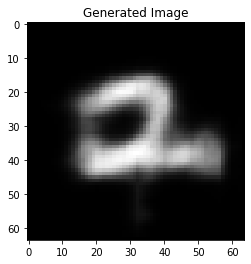

Epoch 336/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.22it/s]


Epoch [336/500], Loss: 68186.1328 (total loss), 64756.9805 (bce), 3429.1519 (kld)
Mu range: -2.6325316429138184 ~ 1.8579233884811401, Logvar range: -6.381699562072754 ~ 0.03212237358093262
tensor(0)


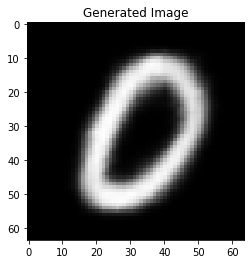

Epoch 337/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.29it/s]


Epoch [337/500], Loss: 62736.5039 (total loss), 59285.2930 (bce), 3451.2109 (kld)
Mu range: -1.8074687719345093 ~ 0.9508029222488403, Logvar range: -5.783296585083008 ~ -0.23221847414970398
tensor(7)


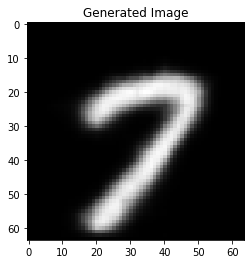

Epoch 338/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.40it/s]


Epoch [338/500], Loss: 66136.7344 (total loss), 62727.7109 (bce), 3409.0198 (kld)
Mu range: -0.613641619682312 ~ 1.0963692665100098, Logvar range: -5.510130882263184 ~ -0.27246999740600586
tensor(3)


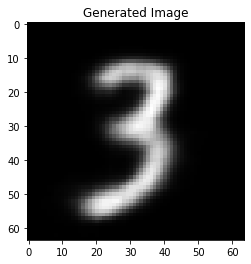

Epoch 339/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.16it/s]

Epoch [339/500], Loss: 66822.6953 (total loss), 63314.2109 (bce), 3508.4849 (kld)
Mu range: -1.7551389932632446 ~ 0.6894893050193787, Logvar range: -5.565680980682373 ~ -0.28097444772720337
tensor(7)


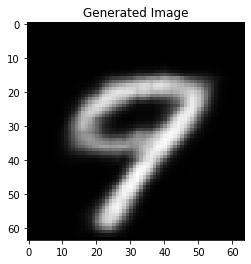

Epoch 340/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.27it/s]


Epoch [340/500], Loss: 65394.2969 (total loss), 61935.7188 (bce), 3458.5762 (kld)
Mu range: -0.732988178730011 ~ 0.6701033711433411, Logvar range: -5.597268581390381 ~ -0.30593207478523254
tensor(4)


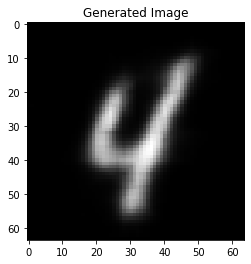

Epoch 341/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.20it/s]


Epoch [341/500], Loss: 64604.1641 (total loss), 61134.6484 (bce), 3469.5151 (kld)
Mu range: -1.834707260131836 ~ 1.8567233085632324, Logvar range: -5.965902805328369 ~ -0.3105018734931946
tensor(8)


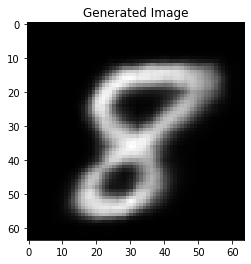

Epoch 342/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.58it/s]

Epoch [342/500], Loss: 66042.2344 (total loss), 62648.1211 (bce), 3394.1094 (kld)
Mu range: -2.1283175945281982 ~ 1.0474560260772705, Logvar range: -5.77301025390625 ~ -0.21114590764045715
tensor(4)


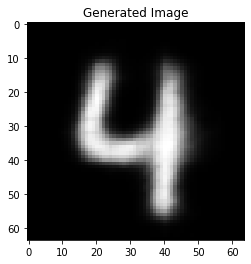

Epoch 343/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.46it/s]


Epoch [343/500], Loss: 64652.8164 (total loss), 61200.1211 (bce), 3452.6963 (kld)
Mu range: -1.0978541374206543 ~ 1.9233862161636353, Logvar range: -6.6383867263793945 ~ 0.002988755702972412
tensor(7)


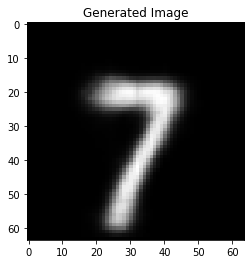

Epoch 344/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.10it/s]


Epoch [344/500], Loss: 66086.9766 (total loss), 62553.7930 (bce), 3533.1836 (kld)
Mu range: -4.5987701416015625 ~ 4.115595817565918, Logvar range: -8.282154083251953 ~ 0.23987817764282227
tensor(8)


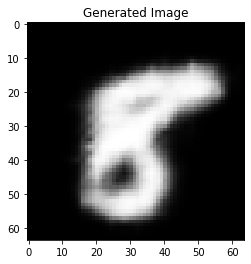

Epoch 345/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.22it/s]

Epoch [345/500], Loss: 62422.5820 (total loss), 58918.9219 (bce), 3503.6592 (kld)
Mu range: -1.7276265621185303 ~ 0.8434590101242065, Logvar range: -6.032057762145996 ~ -0.21068507432937622
tensor(9)


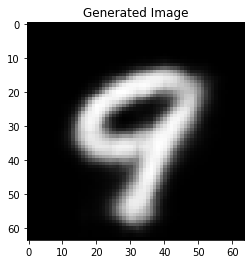

Epoch 346/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.24it/s]

Epoch [346/500], Loss: 66142.9609 (total loss), 62583.6172 (bce), 3559.3433 (kld)
Mu range: -1.679348111152649 ~ 1.0784039497375488, Logvar range: -6.149228096008301 ~ -0.07713544368743896
tensor(4)


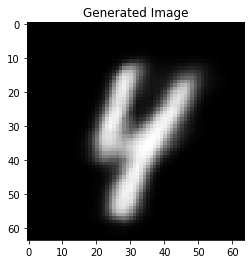

Epoch 347/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.34it/s]


Epoch [347/500], Loss: 62012.6484 (total loss), 58738.4805 (bce), 3274.1665 (kld)
Mu range: -1.1561042070388794 ~ 2.132462501525879, Logvar range: -6.309892177581787 ~ -0.10221540927886963
tensor(6)


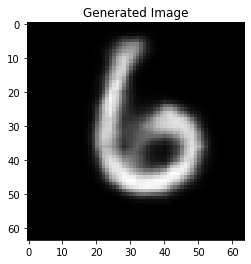

Epoch 348/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.22it/s]


Epoch [348/500], Loss: 69215.2969 (total loss), 65900.3359 (bce), 3314.9592 (kld)
Mu range: -1.2326924800872803 ~ 1.5016847848892212, Logvar range: -6.257466793060303 ~ -0.09664410352706909
tensor(5)


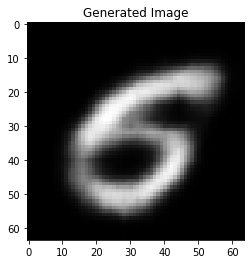

Epoch 349/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.21it/s]

Epoch [349/500], Loss: 64415.8594 (total loss), 60949.8438 (bce), 3466.0171 (kld)
Mu range: -0.694080650806427 ~ 1.7170515060424805, Logvar range: -5.615251064300537 ~ -0.2010004222393036
tensor(8)


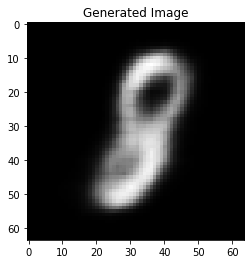

Epoch 350/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.52it/s]


Epoch [350/500], Loss: 66622.0469 (total loss), 63237.9531 (bce), 3384.0962 (kld)
Mu range: -0.7544370293617249 ~ 1.8796639442443848, Logvar range: -6.048309326171875 ~ -0.2090120017528534
tensor(8)


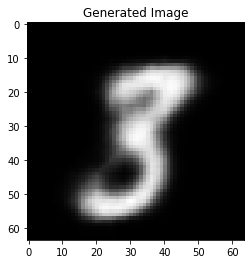

Epoch 351/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.72it/s]


Epoch [351/500], Loss: 63363.8672 (total loss), 59944.3789 (bce), 3419.4863 (kld)
Mu range: -1.4487460851669312 ~ 0.8417355418205261, Logvar range: -5.798824310302734 ~ -0.17559745907783508
tensor(4)


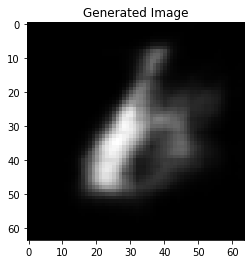

Epoch 352/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.04it/s]


Epoch [352/500], Loss: 66161.9062 (total loss), 62803.3516 (bce), 3358.5537 (kld)
Mu range: -1.773337483406067 ~ 1.7978233098983765, Logvar range: -6.966859817504883 ~ 0.06571990251541138
tensor(7)


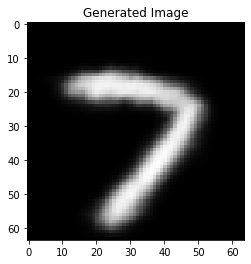

Epoch 353/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.51it/s]

Epoch [353/500], Loss: 68222.2969 (total loss), 64830.3125 (bce), 3391.9836 (kld)
Mu range: -1.8651165962219238 ~ 2.9812610149383545, Logvar range: -6.602290630340576 ~ -0.013763189315795898
tensor(7)


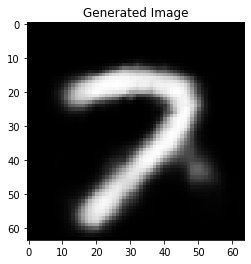

Epoch 354/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.53it/s]


Epoch [354/500], Loss: 66412.7109 (total loss), 62976.4375 (bce), 3436.2754 (kld)
Mu range: -1.9232102632522583 ~ 1.766516089439392, Logvar range: -5.618627071380615 ~ -0.22481006383895874
tensor(2)


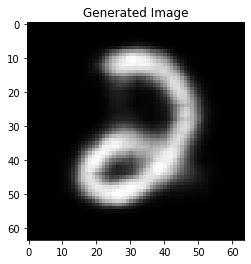

Epoch 355/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.38it/s]


Epoch [355/500], Loss: 63842.8906 (total loss), 60397.0859 (bce), 3445.8044 (kld)
Mu range: -1.5619208812713623 ~ 1.717870831489563, Logvar range: -6.704896450042725 ~ 0.2118580937385559
tensor(9)


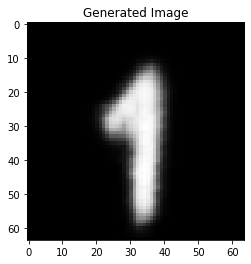

Epoch 356/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.74it/s]


Epoch [356/500], Loss: 65142.5312 (total loss), 61651.6406 (bce), 3490.8916 (kld)
Mu range: -1.5395889282226562 ~ 0.707344651222229, Logvar range: -6.188559055328369 ~ -0.10349303483963013
tensor(4)


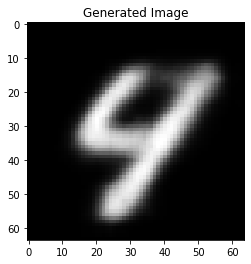

Epoch 357/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.00it/s]


Epoch [357/500], Loss: 65251.4609 (total loss), 61855.6875 (bce), 3395.7744 (kld)
Mu range: -2.4006154537200928 ~ 2.368981122970581, Logvar range: -6.513210296630859 ~ 0.045375704765319824
tensor(0)


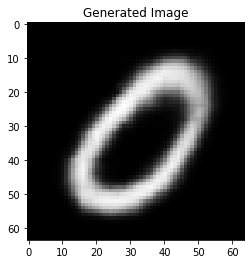

Epoch 358/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.49it/s]


Epoch [358/500], Loss: 66991.7734 (total loss), 63535.8867 (bce), 3455.8867 (kld)
Mu range: -1.212209701538086 ~ 0.9424501657485962, Logvar range: -5.615086555480957 ~ -0.20937460660934448
tensor(9)


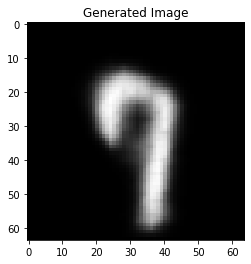

Epoch 359/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.59it/s]


Epoch [359/500], Loss: 64750.2266 (total loss), 61272.0859 (bce), 3478.1387 (kld)
Mu range: -1.77657949924469 ~ 1.6971639394760132, Logvar range: -6.281358242034912 ~ 0.09143036603927612
tensor(6)


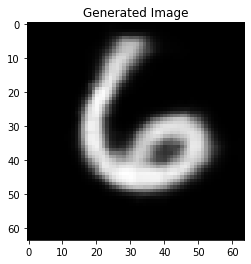

Epoch 360/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.44it/s]


Epoch [360/500], Loss: 68233.0859 (total loss), 64831.8398 (bce), 3401.2441 (kld)
Mu range: -1.9396121501922607 ~ 1.6115785837173462, Logvar range: -6.491433143615723 ~ 0.03946661949157715
tensor(9)


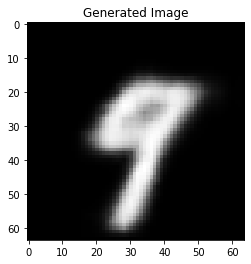

Epoch 361/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.49it/s]


Epoch [361/500], Loss: 62717.6250 (total loss), 59288.3906 (bce), 3429.2329 (kld)
Mu range: -2.2407870292663574 ~ 2.036496162414551, Logvar range: -7.020294189453125 ~ 0.21787667274475098
tensor(6)


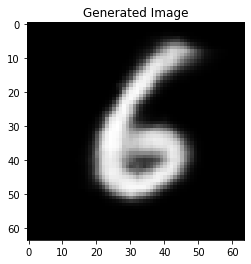

Epoch 362/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.57it/s]


Epoch [362/500], Loss: 63512.6719 (total loss), 60051.0938 (bce), 3461.5789 (kld)
Mu range: -1.7197129726409912 ~ 1.9361802339553833, Logvar range: -5.873600959777832 ~ -0.11628809571266174
tensor(9)


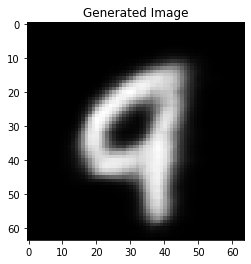

Epoch 363/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.84it/s]


Epoch [363/500], Loss: 66549.8984 (total loss), 63032.6914 (bce), 3517.2092 (kld)
Mu range: -1.2477494478225708 ~ 1.662433385848999, Logvar range: -6.139429569244385 ~ -0.2065173089504242
tensor(8)


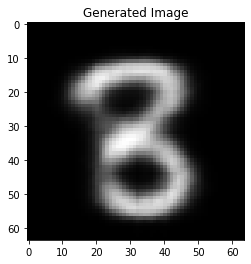

Epoch 364/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.68it/s]

Epoch [364/500], Loss: 62562.0352 (total loss), 59143.9141 (bce), 3418.1199 (kld)
Mu range: -3.0757148265838623 ~ 1.390573501586914, Logvar range: -6.867974281311035 ~ 0.004600822925567627
tensor(0)


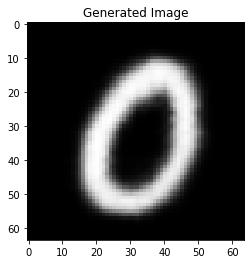

Epoch 365/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.69it/s]


Epoch [365/500], Loss: 65396.2617 (total loss), 61834.0859 (bce), 3562.1743 (kld)
Mu range: -0.717668890953064 ~ 1.634028434753418, Logvar range: -5.425149917602539 ~ -0.2800225615501404
tensor(2)


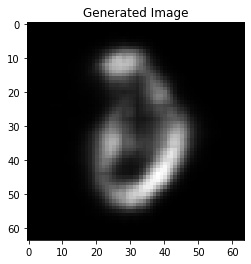

Epoch 366/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.61it/s]


Epoch [366/500], Loss: 65763.9062 (total loss), 62300.3516 (bce), 3463.5566 (kld)
Mu range: -1.184398889541626 ~ 1.6773319244384766, Logvar range: -6.3687591552734375 ~ -0.13679328560829163
tensor(9)


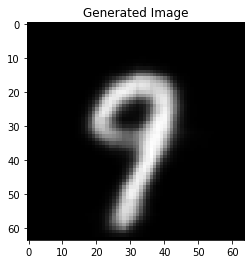

Epoch 367/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.76it/s]


Epoch [367/500], Loss: 66996.1406 (total loss), 63504.1992 (bce), 3491.9421 (kld)
Mu range: -2.956756353378296 ~ 3.15311861038208, Logvar range: -6.124212741851807 ~ 0.04678785800933838
tensor(0)


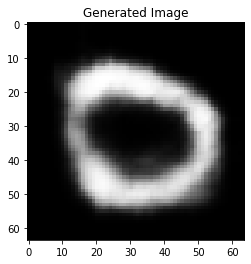

Epoch 368/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.93it/s]


Epoch [368/500], Loss: 64680.2305 (total loss), 61239.6484 (bce), 3440.5808 (kld)
Mu range: -1.020460844039917 ~ 2.0221123695373535, Logvar range: -6.559223651885986 ~ -0.0290774405002594
tensor(1)


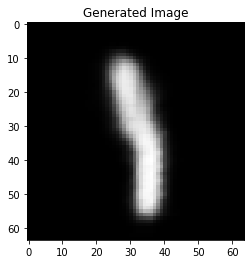

Epoch 369/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.69it/s]


Epoch [369/500], Loss: 66803.2422 (total loss), 63453.8047 (bce), 3349.4365 (kld)
Mu range: -0.8068250417709351 ~ 1.009633183479309, Logvar range: -5.197386264801025 ~ -0.2900913655757904
tensor(1)


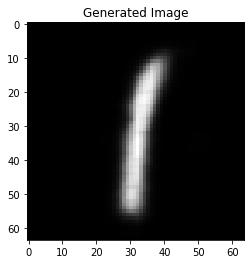

Epoch 370/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.48it/s]


Epoch [370/500], Loss: 64075.6641 (total loss), 60569.2305 (bce), 3506.4331 (kld)
Mu range: -0.6957979202270508 ~ 1.1163467168807983, Logvar range: -5.013789653778076 ~ -0.352215975522995
tensor(2)


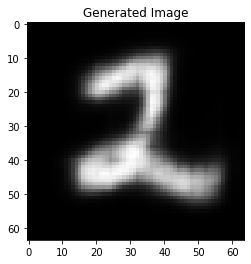

Epoch 371/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.53it/s]

Epoch [371/500], Loss: 63571.2969 (total loss), 60086.4062 (bce), 3484.8887 (kld)
Mu range: -4.0406694412231445 ~ 2.786670446395874, Logvar range: -6.155733108520508 ~ 0.045041412115097046
tensor(0)


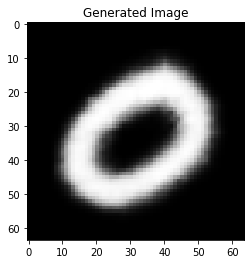

Epoch 372/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.66it/s]


Epoch [372/500], Loss: 62756.1289 (total loss), 59202.8594 (bce), 3553.2688 (kld)
Mu range: -1.5066455602645874 ~ 1.1511338949203491, Logvar range: -5.852916240692139 ~ -0.15498054027557373
tensor(6)


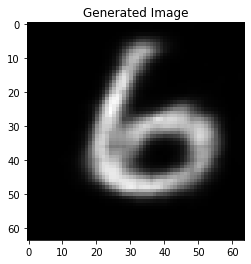

Epoch 373/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.77it/s]

Epoch [373/500], Loss: 69352.5156 (total loss), 65976.8438 (bce), 3375.6680 (kld)
Mu range: -1.656558871269226 ~ 2.7810819149017334, Logvar range: -6.9780049324035645 ~ 0.10695472359657288
tensor(4)


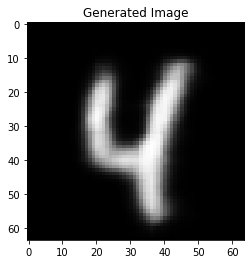

Epoch 374/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.62it/s]


Epoch [374/500], Loss: 64651.5586 (total loss), 61194.6250 (bce), 3456.9331 (kld)
Mu range: -0.9059019088745117 ~ 2.246328592300415, Logvar range: -5.787732124328613 ~ -0.1647912561893463
tensor(3)


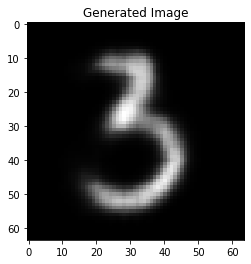

Epoch 375/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.44it/s]


Epoch [375/500], Loss: 66109.8984 (total loss), 62686.7461 (bce), 3423.1519 (kld)
Mu range: -1.34321928024292 ~ 2.375903367996216, Logvar range: -5.887663841247559 ~ -0.15861940383911133
tensor(5)


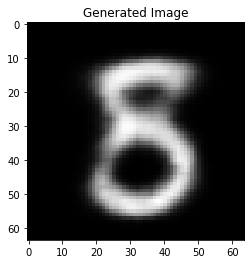

Epoch 376/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.51it/s]


Epoch [376/500], Loss: 66811.8672 (total loss), 63304.0391 (bce), 3507.8267 (kld)
Mu range: -1.9877123832702637 ~ 1.2051186561584473, Logvar range: -5.846767425537109 ~ -0.12353515625
tensor(8)


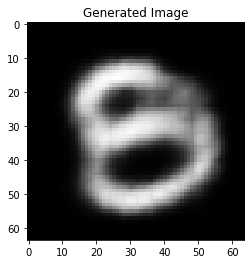

Epoch 377/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.71it/s]


Epoch [377/500], Loss: 67574.8203 (total loss), 64224.9375 (bce), 3349.8840 (kld)
Mu range: -1.5619703531265259 ~ 1.6848634481430054, Logvar range: -7.181680679321289 ~ 0.043746113777160645
tensor(5)


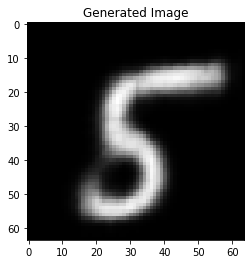

Epoch 378/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.20it/s]


Epoch [378/500], Loss: 63409.2578 (total loss), 59975.9062 (bce), 3433.3535 (kld)
Mu range: -3.6901066303253174 ~ 2.2699224948883057, Logvar range: -5.323324203491211 ~ -0.2236350178718567
tensor(0)


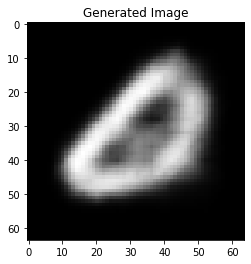

Epoch 379/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.74it/s]


Epoch [379/500], Loss: 67618.6562 (total loss), 64224.1172 (bce), 3394.5352 (kld)
Mu range: -1.7761976718902588 ~ 1.7789413928985596, Logvar range: -6.434614658355713 ~ -0.07565155625343323
tensor(5)


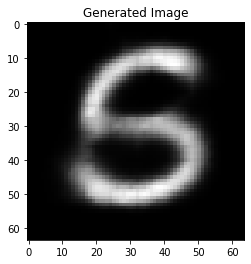

Epoch 380/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.43it/s]


Epoch [380/500], Loss: 67843.7969 (total loss), 64427.8828 (bce), 3415.9146 (kld)
Mu range: -1.9407496452331543 ~ 0.9797443151473999, Logvar range: -6.854641914367676 ~ 0.027837127447128296
tensor(9)


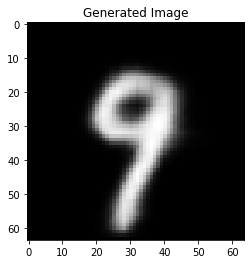

Epoch 381/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.25it/s]


Epoch [381/500], Loss: 67420.4844 (total loss), 64007.4805 (bce), 3413.0005 (kld)
Mu range: -1.2893582582473755 ~ 0.828515350818634, Logvar range: -5.333798408508301 ~ -0.2422027438879013
tensor(7)


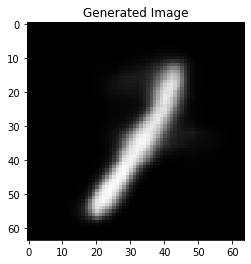

Epoch 382/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.41it/s]


Epoch [382/500], Loss: 64270.2266 (total loss), 60880.5078 (bce), 3389.7168 (kld)
Mu range: -1.9984748363494873 ~ 1.9895118474960327, Logvar range: -6.220695972442627 ~ -0.1114896833896637
tensor(3)


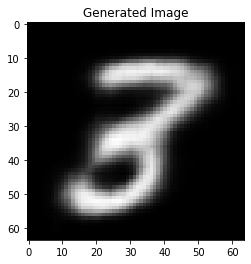

Epoch 383/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.91it/s]


Epoch [383/500], Loss: 65578.7031 (total loss), 62136.2852 (bce), 3442.4160 (kld)
Mu range: -2.3965659141540527 ~ 2.842013359069824, Logvar range: -6.472378253936768 ~ -0.054671794176101685
tensor(5)


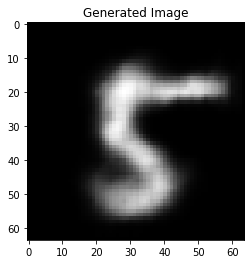

Epoch 384/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.56it/s]


Epoch [384/500], Loss: 64026.0664 (total loss), 60626.6250 (bce), 3399.4419 (kld)
Mu range: -1.9105117321014404 ~ 2.649381399154663, Logvar range: -5.906396865844727 ~ -0.13485649228096008
tensor(6)


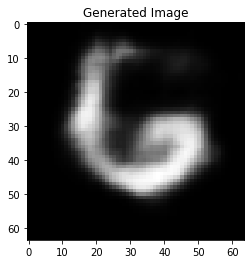

Epoch 385/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.68it/s]


Epoch [385/500], Loss: 65793.3047 (total loss), 62279.3633 (bce), 3513.9412 (kld)
Mu range: -2.0770294666290283 ~ 1.390545129776001, Logvar range: -5.986480236053467 ~ -0.09781721234321594
tensor(6)


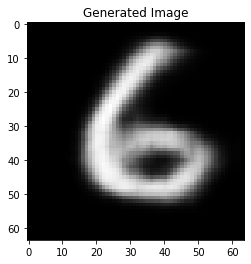

Epoch 386/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.69it/s]


Epoch [386/500], Loss: 63011.7539 (total loss), 59631.4062 (bce), 3380.3464 (kld)
Mu range: -2.2980964183807373 ~ 1.8708832263946533, Logvar range: -6.479427337646484 ~ -0.08133843541145325
tensor(7)


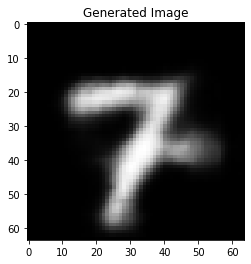

Epoch 387/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.78it/s]


Epoch [387/500], Loss: 65055.9141 (total loss), 61656.0625 (bce), 3399.8535 (kld)
Mu range: -1.5826919078826904 ~ 4.405672550201416, Logvar range: -5.979699611663818 ~ -0.07195520401000977
tensor(3)


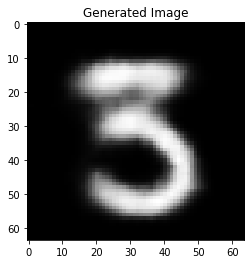

Epoch 388/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.67it/s]

Epoch [388/500], Loss: 68259.8359 (total loss), 64790.0469 (bce), 3469.7856 (kld)
Mu range: -3.4418740272521973 ~ 3.836604356765747, Logvar range: -6.8041205406188965 ~ 0.04333662986755371
tensor(2)


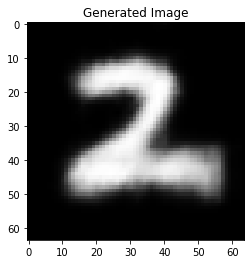

Epoch 389/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.96it/s]


Epoch [389/500], Loss: 63592.8164 (total loss), 60081.6523 (bce), 3511.1626 (kld)
Mu range: -1.8160935640335083 ~ 1.2431516647338867, Logvar range: -6.262533187866211 ~ -0.05371496081352234
tensor(9)


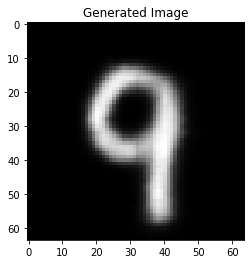

Epoch 390/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.04it/s]


Epoch [390/500], Loss: 61406.4453 (total loss), 57938.9297 (bce), 3467.5171 (kld)
Mu range: -1.6535223722457886 ~ 1.6824884414672852, Logvar range: -6.1541876792907715 ~ -0.0434643030166626
tensor(6)


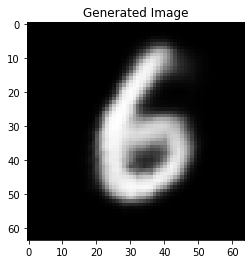

Epoch 391/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.59it/s]

Epoch [391/500], Loss: 66009.8594 (total loss), 62396.7148 (bce), 3613.1414 (kld)
Mu range: -2.1721153259277344 ~ 1.553446888923645, Logvar range: -6.59503173828125 ~ -0.01963663101196289
tensor(7)


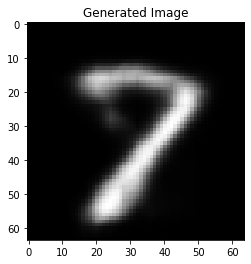

Epoch 392/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.65it/s]


Epoch [392/500], Loss: 64880.4453 (total loss), 61497.6094 (bce), 3382.8369 (kld)
Mu range: -0.9123038053512573 ~ 1.6584465503692627, Logvar range: -6.356449604034424 ~ -0.028573572635650635
tensor(1)


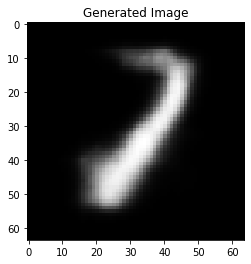

Epoch 393/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.46it/s]


Epoch [393/500], Loss: 65946.7500 (total loss), 62508.1641 (bce), 3438.5845 (kld)
Mu range: -2.3089535236358643 ~ 1.8623366355895996, Logvar range: -6.9524736404418945 ~ 0.021237313747406006
tensor(8)


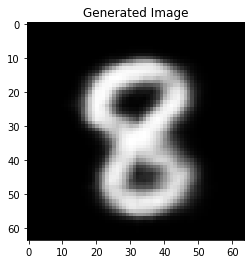

Epoch 394/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.69it/s]


Epoch [394/500], Loss: 62015.0781 (total loss), 58483.3750 (bce), 3531.7026 (kld)
Mu range: -1.202604055404663 ~ 1.8267686367034912, Logvar range: -6.188809394836426 ~ -0.07336527109146118
tensor(2)


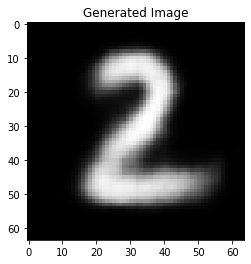

Epoch 395/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.11it/s]


Epoch [395/500], Loss: 65651.0547 (total loss), 62067.8359 (bce), 3583.2163 (kld)
Mu range: -3.4893245697021484 ~ 2.5293514728546143, Logvar range: -6.250877380371094 ~ -0.1385001540184021
tensor(5)


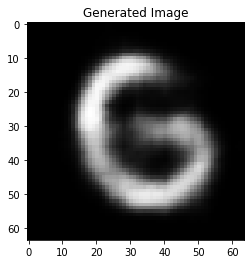

Epoch 396/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.69it/s]


Epoch [396/500], Loss: 67708.7266 (total loss), 64251.1484 (bce), 3457.5771 (kld)
Mu range: -0.5563575029373169 ~ 0.7549191117286682, Logvar range: -5.075785160064697 ~ -0.30236199498176575
tensor(8)


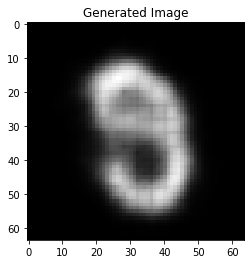

Epoch 397/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.45it/s]

Epoch [397/500], Loss: 62855.3906 (total loss), 59394.6172 (bce), 3460.7754 (kld)
Mu range: -1.1322622299194336 ~ 1.6530649662017822, Logvar range: -6.188473701477051 ~ -0.025236696004867554
tensor(1)


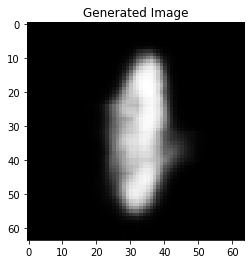

Epoch 398/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.69it/s]


Epoch [398/500], Loss: 65926.4453 (total loss), 62509.7227 (bce), 3416.7244 (kld)
Mu range: -1.3975470066070557 ~ 2.0328924655914307, Logvar range: -5.46516752243042 ~ -0.2058699131011963
tensor(2)


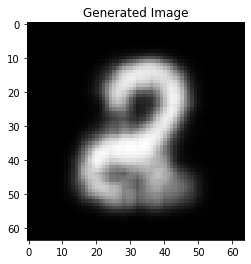

Epoch 399/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.60it/s]

Epoch [399/500], Loss: 60981.7969 (total loss), 57322.3047 (bce), 3659.4907 (kld)
Mu range: -2.2823901176452637 ~ 4.632067680358887, Logvar range: -6.579382419586182 ~ 0.0673951804637909
tensor(5)


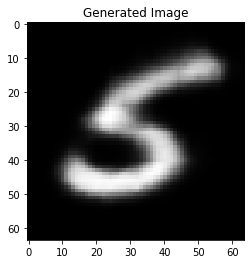

Epoch 400/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.74it/s]


Epoch [400/500], Loss: 64508.1016 (total loss), 61013.4805 (bce), 3494.6206 (kld)
Mu range: -0.7409101128578186 ~ 1.6882256269454956, Logvar range: -5.9910478591918945 ~ -0.1293160617351532
tensor(2)


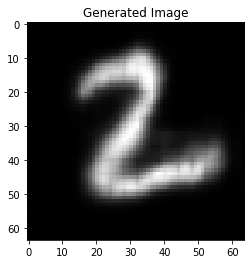

Epoch 401/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.61it/s]

Epoch [401/500], Loss: 67369.2422 (total loss), 63863.3633 (bce), 3505.8770 (kld)
Mu range: -0.6920574903488159 ~ 2.8166913986206055, Logvar range: -6.103794097900391 ~ -0.004411488771438599
tensor(3)


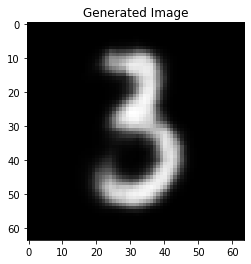

Epoch 402/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.68it/s]


Epoch [402/500], Loss: 62812.3125 (total loss), 59333.8281 (bce), 3478.4858 (kld)
Mu range: -1.0004801750183105 ~ 1.2490026950836182, Logvar range: -5.095495223999023 ~ -0.23753826320171356
tensor(6)


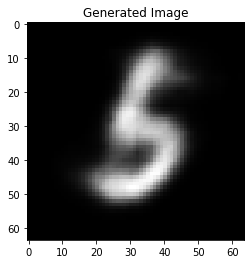

Epoch 403/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.64it/s]

Epoch [403/500], Loss: 66394.7188 (total loss), 62912.7461 (bce), 3481.9705 (kld)
Mu range: -1.029258131980896 ~ 1.0621463060379028, Logvar range: -5.6084465980529785 ~ -0.16700543463230133
tensor(6)


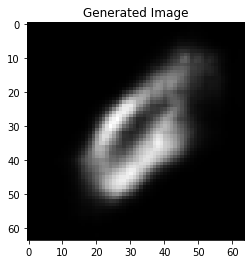

Epoch 404/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.57it/s]


Epoch [404/500], Loss: 67646.5859 (total loss), 64225.6133 (bce), 3420.9749 (kld)
Mu range: -1.2432307004928589 ~ 1.637302041053772, Logvar range: -5.72605037689209 ~ -0.12742090225219727
tensor(6)


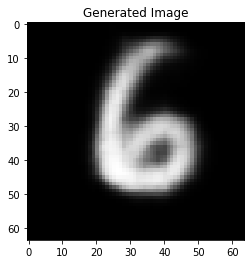

Epoch 405/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.66it/s]

Epoch [405/500], Loss: 64587.1094 (total loss), 61144.3477 (bce), 3442.7634 (kld)
Mu range: -2.100633144378662 ~ 2.4785890579223633, Logvar range: -5.763332843780518 ~ 0.004643619060516357
tensor(5)


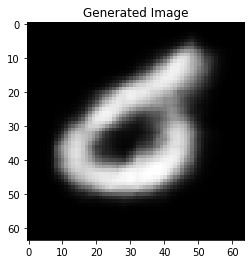

Epoch 406/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.31it/s]


Epoch [406/500], Loss: 63364.7969 (total loss), 59858.0430 (bce), 3506.7554 (kld)
Mu range: -1.752301573753357 ~ 1.2634046077728271, Logvar range: -6.444915771484375 ~ -0.04480656981468201
tensor(9)


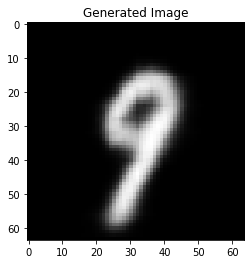

Epoch 407/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.85it/s]


Epoch [407/500], Loss: 68187.1953 (total loss), 64632.3125 (bce), 3554.8816 (kld)
Mu range: -2.1608314514160156 ~ 3.1049656867980957, Logvar range: -6.758790016174316 ~ 0.04132044315338135
tensor(5)


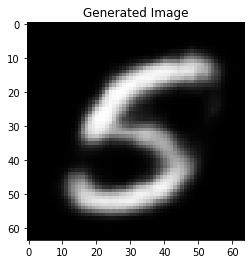

Epoch 408/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.04it/s]


Epoch [408/500], Loss: 66208.8438 (total loss), 62743.6406 (bce), 3465.2056 (kld)
Mu range: -0.8431100249290466 ~ 1.3990240097045898, Logvar range: -5.832345962524414 ~ -0.14417459070682526
tensor(8)


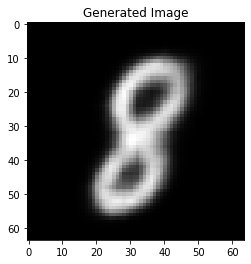

Epoch 409/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.67it/s]


Epoch [409/500], Loss: 64216.3945 (total loss), 60694.5898 (bce), 3521.8052 (kld)
Mu range: -4.048537254333496 ~ 2.858607053756714, Logvar range: -6.560788631439209 ~ 0.002443760633468628
tensor(9)


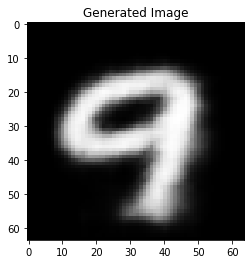

Epoch 410/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.50it/s]


Epoch [410/500], Loss: 65821.4766 (total loss), 62427.8516 (bce), 3393.6228 (kld)
Mu range: -2.4444382190704346 ~ 2.093893527984619, Logvar range: -6.32119083404541 ~ -0.07093268632888794
tensor(5)


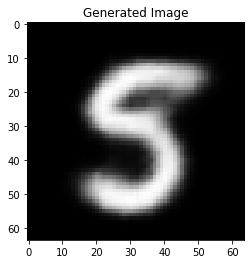

Epoch 411/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.70it/s]


Epoch [411/500], Loss: 62344.9336 (total loss), 58819.9141 (bce), 3525.0188 (kld)
Mu range: -2.2852118015289307 ~ 0.8448091149330139, Logvar range: -6.088952541351318 ~ -0.04446163773536682
tensor(4)


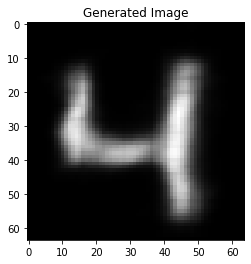

Epoch 412/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.67it/s]


Epoch [412/500], Loss: 65638.6797 (total loss), 62253.4141 (bce), 3385.2688 (kld)
Mu range: -3.0108118057250977 ~ 1.27985417842865, Logvar range: -6.276227951049805 ~ -0.0898180603981018
tensor(7)


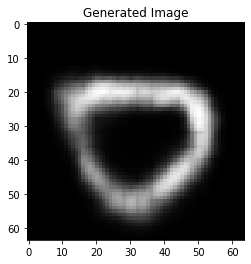

Epoch 413/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.88it/s]


Epoch [413/500], Loss: 71748.9453 (total loss), 68367.0938 (bce), 3381.8530 (kld)
Mu range: -1.621402621269226 ~ 1.7611110210418701, Logvar range: -5.4986395835876465 ~ -0.1554473340511322
tensor(6)


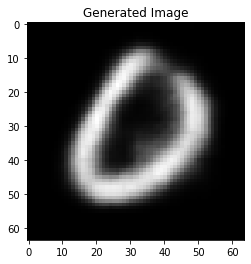

Epoch 414/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.04it/s]


Epoch [414/500], Loss: 65871.3594 (total loss), 62414.3828 (bce), 3456.9727 (kld)
Mu range: -1.76841402053833 ~ 2.8611321449279785, Logvar range: -5.395308971405029 ~ -0.025178968906402588
tensor(0)


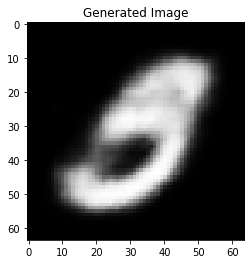

Epoch 415/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.76it/s]


Epoch [415/500], Loss: 68078.0156 (total loss), 64615.7969 (bce), 3462.2183 (kld)
Mu range: -1.728666067123413 ~ 1.6101653575897217, Logvar range: -6.289819240570068 ~ 0.015393316745758057
tensor(7)


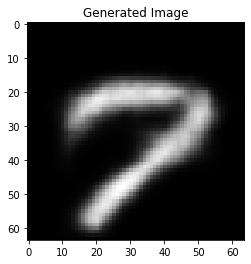

Epoch 416/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.72it/s]

Epoch [416/500], Loss: 66010.2344 (total loss), 62552.3711 (bce), 3457.8633 (kld)
Mu range: -0.7382551431655884 ~ 1.293778896331787, Logvar range: -5.235522747039795 ~ -0.22047799825668335
tensor(3)


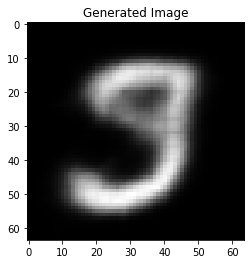

Epoch 417/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.72it/s]


Epoch [417/500], Loss: 61827.3594 (total loss), 58317.2969 (bce), 3510.0605 (kld)
Mu range: -0.8097224235534668 ~ 1.306441307067871, Logvar range: -6.283939361572266 ~ -0.10185900330543518
tensor(5)


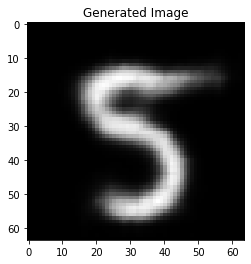

Epoch 418/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.99it/s]


Epoch [418/500], Loss: 67438.6094 (total loss), 64096.1836 (bce), 3342.4229 (kld)
Mu range: -1.0979288816452026 ~ 1.9565527439117432, Logvar range: -5.886962890625 ~ -0.13347935676574707
tensor(3)


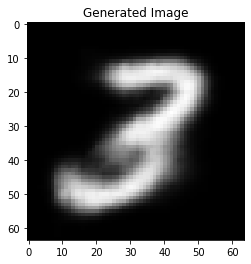

Epoch 419/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.01it/s]


Epoch [419/500], Loss: 62200.6367 (total loss), 58778.9258 (bce), 3421.7114 (kld)
Mu range: -1.3104562759399414 ~ 4.248748302459717, Logvar range: -6.825675964355469 ~ 0.13015824556350708
tensor(6)


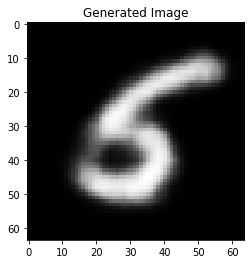

Epoch 420/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.24it/s]

Epoch [420/500], Loss: 66238.0547 (total loss), 62681.0156 (bce), 3557.0405 (kld)
Mu range: -2.6815221309661865 ~ 1.3215807676315308, Logvar range: -7.372549057006836 ~ 0.09604349732398987
tensor(4)


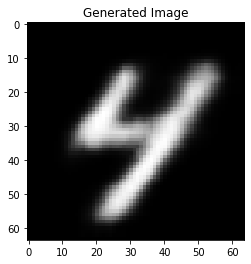

Epoch 421/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.79it/s]


Epoch [421/500], Loss: 61767.2188 (total loss), 58366.6406 (bce), 3400.5774 (kld)
Mu range: -1.4917891025543213 ~ 2.1490931510925293, Logvar range: -6.404611110687256 ~ 0.0016531050205230713
tensor(1)


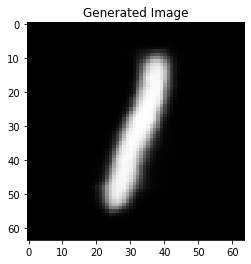

Epoch 422/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.36it/s]


Epoch [422/500], Loss: 65984.9453 (total loss), 62582.0586 (bce), 3402.8848 (kld)
Mu range: -1.3642444610595703 ~ 1.4595324993133545, Logvar range: -5.934858322143555 ~ -0.10123831033706665
tensor(6)


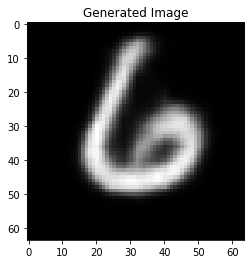

Epoch 423/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.44it/s]


Epoch [423/500], Loss: 63376.4531 (total loss), 59925.3125 (bce), 3451.1389 (kld)
Mu range: -1.61326265335083 ~ 1.6455583572387695, Logvar range: -6.336239337921143 ~ -0.014900773763656616
tensor(7)


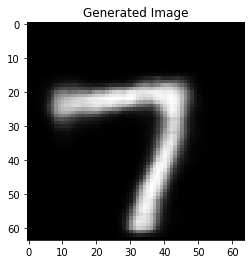

Epoch 424/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.63it/s]


Epoch [424/500], Loss: 64599.7734 (total loss), 61054.8984 (bce), 3544.8760 (kld)
Mu range: -1.6471002101898193 ~ 2.122755765914917, Logvar range: -5.784660339355469 ~ -0.11516405642032623
tensor(0)


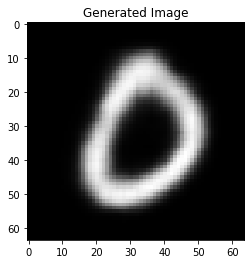

Epoch 425/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.42it/s]

Epoch [425/500], Loss: 62947.8438 (total loss), 59553.9609 (bce), 3393.8818 (kld)
Mu range: -2.20420503616333 ~ 1.654693603515625, Logvar range: -6.746884346008301 ~ 0.03644883632659912
tensor(6)


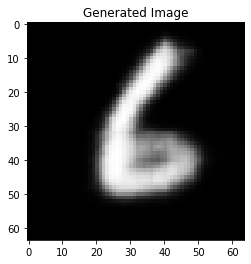

Epoch 426/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.92it/s]


Epoch [426/500], Loss: 64986.1445 (total loss), 61485.5664 (bce), 3500.5796 (kld)
Mu range: -1.0529356002807617 ~ 0.8692497611045837, Logvar range: -5.888179302215576 ~ -0.11776094138622284
tensor(3)


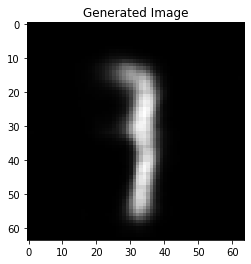

Epoch 427/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.54it/s]


Epoch [427/500], Loss: 64452.4805 (total loss), 60900.6562 (bce), 3551.8252 (kld)
Mu range: -1.3126375675201416 ~ 1.1837573051452637, Logvar range: -6.246546268463135 ~ -0.03924894332885742
tensor(9)


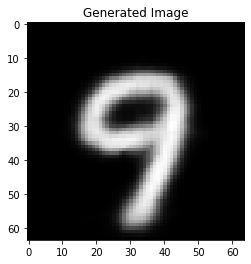

Epoch 428/500: 100%|██████████████████████████| 118/118 [00:11<00:00,  9.87it/s]


Epoch [428/500], Loss: 65524.8945 (total loss), 62143.6172 (bce), 3381.2769 (kld)
Mu range: -2.1567676067352295 ~ 1.6977113485336304, Logvar range: -6.838133335113525 ~ 0.026648402214050293
tensor(9)


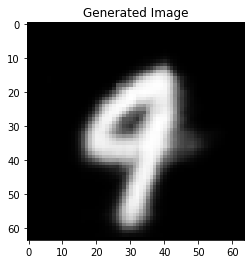

Epoch 429/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.30it/s]


Epoch [429/500], Loss: 64450.2070 (total loss), 61076.4453 (bce), 3373.7600 (kld)
Mu range: -2.35037899017334 ~ 2.2326159477233887, Logvar range: -5.808906555175781 ~ -0.09987549483776093
tensor(2)


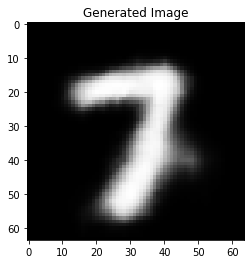

Epoch 430/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.21it/s]

Epoch [430/500], Loss: 65920.1406 (total loss), 62509.3203 (bce), 3410.8232 (kld)
Mu range: -0.740275502204895 ~ 0.8836528062820435, Logvar range: -5.396224021911621 ~ -0.20914578437805176
tensor(8)


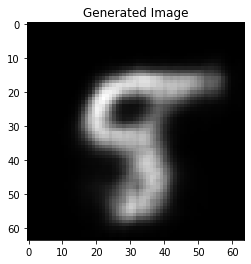

Epoch 431/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.69it/s]


Epoch [431/500], Loss: 65891.6875 (total loss), 62448.0391 (bce), 3443.6494 (kld)
Mu range: -1.9062609672546387 ~ 3.1678502559661865, Logvar range: -6.831007957458496 ~ 0.003527045249938965
tensor(2)


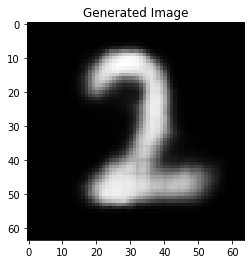

Epoch 432/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.71it/s]

Epoch [432/500], Loss: 65226.1641 (total loss), 61804.3320 (bce), 3421.8330 (kld)
Mu range: -3.572199821472168 ~ 0.9018810987472534, Logvar range: -6.915439605712891 ~ 0.02618733048439026
tensor(4)


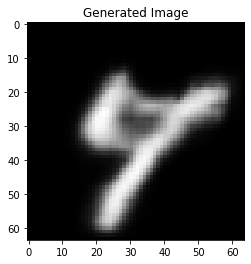

Epoch 433/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.76it/s]


Epoch [433/500], Loss: 60752.8750 (total loss), 57177.6875 (bce), 3575.1865 (kld)
Mu range: -2.164613723754883 ~ 2.7508697509765625, Logvar range: -7.103125095367432 ~ 0.04225313663482666
tensor(7)


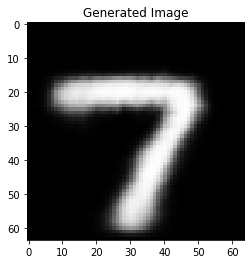

Epoch 434/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.90it/s]


Epoch [434/500], Loss: 64909.3555 (total loss), 61444.9336 (bce), 3464.4224 (kld)
Mu range: -0.8063133955001831 ~ 0.8801697492599487, Logvar range: -5.090658187866211 ~ -0.2183184027671814
tensor(7)


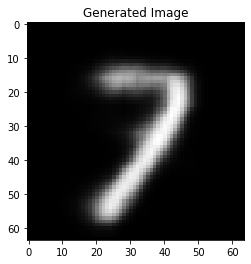

Epoch 435/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.43it/s]


Epoch [435/500], Loss: 64706.8242 (total loss), 61305.9805 (bce), 3400.8438 (kld)
Mu range: -0.7529079914093018 ~ 1.5146080255508423, Logvar range: -6.166708469390869 ~ -0.09461499750614166
tensor(8)


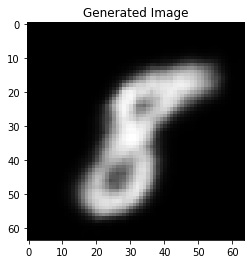

Epoch 436/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.68it/s]


Epoch [436/500], Loss: 67570.4062 (total loss), 64044.0625 (bce), 3526.3438 (kld)
Mu range: -1.3363656997680664 ~ 1.7956582307815552, Logvar range: -6.398365020751953 ~ -0.05982327461242676
tensor(4)


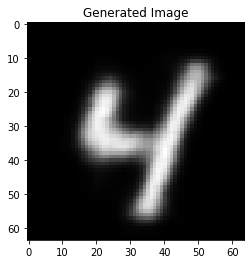

Epoch 437/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.59it/s]


Epoch [437/500], Loss: 64816.9648 (total loss), 61343.5312 (bce), 3473.4336 (kld)
Mu range: -1.6563739776611328 ~ 1.718664526939392, Logvar range: -6.22659969329834 ~ -0.07284066081047058
tensor(7)


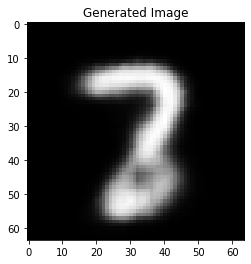

Epoch 438/500: 100%|██████████████████████████| 118/118 [00:09<00:00, 12.07it/s]


Epoch [438/500], Loss: 65725.2891 (total loss), 62381.8789 (bce), 3343.4077 (kld)
Mu range: -0.7445996999740601 ~ 0.864457368850708, Logvar range: -5.38950777053833 ~ -0.21120429039001465
tensor(9)


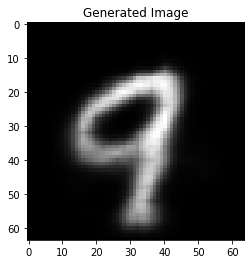

Epoch 439/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.53it/s]

Epoch [439/500], Loss: 67056.8750 (total loss), 63601.1094 (bce), 3455.7695 (kld)
Mu range: -1.042170524597168 ~ 1.6281542778015137, Logvar range: -6.078026294708252 ~ -0.022814631462097168
tensor(5)


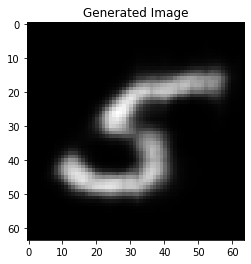

Epoch 440/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.71it/s]


Epoch [440/500], Loss: 66693.0469 (total loss), 63237.5156 (bce), 3455.5352 (kld)
Mu range: -1.2994117736816406 ~ 1.9647175073623657, Logvar range: -5.285165786743164 ~ -0.12296821177005768
tensor(2)


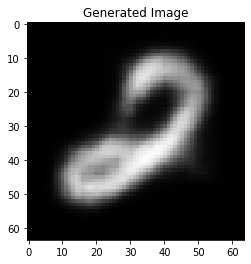

Epoch 441/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.45it/s]


Epoch [441/500], Loss: 64978.5391 (total loss), 61569.2734 (bce), 3409.2661 (kld)
Mu range: -1.3279156684875488 ~ 1.4829312562942505, Logvar range: -6.352169036865234 ~ -0.06300581991672516
tensor(8)


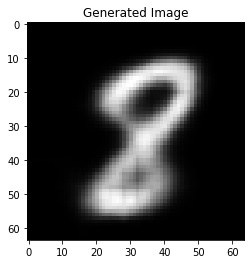

Epoch 442/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.76it/s]


Epoch [442/500], Loss: 64103.5938 (total loss), 60588.8945 (bce), 3514.6992 (kld)
Mu range: -1.008642315864563 ~ 1.8064683675765991, Logvar range: -5.685965061187744 ~ -0.11033694446086884
tensor(6)


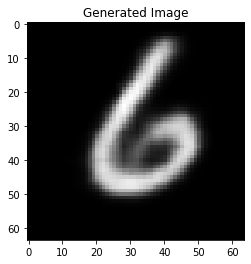

Epoch 443/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.61it/s]


Epoch [443/500], Loss: 61959.3359 (total loss), 58512.4492 (bce), 3446.8860 (kld)
Mu range: -3.169607639312744 ~ 0.9962846040725708, Logvar range: -6.347232818603516 ~ 0.011545836925506592
tensor(4)


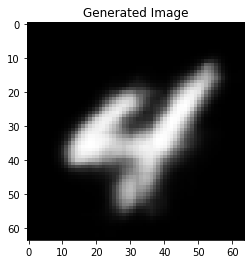

Epoch 444/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.39it/s]

Epoch [444/500], Loss: 64669.5586 (total loss), 61239.7500 (bce), 3429.8074 (kld)
Mu range: -1.804884433746338 ~ 1.5167105197906494, Logvar range: -6.115447998046875 ~ 0.039593249559402466
tensor(4)


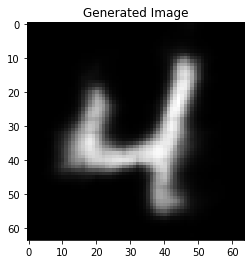

Epoch 445/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.19it/s]

Epoch [445/500], Loss: 64972.2539 (total loss), 61442.7344 (bce), 3529.5186 (kld)
Mu range: -2.5053939819335938 ~ 1.699692726135254, Logvar range: -6.9912261962890625 ~ 0.06241387128829956
tensor(1)


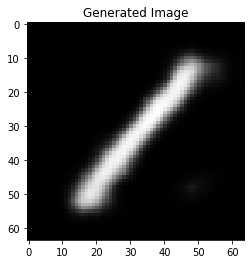

Epoch 446/500: 100%|██████████████████████████| 118/118 [00:09<00:00, 11.80it/s]


Epoch [446/500], Loss: 63525.4727 (total loss), 59871.1602 (bce), 3654.3130 (kld)
Mu range: -1.1755576133728027 ~ 1.2962391376495361, Logvar range: -5.850005626678467 ~ -0.11464941501617432
tensor(1)


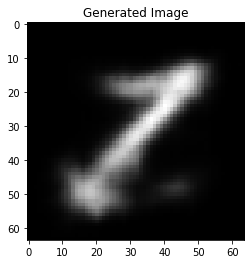

Epoch 447/500: 100%|██████████████████████████| 118/118 [00:09<00:00, 11.85it/s]


Epoch [447/500], Loss: 62487.4844 (total loss), 59018.9141 (bce), 3468.5703 (kld)
Mu range: -1.1277035474777222 ~ 2.8257060050964355, Logvar range: -7.087109088897705 ~ 0.16695266962051392
tensor(1)


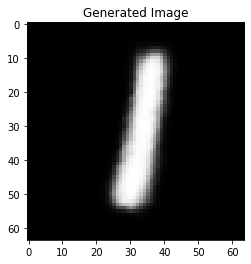

Epoch 448/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.72it/s]


Epoch [448/500], Loss: 62082.0977 (total loss), 58608.9531 (bce), 3473.1431 (kld)
Mu range: -1.755728006362915 ~ 1.7553410530090332, Logvar range: -5.976688385009766 ~ -0.034715622663497925
tensor(2)


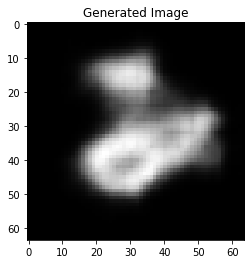

Epoch 449/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.68it/s]


Epoch [449/500], Loss: 65459.4219 (total loss), 62022.2852 (bce), 3437.1348 (kld)
Mu range: -0.9425538778305054 ~ 0.8807163238525391, Logvar range: -5.802618026733398 ~ -0.11697965860366821
tensor(9)


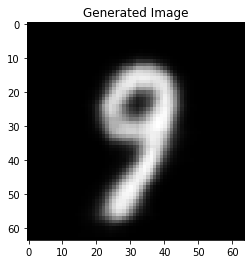

Epoch 450/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.44it/s]


Epoch [450/500], Loss: 64602.9648 (total loss), 61196.3672 (bce), 3406.5962 (kld)
Mu range: -1.9363739490509033 ~ 2.7734527587890625, Logvar range: -7.010950088500977 ~ 0.09982374310493469
tensor(6)


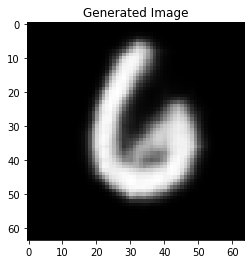

Epoch 451/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.81it/s]


Epoch [451/500], Loss: 67331.8906 (total loss), 63932.3359 (bce), 3399.5532 (kld)
Mu range: -2.1996583938598633 ~ 2.897101402282715, Logvar range: -6.077340602874756 ~ -0.06531566381454468
tensor(0)


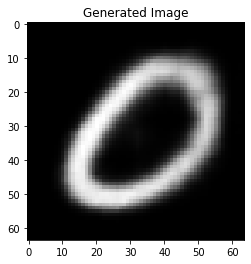

Epoch 452/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.26it/s]


Epoch [452/500], Loss: 61499.8477 (total loss), 58023.9844 (bce), 3475.8628 (kld)
Mu range: -1.1311185359954834 ~ 1.2068817615509033, Logvar range: -6.137060642242432 ~ -0.09387466311454773
tensor(5)


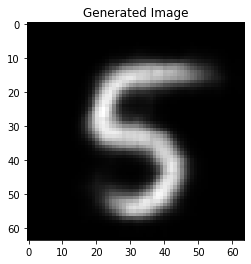

Epoch 453/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.27it/s]

Epoch [453/500], Loss: 64001.9648 (total loss), 60661.3281 (bce), 3340.6367 (kld)
Mu range: -1.8413978815078735 ~ 2.6317858695983887, Logvar range: -5.6960554122924805 ~ -0.05240143835544586
tensor(6)


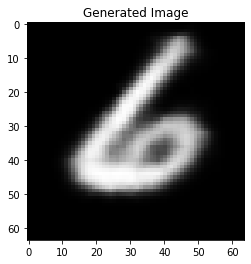

Epoch 454/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.66it/s]

Epoch [454/500], Loss: 65427.9688 (total loss), 61874.8438 (bce), 3553.1252 (kld)
Mu range: -2.6159863471984863 ~ 1.4552738666534424, Logvar range: -5.986207962036133 ~ -0.03481878340244293
tensor(2)


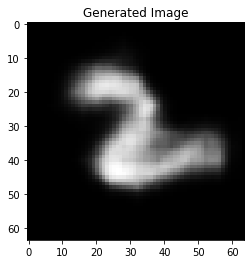

Epoch 455/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.40it/s]


Epoch [455/500], Loss: 65170.3906 (total loss), 61762.8945 (bce), 3407.4961 (kld)
Mu range: -0.6894909143447876 ~ 1.4971826076507568, Logvar range: -6.441389083862305 ~ -0.04726409912109375
tensor(1)


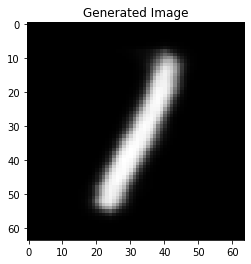

Epoch 456/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.55it/s]


Epoch [456/500], Loss: 65298.5547 (total loss), 61724.0938 (bce), 3574.4622 (kld)
Mu range: -3.0098657608032227 ~ 1.4757065773010254, Logvar range: -6.455936431884766 ~ 0.017216861248016357
tensor(8)


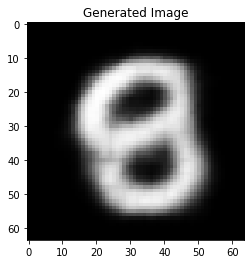

Epoch 457/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.92it/s]

Epoch [457/500], Loss: 68907.8203 (total loss), 65435.1797 (bce), 3472.6387 (kld)
Mu range: -2.397744655609131 ~ 0.7867245078086853, Logvar range: -6.732991695404053 ~ 0.014133304357528687
tensor(7)


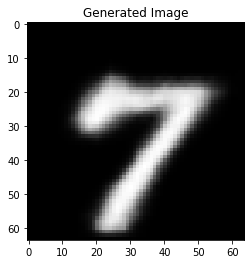

Epoch 458/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.39it/s]

Epoch [458/500], Loss: 65071.0039 (total loss), 61612.1523 (bce), 3458.8533 (kld)
Mu range: -1.221250295639038 ~ 1.8190762996673584, Logvar range: -6.3523149490356445 ~ -0.049637630581855774
tensor(1)


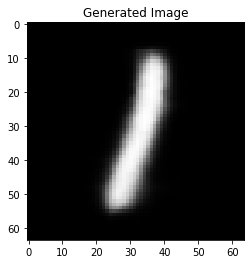

Epoch 459/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.75it/s]

Epoch [459/500], Loss: 65094.5625 (total loss), 61669.3047 (bce), 3425.2563 (kld)
Mu range: -1.0678908824920654 ~ 1.5483171939849854, Logvar range: -6.437328338623047 ~ 0.021115601062774658
tensor(1)


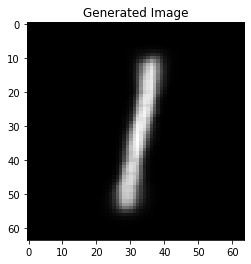

Epoch 460/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.08it/s]


Epoch [460/500], Loss: 65564.1016 (total loss), 62045.6719 (bce), 3518.4307 (kld)
Mu range: -2.076916456222534 ~ 1.1233149766921997, Logvar range: -6.103320598602295 ~ -0.04383312165737152
tensor(0)


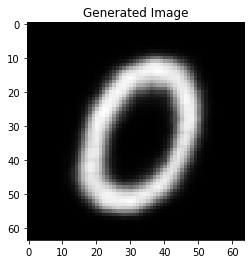

Epoch 461/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.50it/s]

Epoch [461/500], Loss: 61101.3984 (total loss), 57701.3398 (bce), 3400.0581 (kld)
Mu range: -3.2891108989715576 ~ 1.8511449098587036, Logvar range: -7.0893025398254395 ~ 0.004409998655319214
tensor(7)


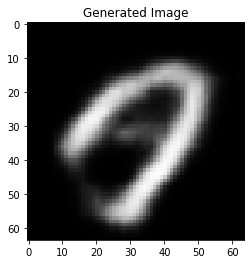

Epoch 462/500: 100%|██████████████████████████| 118/118 [00:11<00:00,  9.87it/s]


Epoch [462/500], Loss: 65440.0078 (total loss), 62023.8828 (bce), 3416.1267 (kld)
Mu range: -2.6563167572021484 ~ 1.7131998538970947, Logvar range: -5.5539398193359375 ~ -0.10224387049674988
tensor(0)


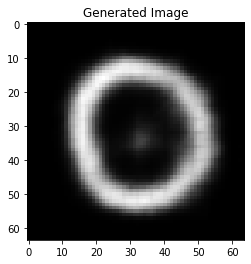

Epoch 463/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.79it/s]


Epoch [463/500], Loss: 63749.9180 (total loss), 60243.9922 (bce), 3505.9275 (kld)
Mu range: -2.3353047370910645 ~ 1.315687656402588, Logvar range: -6.741053581237793 ~ -0.03498905897140503
tensor(4)


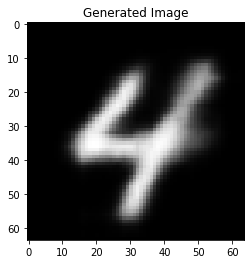

Epoch 464/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.43it/s]

Epoch [464/500], Loss: 64606.1016 (total loss), 61196.2266 (bce), 3409.8735 (kld)
Mu range: -0.9934772253036499 ~ 1.8355683088302612, Logvar range: -6.688314914703369 ~ 0.03605082631111145
tensor(2)


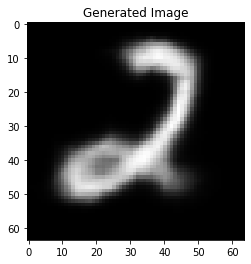

Epoch 465/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.74it/s]

Epoch [465/500], Loss: 66099.7266 (total loss), 62618.8281 (bce), 3480.9004 (kld)
Mu range: -1.484339714050293 ~ 2.403372287750244, Logvar range: -6.1093597412109375 ~ -0.055224910378456116
tensor(5)


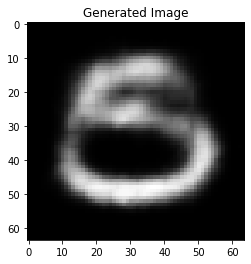

Epoch 466/500: 100%|██████████████████████████| 118/118 [00:11<00:00,  9.93it/s]


Epoch [466/500], Loss: 65307.8906 (total loss), 61760.0938 (bce), 3547.7966 (kld)
Mu range: -4.004546165466309 ~ 2.672759532928467, Logvar range: -7.364761829376221 ~ 0.14500543475151062
tensor(5)


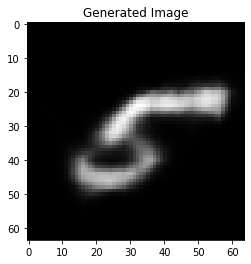

Epoch 467/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.45it/s]

Epoch [467/500], Loss: 68882.9688 (total loss), 65405.1953 (bce), 3477.7720 (kld)
Mu range: -1.1048773527145386 ~ 1.5443062782287598, Logvar range: -6.143640995025635 ~ -0.059687450528144836
tensor(8)


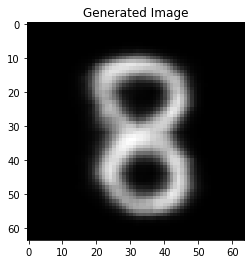

Epoch 468/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.57it/s]


Epoch [468/500], Loss: 63627.6641 (total loss), 60188.9844 (bce), 3438.6777 (kld)
Mu range: -1.561945915222168 ~ 2.2764101028442383, Logvar range: -5.456008434295654 ~ -0.08506722748279572
tensor(2)


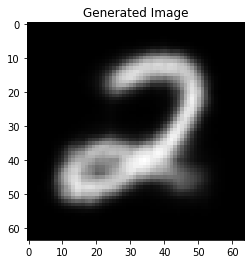

Epoch 469/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.81it/s]

Epoch [469/500], Loss: 66777.1016 (total loss), 63356.0977 (bce), 3421.0024 (kld)
Mu range: -1.8196990489959717 ~ 2.040811777114868, Logvar range: -6.116586208343506 ~ -0.05256430804729462
tensor(3)


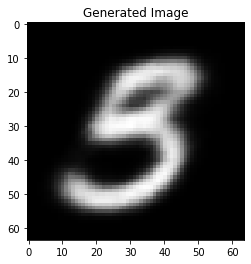

Epoch 470/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.54it/s]


Epoch [470/500], Loss: 64427.7461 (total loss), 60847.5469 (bce), 3580.1978 (kld)
Mu range: -0.7948107123374939 ~ 1.2373048067092896, Logvar range: -5.790478229522705 ~ -0.1001569926738739
tensor(1)


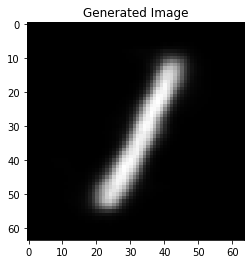

Epoch 471/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.33it/s]


Epoch [471/500], Loss: 65443.2656 (total loss), 62042.8008 (bce), 3400.4663 (kld)
Mu range: -1.2003374099731445 ~ 1.9587451219558716, Logvar range: -6.324689865112305 ~ -0.012278586626052856
tensor(1)


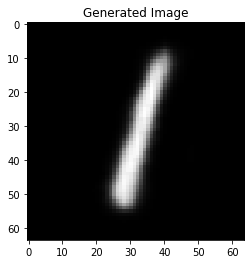

Epoch 472/500: 100%|██████████████████████████| 118/118 [00:11<00:00,  9.88it/s]


Epoch [472/500], Loss: 66649.6641 (total loss), 63150.5000 (bce), 3499.1636 (kld)
Mu range: -2.381035804748535 ~ 1.4074441194534302, Logvar range: -6.986162185668945 ~ 0.041086286306381226
tensor(7)


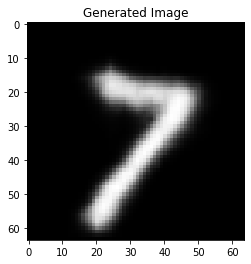

Epoch 473/500: 100%|██████████████████████████| 118/118 [00:13<00:00,  8.99it/s]


Epoch [473/500], Loss: 66255.2656 (total loss), 62769.7812 (bce), 3485.4854 (kld)
Mu range: -1.538924217224121 ~ 1.6971317529678345, Logvar range: -6.257651329040527 ~ 0.01226094365119934
tensor(7)


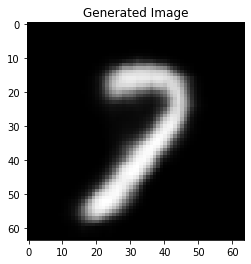

Epoch 474/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.43it/s]

Epoch [474/500], Loss: 63020.6562 (total loss), 59531.4766 (bce), 3489.1777 (kld)
Mu range: -1.7536004781723022 ~ 2.0607571601867676, Logvar range: -6.634087085723877 ~ -0.01991628110408783
tensor(7)


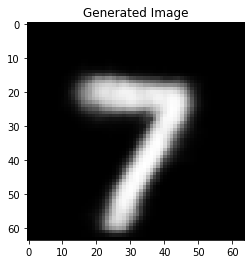

Epoch 475/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.26it/s]

Epoch [475/500], Loss: 68069.2656 (total loss), 64513.9141 (bce), 3555.3518 (kld)
Mu range: -2.0788142681121826 ~ 2.0413734912872314, Logvar range: -7.741809844970703 ~ 0.07683935761451721
tensor(7)


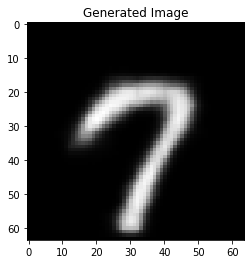

Epoch 476/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.48it/s]


Epoch [476/500], Loss: 67501.3438 (total loss), 64068.6484 (bce), 3432.6958 (kld)
Mu range: -2.1852285861968994 ~ 1.7631714344024658, Logvar range: -6.194457054138184 ~ 0.007292985916137695
tensor(0)


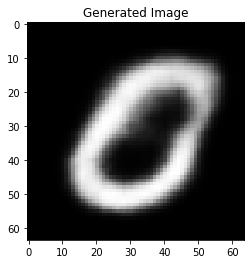

Epoch 477/500: 100%|██████████████████████████| 118/118 [00:11<00:00,  9.84it/s]


Epoch [477/500], Loss: 65649.7812 (total loss), 62186.6602 (bce), 3463.1216 (kld)
Mu range: -0.3069567084312439 ~ 0.8737308979034424, Logvar range: -5.862985610961914 ~ -0.08331701159477234
tensor(3)


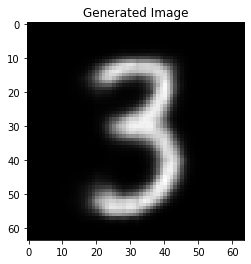

Epoch 478/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.45it/s]


Epoch [478/500], Loss: 64276.4453 (total loss), 60752.9219 (bce), 3523.5244 (kld)
Mu range: -0.6945887804031372 ~ 1.477294921875, Logvar range: -6.087723731994629 ~ -0.09183813631534576
tensor(5)


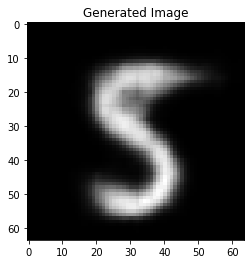

Epoch 479/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.11it/s]

Epoch [479/500], Loss: 62320.8359 (total loss), 58967.2852 (bce), 3353.5503 (kld)
Mu range: -0.7565679550170898 ~ 1.7799954414367676, Logvar range: -5.388304710388184 ~ -0.11115686595439911
tensor(3)


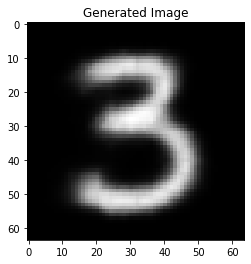

Epoch 480/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.16it/s]


Epoch [480/500], Loss: 66766.2422 (total loss), 63192.8242 (bce), 3573.4189 (kld)
Mu range: -0.7791039347648621 ~ 1.6925926208496094, Logvar range: -6.015501976013184 ~ -0.05743527412414551
tensor(1)


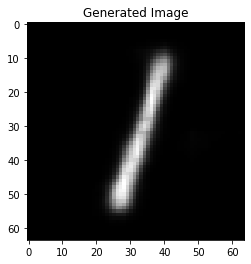

Epoch 481/500: 100%|██████████████████████████| 118/118 [00:13<00:00,  8.72it/s]

Epoch [481/500], Loss: 65987.3281 (total loss), 62464.4961 (bce), 3522.8291 (kld)
Mu range: -1.0051980018615723 ~ 1.4192252159118652, Logvar range: -5.585908889770508 ~ -0.09756293892860413
tensor(5)


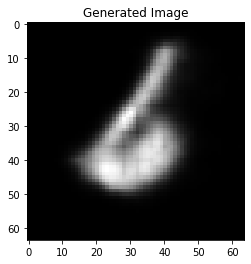

Epoch 482/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.12it/s]


Epoch [482/500], Loss: 65562.4375 (total loss), 62173.7266 (bce), 3388.7144 (kld)
Mu range: -1.784376621246338 ~ 1.8780267238616943, Logvar range: -6.3529863357543945 ~ -0.03752131760120392
tensor(8)


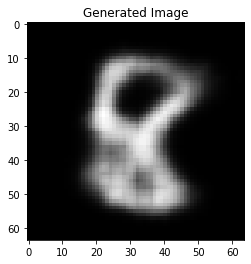

Epoch 483/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.36it/s]

Epoch [483/500], Loss: 65555.2422 (total loss), 62008.4336 (bce), 3546.8071 (kld)
Mu range: -1.0161476135253906 ~ 1.6064952611923218, Logvar range: -6.464814186096191 ~ 0.045367076992988586
tensor(6)


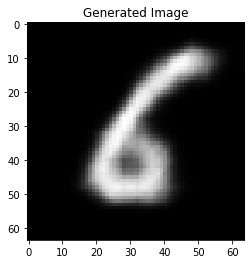

Epoch 484/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.28it/s]


Epoch [484/500], Loss: 68383.8125 (total loss), 64841.4414 (bce), 3542.3691 (kld)
Mu range: -1.3537914752960205 ~ 1.6826236248016357, Logvar range: -5.087075710296631 ~ -0.14922654628753662
tensor(5)


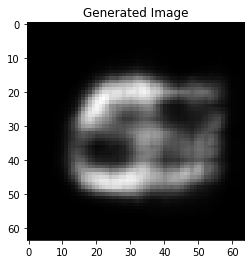

Epoch 485/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.42it/s]


Epoch [485/500], Loss: 65707.9219 (total loss), 62289.2109 (bce), 3418.7144 (kld)
Mu range: -2.00337815284729 ~ 1.7774364948272705, Logvar range: -6.643243312835693 ~ 0.03665342926979065
tensor(2)


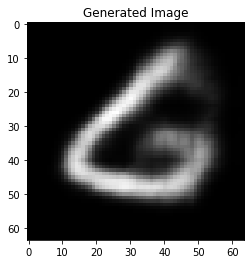

Epoch 486/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.24it/s]


Epoch [486/500], Loss: 64822.6445 (total loss), 61311.3945 (bce), 3511.2507 (kld)
Mu range: -1.313361644744873 ~ 3.1909284591674805, Logvar range: -7.0241265296936035 ~ 0.07024224102497101
tensor(1)


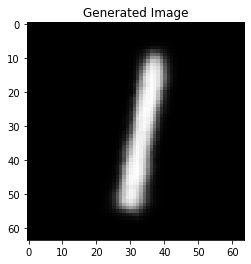

Epoch 487/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.31it/s]


Epoch [487/500], Loss: 64170.2109 (total loss), 60681.7188 (bce), 3488.4927 (kld)
Mu range: -0.9561339020729065 ~ 1.2864186763763428, Logvar range: -5.848423957824707 ~ -0.08370216190814972
tensor(1)


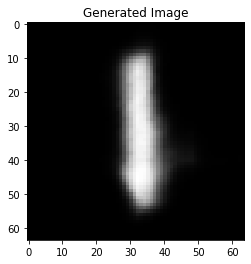

Epoch 488/500: 100%|██████████████████████████| 118/118 [00:13<00:00,  9.04it/s]


Epoch [488/500], Loss: 67546.5234 (total loss), 64043.4453 (bce), 3503.0762 (kld)
Mu range: -1.1204135417938232 ~ 0.8902783393859863, Logvar range: -6.38894510269165 ~ -0.05342365801334381
tensor(3)


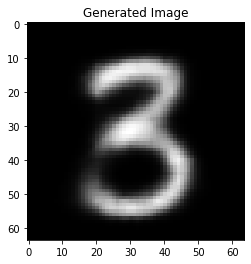

Epoch 489/500: 100%|██████████████████████████| 118/118 [00:13<00:00,  8.96it/s]


Epoch [489/500], Loss: 64394.8086 (total loss), 60909.8359 (bce), 3484.9727 (kld)
Mu range: -2.0004005432128906 ~ 1.3789732456207275, Logvar range: -4.996110439300537 ~ -0.15345261991024017
tensor(2)


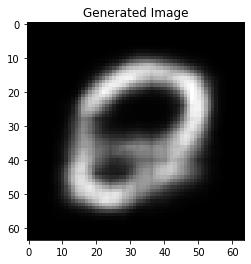

Epoch 490/500: 100%|██████████████████████████| 118/118 [00:13<00:00,  8.94it/s]


Epoch [490/500], Loss: 64954.3906 (total loss), 61529.9062 (bce), 3424.4824 (kld)
Mu range: -1.0837823152542114 ~ 0.7407388687133789, Logvar range: -5.5115814208984375 ~ -0.10933093726634979
tensor(7)


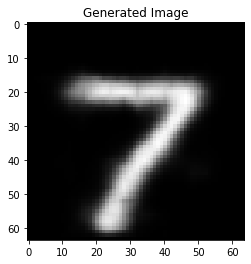

Epoch 491/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.18it/s]


Epoch [491/500], Loss: 65327.6406 (total loss), 61857.8203 (bce), 3469.8188 (kld)
Mu range: -1.7076740264892578 ~ 1.5035079717636108, Logvar range: -6.007776260375977 ~ -0.06634405255317688
tensor(0)


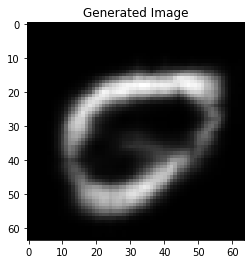

Epoch 492/500: 100%|██████████████████████████| 118/118 [00:13<00:00,  9.01it/s]


Epoch [492/500], Loss: 60694.3008 (total loss), 57115.7812 (bce), 3578.5200 (kld)
Mu range: -1.8182729482650757 ~ 1.8854424953460693, Logvar range: -7.1524224281311035 ~ 0.03501291573047638
tensor(1)


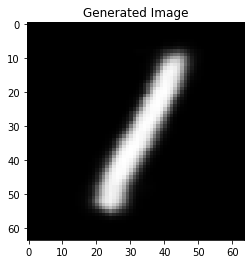

Epoch 493/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.30it/s]


Epoch [493/500], Loss: 66196.9922 (total loss), 62708.6484 (bce), 3488.3418 (kld)
Mu range: -1.0742361545562744 ~ 2.1271772384643555, Logvar range: -5.445339679718018 ~ -0.07576119899749756
tensor(3)


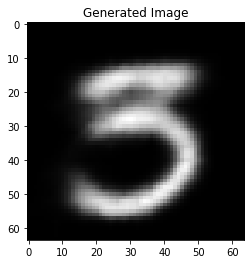

Epoch 494/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.13it/s]

Epoch [494/500], Loss: 65930.1328 (total loss), 62437.6836 (bce), 3492.4521 (kld)
Mu range: -2.184983730316162 ~ 2.1496567726135254, Logvar range: -6.774156093597412 ~ -0.03331303596496582
tensor(8)


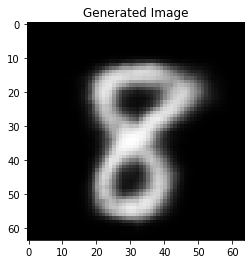

Epoch 495/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.34it/s]


Epoch [495/500], Loss: 65015.1328 (total loss), 61512.3867 (bce), 3502.7473 (kld)
Mu range: -0.5162584185600281 ~ 0.8975250720977783, Logvar range: -5.763628005981445 ~ -0.0981593132019043
tensor(4)


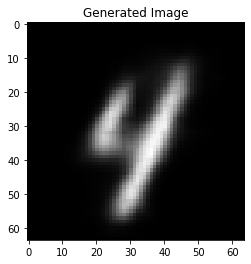

Epoch 496/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.21it/s]


Epoch [496/500], Loss: 67967.6875 (total loss), 64538.2578 (bce), 3429.4270 (kld)
Mu range: -1.395900011062622 ~ 0.6606225967407227, Logvar range: -6.0053606033325195 ~ -0.07602871209383011
tensor(7)


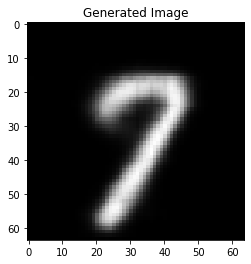

Epoch 497/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.36it/s]


Epoch [497/500], Loss: 68098.6484 (total loss), 64583.5781 (bce), 3515.0693 (kld)
Mu range: -0.8550055623054504 ~ 1.345383882522583, Logvar range: -6.3582763671875 ~ 0.014045864343643188
tensor(2)


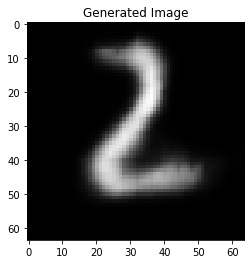

Epoch 498/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.28it/s]


Epoch [498/500], Loss: 62020.3203 (total loss), 58452.0039 (bce), 3568.3174 (kld)
Mu range: -0.9556767344474792 ~ 1.3389778137207031, Logvar range: -6.422247886657715 ~ -0.04918767511844635
tensor(7)


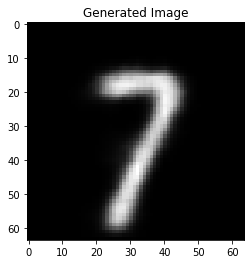

Epoch 499/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.52it/s]


Epoch [499/500], Loss: 67314.7500 (total loss), 63785.8047 (bce), 3528.9468 (kld)
Mu range: -1.218996286392212 ~ 1.780128002166748, Logvar range: -6.060610771179199 ~ -0.08041991293430328
tensor(2)


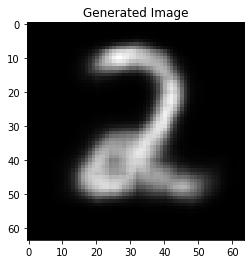

Epoch 500/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.22it/s]


Epoch [500/500], Loss: 65328.7305 (total loss), 61738.1484 (bce), 3590.5808 (kld)
Mu range: -2.430424690246582 ~ 1.2673168182373047, Logvar range: -6.023889541625977 ~ -0.06537379324436188
tensor(3)


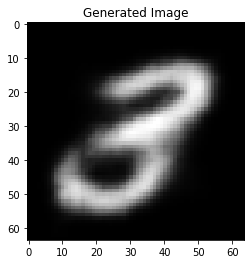

In [46]:
epochs = 500

for epoch in range(epochs):
    for idx, (images, label) in enumerate(tqdm(dataloader, desc=f'Epoch {epoch + 1}/{epochs}')):
        optimizer.zero_grad()

        images = images.float().to(device) # train image (BATCH_SIZE, 1, 64, 64)
        recon_images, mu, logvar = model(images)
        
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar) # loss calculation
        
        if torch.isnan(loss).any(): # nan loss is not acceptable
            print("NaN value in loss!")
            break

        loss.backward()
        optimizer.step()

    scheduler.step()

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f} (total loss), {bce.item():.4f} (bce), {abs(kld.item()):.4f} (kld)")
    print(f"Mu range: {torch.min(mu[0])} ~ {torch.max(mu[0])}, Logvar range: {torch.min(logvar[0])} ~ {torch.max(logvar[0])}")

    # Print label and plot generated image
    print(label[0])
    plt.imshow(recon_images[0].permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
    plt.title("Generated Image")
    plt.show() 


In [50]:
# import torchvision

# def imshow(img):
#     img = img / 2 + 0.5
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()

# # 모델에서 이미지 생성
# with torch.no_grad():
#     recon_images, _, _ = model(images)

# # 생성된 이미지를 그리드로 만들어 시각화
# imshow(torchvision.utils.make_grid(recon_images.cpu()))


In [47]:
# epochs = 500

# for epoch in range(epochs):
#     for idx, (images, label) in enumerate(tqdm(dataloader, desc=f'Epoch {epoch + 1}/{epochs}')):
#         optimizer.zero_grad()

#         images = images.float().to(device) # train image (BATCH_SIZE, 1, 64, 64)
#         recon_images, mu, logvar = model(images)
        
#         loss, bce, kld = loss_fn(recon_images, images, mu, logvar) # loss calculation
        
#         if torch.isnan(loss).any(): # nan loss is not acceptable
#             print("NaN value in loss!")
#             break

#         loss.backward()
#         optimizer.step()

#     scheduler.step()

#     print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f} (total loss), {bce.item():.4f} (bce), {abs(kld.item()):.4f} (kld)")
#     print(f"Mu range: {torch.min(mu[0])} ~ {torch.max(mu[0])}, Logvar range: {torch.min(logvar[0])} ~ {torch.max(logvar[0])}")

# torch.save(model, './500epochs_KLD*30.pth')